## 1. Import libraries

In [ ]:
# %pip install yfinance
# %pip install mlxtend
# %pip install xgboost
# %pip install shap

In [1]:
# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
#from functools import reduce
import matplotlib.pyplot as plt
#import mlxtend
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import statsmodels.formula.api as smf
from scipy.stats import pointbiserialr
from scipy.stats import linregress
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
#from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import mean_squared_error
#from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#from sklearn.feature_selection import SelectKBest, chi2, SelectFwe
from sklearn.model_selection import train_test_split
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
import shap

## 2. Import files

In [2]:
# Import Gross Domestic Product
gdp = pd.read_excel("GDP_Growth.xlsx").dropna(axis=1)
gdp = gdp[['Year', 'GDP_Growth']]
gdp.tail()

,Year,GDP_Growth
22,2020,-2.767803
23,2021,5.945485
24,2022,1.935635
25,2023,2.500000
26,2024,1.300000


In [3]:
# Import Consumer Price Index
cpi = pd.read_excel("ConsumerPriceIndex.xlsx").dropna(axis=1)
cpi.tail()

,Year,Min,Max,Avg
22,2020,1.2,2.4,1.700
23,2021,1.3,5.5,3.575
24,2022,5.7,6.6,6.150
25,2023,3.9,5.6,4.775
26,2024,3.6,3.9,3.775


In [4]:
# Import active companies
stocks = pd.read_excel("Stock_Tickers.xlsx")
stock_tickers = stocks['Symbol'].tolist()
stocks

,Symbol,Sector
0,AA,Basic Materials
1,ACNT,Basic Materials
2,ALB,Basic Materials
3,AMR,Basic Materials
4,APD,Basic Materials
...,...,...
3076,VST,Utilities
3077,WEC,Utilities
3078,WTRG,Utilities
3079,XEL,Utilities


In [5]:
# Import list of Bankrupt Companies
bankruptcies = pd.read_excel("Bankrupt_Tickers.xlsx")
bankruptcies['Bankruptcy_Year'] = bankruptcies['Bankruptcy_Filed_Date'].dt.year
bankruptcies

,Symbol,Bankruptcy_Filed_Date,Company,Sector,Bankruptcy_Year
0,AACH,2020-12-14,Aac Holdings Inc,Healthcare,2020
1,AAIIQ,2021-08-26,Alabama Aircraft Industries Inc,Industrials,2021
2,ABAT,2015-12-30,Advanced Battery Technologies Inc,Basic Materials,2015
3,ABDS,2010-08-12,Allegro Biodiesel Corp,Energy,2010
4,ABFIQ,2008-06-25,American Business Financial Services Inc,Financial,2008
...,...,...,...,...,...
547,PKDSQ,2019-03-26,Parker Drilling Co.,NaN,2019
548,SGYPQ,2019-03-07,Synergy Pharmaceuticals Inc,NaN,2019
549,PTXTQ,2019-03-04,Pernix Therapeutics Holdings Inc,NaN,2019
550,ISON,2019-02-07,Isonics Corp,NaN,2019


In [6]:
# Filter bankrupt companies to those after 2018
bankruptcies_recent= bankruptcies[bankruptcies['Bankruptcy_Year']>2018]
bankrupt_tickers = bankruptcies_recent['Symbol'].tolist()
bankruptcies_recent.shape

(450, 5)

## 3. Explore Data

<Axes: xlabel='Year'>

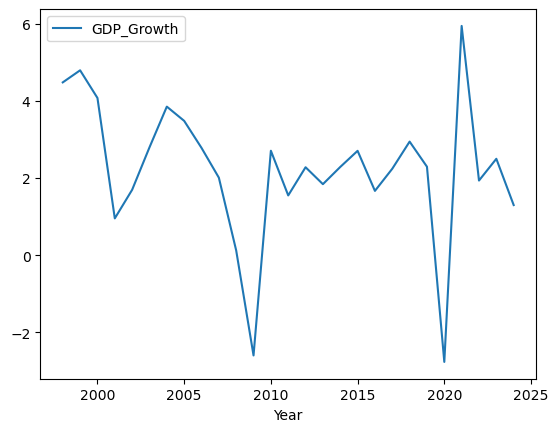

In [7]:
# Plot line graph of GDP Data
gdp.plot(x='Year', y='GDP_Growth')

<Axes: xlabel='Year'>

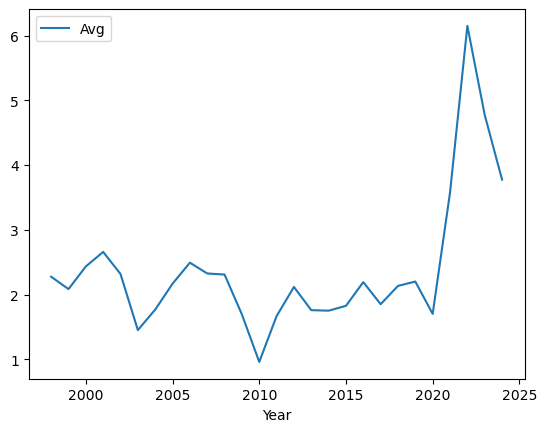

In [8]:
# Plot line graph of Consumer Price Index Data
cpi.plot(x='Year', y='Avg')

<Axes: xlabel='Sector'>

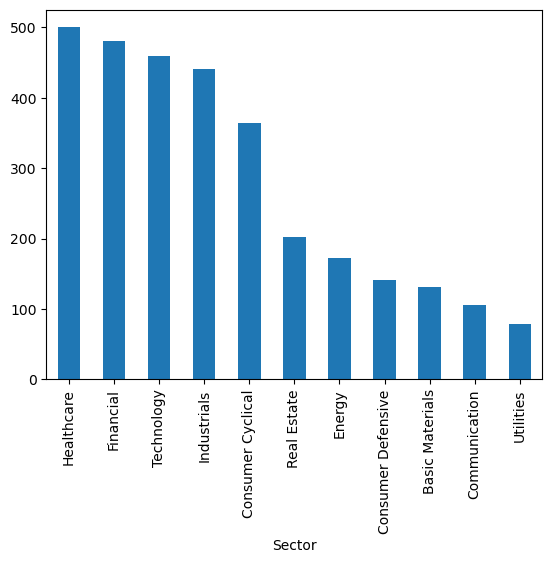

In [9]:
stocks['Sector'].value_counts().plot(kind='bar')

<Axes: xlabel='Sector'>

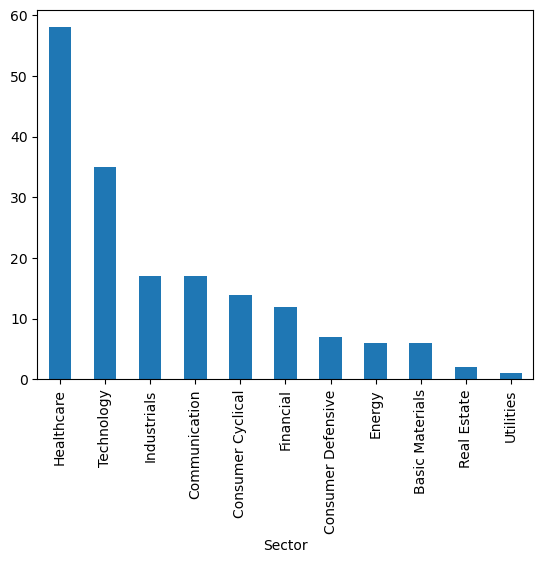

In [10]:
# Plot frequency chart of how many companies belong to each sector
bankruptcies_recent['Sector'].value_counts().plot(kind='bar')

<Axes: xlabel='Bankruptcy_Year'>

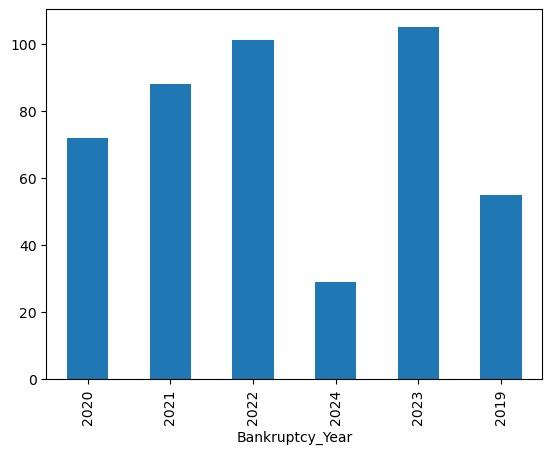

In [11]:
# Frequency chart of bankruptcies by year
bankruptcies_recent['Bankruptcy_Year'].value_counts(sort=False).plot(kind='bar')

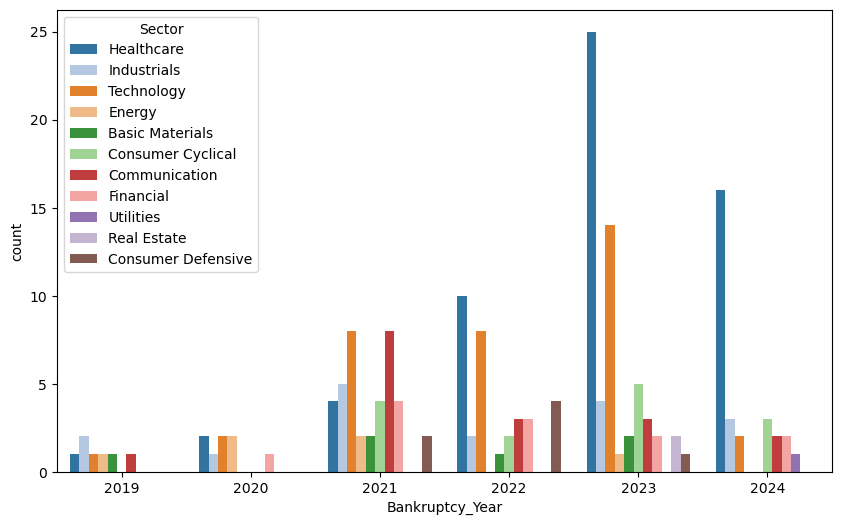

In [12]:
# Frequency chart of bankruptices by year, colored by sector
plt.figure(figsize=(10,6))
ax = sns.countplot(data=bankruptcies_recent, x='Bankruptcy_Year', hue='Sector', palette='tab20')

## 4. Import Financial Data from yahoo!finance

#### Program provided by Jun Kevin (https://www.kaggle.com/code/junkevin/how-to-use-yfinance-for-generating-this-data/notebook)

In [ ]:
# # Program to fetch data from yfinance
# def fetch_and_transform_data(ticker_symbol, statement_type):
#     try:
#         # Fetch financial data based on the specified statement type
#         if statement_type == 'CF':
#             financial_data = yf.Ticker(ticker_symbol).cashflow
#         elif statement_type == 'IS':
#             financial_data = yf.Ticker(ticker_symbol).financials
#         elif statement_type == 'BS':
#             financial_data = yf.Ticker(ticker_symbol).balancesheet

#         # Prepare data for transformation
#         dfs = []
#         available_dates = financial_data.columns
        
#         # Iterate over each available date
#         for date in available_dates:
#             # Extract financial data for the current date
#             year = pd.to_datetime(date).year

#             data_date = financial_data[date]
            
#             # Append each account as a row in the DataFrame
#             for account, value in data_date.items():
#                 dfs.append({
#                     'symbol': ticker_symbol,
#                     'account': account,
#                     'type': statement_type,  
#                     'year': year,
#                     'value': value
#                 })
        
#         # Create DataFrame from the collected data
#         return pd.DataFrame(dfs)
    
#     except:
#         print(f"No data available for {ticker_symbol} ({statement_type})")
#         return None

In [ ]:
# # Get active companies financial data
# # Fetch and combine data for all ticker symbols
# combined_dataframes = []

# for ticker_symbol in stock_tickers:
#     # Fetch and transform cash flow data
#     cash_flow_data = fetch_and_transform_data(ticker_symbol, 'CF')
    
#     # Fetch and transform income statement data
#     income_statement_data = fetch_and_transform_data(ticker_symbol, 'IS')

#     # Fetch and transform income statement data
#     balance_sheet_data = fetch_and_transform_data(ticker_symbol, 'BS')

#     # Concatenate dataframes (cash flow and income statement) for the current ticker symbol
#     combined_data = pd.concat([cash_flow_data, income_statement_data, balance_sheet_data], ignore_index=True)
#     combined_dataframes.append(combined_data)

# # Combine all dataframes into a single DataFrame
# if combined_dataframes:
#     all_data = pd.concat(combined_dataframes, ignore_index=True)

#     # Pivot the DataFrame to convert dates into columns
#     pivot_data = all_data.pivot_table(index=['symbol', 'year'], columns='account', values='value').reset_index()

#     # Reorder columns to match the desired format
#     desired_columns_order = ['symbol', 'year'] + list(pivot_data.columns[3:])  # Include all columns after 'type'
    
#     alive_data = pivot_data[desired_columns_order]
#     #alive_data['symbol'] = alive_data['symbol'].apply(lambda x: x.split('.')[0])

#     # Convert NaN values to empty strings if needed
#     alive_data = alive_data.fillna('')

#     # Save DataFrame to CSV
#     filename = 'combined_financial_data_idx.csv'
#     alive_data.to_csv(filename, index=False)

#     # Display the final transformed data
#     print("Combined financial data:")
#     print(alive_data)
# else:
#     print("Unable to retrieve and combine financial data for all ticker symbols.")

In [ ]:
# # Get bankrupt companies financial data
# # Fetch and combine data for all ticker symbols
# bankrupt_combined_dataframes = []

# for ticker_symbol in bankrupt_tickers:
#     # Fetch and transform cash flow data
#     bankrupt_cash_flow_data = fetch_and_transform_data(ticker_symbol, 'CF')
    
#     # Fetch and transform income statement data
#     bankrupt_income_statement_data = fetch_and_transform_data(ticker_symbol, 'IS')

#     # Fetch and transform income statement data
#     bankrupt_balance_sheet_data = fetch_and_transform_data(ticker_symbol, 'BS')

#     # Concatenate dataframes (cash flow and income statement) for the current ticker symbol
#     bankrupt_combined_data = pd.concat([bankrupt_cash_flow_data, bankrupt_income_statement_data, bankrupt_balance_sheet_data], ignore_index=True)
#     bankrupt_combined_dataframes.append(bankrupt_combined_data)

# # Combine all dataframes into a single DataFrame
# if bankrupt_combined_dataframes:
#     bankrupt_all_data = pd.concat(bankrupt_combined_dataframes, ignore_index=True)

#     # Pivot the DataFrame to convert dates into columns
#     bankrupt_pivot_data = bankrupt_all_data.pivot_table(index=['symbol', 'year'], columns='account', values='value').reset_index()

#     # Reorder columns to match the desired format
#     bankrupt_desired_columns_order = ['symbol', 'year'] + list(bankrupt_pivot_data.columns[3:])  # Include all columns after 'type'
    
#     bankrupt_final_data = bankrupt_pivot_data[bankrupt_desired_columns_order]
#     bankrupt_final_data['symbol'] = bankrupt_final_data['symbol'].apply(lambda x: x.split('.')[0])

#     # Convert NaN values to empty strings if needed
#     bankrupt_final_data = bankrupt_final_data.fillna('')
    
#     # Save DataFrame to CSV
#     bankrupt_filename = 'bankrupt_combined_financial_data_idx.csv'
#     bankrupt_final_data.to_csv(bankrupt_filename, index=False)

#     # Display the final transformed data
#     print("bankrupt_Combined financial data:")
#     print(bankrupt_final_data)
# else:
#     print("Unable to retrieve and combine financial data for all ticker symbols.")

## 5. Non-bankrupt Company Data Cleansing

In [13]:
# Import active companies financial data in saved spreadsheet from above program as backup since downloading data takes time
alive_data = pd.read_csv("combined_financial_data_idx.csv")

In [14]:
# Add binary column to denote company is active
alive_data['Bankrupt'] = '0'
pd.options.display.float_format = '{:20,.2f}'.format
alive_data.head()

,symbol,year,Accounts Receivable,Accrued Interest Receivable,Accumulated Depreciation,Additional Paid In Capital,Allowance For Doubtful Accounts Receivable,Amortization,Amortization Cash Flow,Amortization Of Intangibles,...,Tradeand Other Payables Non Current,Trading Securities,Treasury Shares Number,Treasury Stock,Unrealized Gain Loss,Unrealized Gain Loss On Investment Securities,Work In Process,Working Capital,Write Off,Bankrupt
0,A,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"-1,000,000.00",NaN,NaN,NaN,0
1,A,2020,"1,038,000,000.00",NaN,"-1,029,000,000.00","5,311,000,000.00",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"-28,000,000.00",NaN,"1,948,000,000.00",NaN,0
2,A,2021,"1,172,000,000.00",NaN,"-1,122,000,000.00","5,320,000,000.00",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2,091,000,000.00",NaN,0
3,A,2022,"1,405,000,000.00",NaN,"-1,148,000,000.00","5,325,000,000.00",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1,917,000,000.00",NaN,0
4,A,2023,"1,291,000,000.00",NaN,"-1,223,000,000.00","5,387,000,000.00",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2,583,000,000.00",NaN,0


In [15]:
# Add Sector to financial data for active companies
alive_data_sectors = pd.merge(alive_data, stocks[['Symbol','Sector']], how='left', left_on='symbol', right_on='Symbol')
alive_data_sectors

,symbol,year,Accounts Receivable,Accrued Interest Receivable,Accumulated Depreciation,Additional Paid In Capital,Allowance For Doubtful Accounts Receivable,Amortization,Amortization Cash Flow,Amortization Of Intangibles,...,Treasury Shares Number,Treasury Stock,Unrealized Gain Loss,Unrealized Gain Loss On Investment Securities,Work In Process,Working Capital,Write Off,Bankrupt,Symbol,Sector
0,A,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"-1,000,000.00",NaN,NaN,NaN,0,A,Healthcare
1,A,2020,"1,038,000,000.00",NaN,"-1,029,000,000.00","5,311,000,000.00",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"-28,000,000.00",NaN,"1,948,000,000.00",NaN,0,A,Healthcare
2,A,2021,"1,172,000,000.00",NaN,"-1,122,000,000.00","5,320,000,000.00",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"2,091,000,000.00",NaN,0,A,Healthcare
3,A,2022,"1,405,000,000.00",NaN,"-1,148,000,000.00","5,325,000,000.00",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"1,917,000,000.00",NaN,0,A,Healthcare
4,A,2023,"1,291,000,000.00",NaN,"-1,223,000,000.00","5,387,000,000.00",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"2,583,000,000.00",NaN,0,A,Healthcare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14966,ZYXI,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,ZYXI,Healthcare
14967,ZYXI,2020,"13,837,000.00",NaN,"-2,507,000.00","37,235,000.00",NaN,NaN,0.00,0.00,...,"1,178,342.00","3,846,000.00",NaN,NaN,"1,455,000.00","52,906,000.00",NaN,0,ZYXI,Healthcare
14968,ZYXI,2021,"28,632,000.00",NaN,"-2,642,000.00","80,397,000.00",NaN,NaN,"25,000.00","25,000.00",...,"1,246,399.00","6,513,000.00",NaN,NaN,"345,000.00","59,818,000.00",NaN,0,ZYXI,Healthcare
14969,ZYXI,2022,"35,063,000.00",NaN,"-3,292,000.00","82,431,000.00",NaN,NaN,"930,000.00","930,000.00",...,"4,253,015.00","33,160,000.00",NaN,NaN,"1,205,000.00","48,473,000.00",NaN,0,ZYXI,Healthcare


In [16]:
# Keep select columns for calculating financial ratios
alive_data_trim = alive_data_sectors[['symbol',
'year',
'Basic EPS',
'Current Assets',
'Current Liabilities',
'EBIT',
'Interest Expense',
'Inventory',
'Net Income',
'Stockholders Equity',
'Total Assets',
'Total Liabilities Net Minority Interest',
'Sector',
'Bankrupt'
]]

alive_data_trim

,symbol,year,Basic EPS,Current Assets,Current Liabilities,EBIT,Interest Expense,Inventory,Net Income,Stockholders Equity,Total Assets,Total Liabilities Net Minority Interest,Sector,Bankrupt
0,A,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare,0
1,A,2020,2.33,"3,415,000,000.00","1,467,000,000.00","920,000,000.00","78,000,000.00","720,000,000.00","719,000,000.00","4,873,000,000.00","9,627,000,000.00","4,754,000,000.00",Healthcare,0
2,A,2021,3.98,"3,799,000,000.00","1,708,000,000.00","1,441,000,000.00","81,000,000.00","830,000,000.00","1,210,000,000.00","5,389,000,000.00","10,705,000,000.00","5,316,000,000.00",Healthcare,0
3,A,2022,4.19,"3,778,000,000.00","1,861,000,000.00","1,588,000,000.00","84,000,000.00","1,038,000,000.00","1,254,000,000.00","5,305,000,000.00","10,532,000,000.00","5,227,000,000.00",Healthcare,0
4,A,2023,4.22,"4,186,000,000.00","1,603,000,000.00","1,434,000,000.00","95,000,000.00","1,031,000,000.00","1,240,000,000.00","5,845,000,000.00","10,763,000,000.00","4,918,000,000.00",Healthcare,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14966,ZYXI,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare,0
14967,ZYXI,2020,0.24,"63,023,000.00","10,117,000.00","10,172,000.00","19,000.00","8,635,000.00","9,074,000.00","56,855,000.00","72,175,000.00","15,320,000.00",Healthcare,0
14968,ZYXI,2021,0.45,"82,689,000.00","22,871,000.00","22,366,000.00","95,000.00","10,756,000.00","17,103,000.00","73,925,000.00","133,274,000.00","59,349,000.00",Healthcare,0
14969,ZYXI,2022,0.44,"69,559,000.00","21,086,000.00","22,638,000.00","440,000.00","13,484,000.00","17,048,000.00","66,358,000.00","116,466,000.00","50,108,000.00",Healthcare,0


In [17]:
# Check data types
alive_data_trim.dtypes

symbol                                      object
year                                         int64
Basic EPS                                  float64
Current Assets                             float64
Current Liabilities                        float64
EBIT                                       float64
Interest Expense                           float64
Inventory                                  float64
Net Income                                 float64
Stockholders Equity                        float64
Total Assets                               float64
Total Liabilities Net Minority Interest    float64
Sector                                      object
Bankrupt                                    object
dtype: object

In [18]:
# Convert binary bankrupt column to numeric and symbol and Sector columns to string
alive_data_trim['Bankrupt'] = pd.to_numeric(alive_data_trim['Bankrupt'])

# alive_data_trim['Sector'] = alive_data_trim['Sector'].astype(pd.StringDtype())

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\537974655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alive_data_trim['Bankrupt'] = pd.to_numeric(alive_data_trim['Bankrupt'])


In [19]:
# Check data types
alive_data_trim.dtypes

symbol                                      object
year                                         int64
Basic EPS                                  float64
Current Assets                             float64
Current Liabilities                        float64
EBIT                                       float64
Interest Expense                           float64
Inventory                                  float64
Net Income                                 float64
Stockholders Equity                        float64
Total Assets                               float64
Total Liabilities Net Minority Interest    float64
Sector                                      object
Bankrupt                                     int64
dtype: object

In [20]:
# Descriptive statistics
alive_data_trim.describe(include='all')

,symbol,year,Basic EPS,Current Assets,Current Liabilities,EBIT,Interest Expense,Inventory,Net Income,Stockholders Equity,Total Assets,Total Liabilities Net Minority Interest,Sector,Bankrupt
count,14971,"14,971.00","12,084.00","10,414.00","10,409.00","10,584.00","10,482.00","6,739.00","12,130.00","12,145.00","12,150.00","12,150.00",14971,"14,971.00"
unique,3080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,NaN
top,UAA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare,NaN
freq,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2413,NaN
mean,NaN,"2,021.11",-1.55,"2,922,448,100.89","2,150,935,506.87","755,621,277.53","198,743,744.81","904,311,485.74","486,900,473.03","3,425,100,956.74","14,826,545,170.46","11,233,244,379.80",NaN,0.00
std,NaN,1.42,205.18,"10,259,814,907.75","8,280,254,994.39","4,050,850,525.39","1,674,424,802.23","3,184,416,405.73","3,160,933,651.12","13,643,398,476.33","100,535,051,009.63","90,377,504,187.85",NaN,0.00
min,NaN,"2,019.00","-21,386.47",0.00,0.00,"-27,725,000,000.00","-17,406,000.00",0.00,"-22,440,000,000.00","-18,316,000,000.00",0.00,0.00,NaN,0.00
25%,NaN,"2,020.00",-0.58,"186,669,000.00","68,036,000.00","-13,958,500.00","4,047,379.00","27,331,500.00","-22,797,500.00","189,941,079.00","512,245,750.00","193,998,000.00",NaN,0.00
50%,NaN,"2,021.00",0.88,"567,336,000.00","287,147,000.00","72,216,500.00","27,377,500.00","150,800,000.00","35,583,342.00","624,942,852.00","1,930,900,000.00","1,067,874,500.00",NaN,0.00
75%,NaN,"2,022.00",3.25,"1,884,674,750.00","1,103,321,000.00","429,767,500.00","111,075,000.00","629,538,000.00","242,879,000.00","2,013,900,000.00","6,829,570,789.00","4,474,140,750.00",NaN,0.00


## 6. Bankrupt Data

In [21]:
# Import bankrupt company financial data from exported file as backup to avoid re-running program
bankrupt_final_data = pd.read_csv("bankrupt_combined_financial_data_idx.csv")
bankrupt_final_data

,symbol,year,Accounts Receivable,Accrued Interest Receivable,Accumulated Depreciation,Additional Paid In Capital,Allowance For Doubtful Accounts Receivable,Amortization,Amortization Cash Flow,Amortization Of Intangibles,...,Total Unusual Items Excluding Goodwill,Tradeand Other Payables Non Current,Trading Securities,Treasury Shares Number,Treasury Stock,Unrealized Gain Loss,Unrealized Gain Loss On Investment Securities,Work In Process,Working Capital,Write Off
0,ABMC,2019,"370,000.00",NaN,"-3,329,000.00","21,437,000.00","-34,000.00",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"141,000.00","-463,000.00",NaN
1,ABMC,2020,"407,000.00",NaN,"-3,400,000.00","21,717,000.00","-22,000.00",NaN,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,"127,000.00","-841,000.00",NaN
2,ABMC,2021,"323,000.00",NaN,"-3,459,000.00","22,393,000.00","-3,000.00",NaN,NaN,NaN,...,"235,000.00",NaN,NaN,NaN,NaN,NaN,NaN,"109,000.00","-1,519,000.00",NaN
3,ABMC,2022,"82,000.00",NaN,"-3,510,000.00","22,403,000.00","-2,000.00",NaN,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,"110,000.00","-2,833,000.00",NaN
4,ACORQ,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,YELLQ,2021,"663,700,000.00",NaN,"-2,032,300,000.00","2,388,300,000.00","-13,200,000.00",NaN,NaN,NaN,...,"-700,000.00",NaN,NaN,410.00,"92,700,000.00",NaN,NaN,NaN,"219,400,000.00",NaN
498,YELLQ,2022,"599,700,000.00",NaN,"-1,940,000,000.00","2,393,400,000.00","-23,700,000.00",NaN,NaN,NaN,...,"38,000,000.00",NaN,NaN,410.00,"92,700,000.00",NaN,NaN,NaN,"197,100,000.00",NaN
499,ZVOI,2019,"34,951,000.00",NaN,"-36,661,000.00","192,413,000.00","-13,712,000.00",NaN,NaN,NaN,...,"-137,953,000.00","102,000.00",NaN,"35,368,000.00","469,315,000.00",NaN,NaN,NaN,"27,070,000.00",NaN
500,ZVOI,2020,"7,204,000.00",NaN,"-29,430,000.00","179,489,000.00","-1,216,000.00",NaN,NaN,NaN,...,"-59,640,000.00","28,000.00",NaN,"34,187,000.00","447,259,000.00",NaN,NaN,NaN,"6,050,000.00",NaN


In [22]:
# Add sectors to bankrupt dataframe
bankrupt_sectors = pd.merge(bankrupt_final_data, bankruptcies[['Symbol','Sector']], how='left', left_on='symbol', right_on='Symbol')
bankrupt_sectors

,symbol,year,Accounts Receivable,Accrued Interest Receivable,Accumulated Depreciation,Additional Paid In Capital,Allowance For Doubtful Accounts Receivable,Amortization,Amortization Cash Flow,Amortization Of Intangibles,...,Trading Securities,Treasury Shares Number,Treasury Stock,Unrealized Gain Loss,Unrealized Gain Loss On Investment Securities,Work In Process,Working Capital,Write Off,Symbol,Sector
0,ABMC,2019,"370,000.00",NaN,"-3,329,000.00","21,437,000.00","-34,000.00",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"141,000.00","-463,000.00",NaN,ABMC,Healthcare
1,ABMC,2020,"407,000.00",NaN,"-3,400,000.00","21,717,000.00","-22,000.00",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"127,000.00","-841,000.00",NaN,ABMC,Healthcare
2,ABMC,2021,"323,000.00",NaN,"-3,459,000.00","22,393,000.00","-3,000.00",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"109,000.00","-1,519,000.00",NaN,ABMC,Healthcare
3,ABMC,2022,"82,000.00",NaN,"-3,510,000.00","22,403,000.00","-2,000.00",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"110,000.00","-2,833,000.00",NaN,ABMC,Healthcare
4,ACORQ,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ACORQ,Healthcare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,YELLQ,2021,"663,700,000.00",NaN,"-2,032,300,000.00","2,388,300,000.00","-13,200,000.00",NaN,NaN,NaN,...,NaN,410.00,"92,700,000.00",NaN,NaN,NaN,"219,400,000.00",NaN,YELLQ,Industrials
498,YELLQ,2022,"599,700,000.00",NaN,"-1,940,000,000.00","2,393,400,000.00","-23,700,000.00",NaN,NaN,NaN,...,NaN,410.00,"92,700,000.00",NaN,NaN,NaN,"197,100,000.00",NaN,YELLQ,Industrials
499,ZVOI,2019,"34,951,000.00",NaN,"-36,661,000.00","192,413,000.00","-13,712,000.00",NaN,NaN,NaN,...,NaN,"35,368,000.00","469,315,000.00",NaN,NaN,NaN,"27,070,000.00",NaN,ZVOI,Consumer Defensive
500,ZVOI,2020,"7,204,000.00",NaN,"-29,430,000.00","179,489,000.00","-1,216,000.00",NaN,NaN,NaN,...,NaN,"34,187,000.00","447,259,000.00",NaN,NaN,NaN,"6,050,000.00",NaN,ZVOI,Consumer Defensive


In [23]:
# Trim columns to those used for financial ratios
bankrupt_data_trim = bankrupt_sectors[['symbol',
'year',
'Basic EPS',
'Current Assets',
'Current Liabilities',
'EBIT',
'Interest Expense',
'Inventory',
'Net Income',
'Stockholders Equity',
'Total Assets',
'Total Liabilities Net Minority Interest',
'Sector',
]]
bankrupt_data_trim

,symbol,year,Basic EPS,Current Assets,Current Liabilities,EBIT,Interest Expense,Inventory,Net Income,Stockholders Equity,Total Assets,Total Liabilities Net Minority Interest,Sector
0,ABMC,2019,-0.02,"1,224,000.00","1,687,000.00","-421,000.00","265,000.00","810,000.00","-681,000.00","-790,000.00","2,078,000.00","2,868,000.00",Healthcare
1,ABMC,2020,-0.02,"1,180,000.00","2,021,000.00","-619,000.00","175,000.00","536,000.00","-796,000.00","-1,256,000.00","1,926,000.00","3,182,000.00",Healthcare
2,ABMC,2021,-0.01,"1,305,000.00","2,824,000.00","-267,000.00","194,000.00","443,000.00","-463,000.00","-944,000.00","1,883,000.00","2,827,000.00",Healthcare
3,ABMC,2022,-0.03,"769,000.00","3,602,000.00","-1,214,000.00","194,000.00","379,000.00","-1,410,000.00","-2,339,000.00","1,269,000.00","3,608,000.00",Healthcare
4,ACORQ,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare
...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,YELLQ,2021,-2.15,"1,043,500,000.00","824,100,000.00","44,700,000.00","150,700,000.00",NaN,"-109,100,000.00","-363,500,000.00","2,425,600,000.00","2,789,100,000.00",Industrials
498,YELLQ,2022,0.42,"914,100,000.00","717,000,000.00","189,400,000.00","162,900,000.00",NaN,"21,800,000.00","-381,500,000.00","2,279,300,000.00","2,660,800,000.00",Industrials
499,ZVOI,2019,-1.86,"150,514,000.00","123,444,000.00","81,356,000.00",NaN,NaN,"-54,812,000.00","98,938,000.00","250,138,000.00","151,200,000.00",Consumer Defensive
500,ZVOI,2020,-1.53,"76,833,000.00","70,783,000.00","-2,260,000.00",NaN,NaN,"-48,952,000.00","59,217,000.00","161,306,000.00","102,089,000.00",Consumer Defensive


In [24]:
# Check data types
bankrupt_data_trim.dtypes

symbol                                      object
year                                         int64
Basic EPS                                  float64
Current Assets                             float64
Current Liabilities                        float64
EBIT                                       float64
Interest Expense                           float64
Inventory                                  float64
Net Income                                 float64
Stockholders Equity                        float64
Total Assets                               float64
Total Liabilities Net Minority Interest    float64
Sector                                      object
dtype: object

In [25]:
# Add year of bankruptcy
bankrupt_data_merged = pd.merge(bankrupt_data_trim, bankruptcies_recent[['Symbol','Bankruptcy_Year']], how='left', left_on=['symbol', 'year'], right_on=['Symbol', 'Bankruptcy_Year'])

In [26]:
# Convert Bankruptcy Year from float to int
bankrupt_data_merged['Bankruptcy_Year'] = bankrupt_data_merged['Bankruptcy_Year'].astype('Int64')

In [27]:
bankrupt_data_merged.dtypes

symbol                                      object
year                                         int64
Basic EPS                                  float64
Current Assets                             float64
Current Liabilities                        float64
EBIT                                       float64
Interest Expense                           float64
Inventory                                  float64
Net Income                                 float64
Stockholders Equity                        float64
Total Assets                               float64
Total Liabilities Net Minority Interest    float64
Sector                                      object
Symbol                                      object
Bankruptcy_Year                              Int64
dtype: object

In [28]:
# Drop extra Symbol column
bankrupt_data_merged = bankrupt_data_merged.drop(['Symbol'], axis=1)

In [29]:
# Create bankrupt column with binary values
bankrupt_data_merged['Bankrupt'] = bankrupt_data_merged['Bankruptcy_Year'].map(lambda x: 1 if x > 0 else 0)

bankrupt_data_merged

,symbol,year,Basic EPS,Current Assets,Current Liabilities,EBIT,Interest Expense,Inventory,Net Income,Stockholders Equity,Total Assets,Total Liabilities Net Minority Interest,Sector,Bankruptcy_Year,Bankrupt
0,ABMC,2019,-0.02,"1,224,000.00","1,687,000.00","-421,000.00","265,000.00","810,000.00","-681,000.00","-790,000.00","2,078,000.00","2,868,000.00",Healthcare,<NA>,0
1,ABMC,2020,-0.02,"1,180,000.00","2,021,000.00","-619,000.00","175,000.00","536,000.00","-796,000.00","-1,256,000.00","1,926,000.00","3,182,000.00",Healthcare,<NA>,0
2,ABMC,2021,-0.01,"1,305,000.00","2,824,000.00","-267,000.00","194,000.00","443,000.00","-463,000.00","-944,000.00","1,883,000.00","2,827,000.00",Healthcare,<NA>,0
3,ABMC,2022,-0.03,"769,000.00","3,602,000.00","-1,214,000.00","194,000.00","379,000.00","-1,410,000.00","-2,339,000.00","1,269,000.00","3,608,000.00",Healthcare,2022,1
4,ACORQ,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,YELLQ,2021,-2.15,"1,043,500,000.00","824,100,000.00","44,700,000.00","150,700,000.00",NaN,"-109,100,000.00","-363,500,000.00","2,425,600,000.00","2,789,100,000.00",Industrials,<NA>,0
498,YELLQ,2022,0.42,"914,100,000.00","717,000,000.00","189,400,000.00","162,900,000.00",NaN,"21,800,000.00","-381,500,000.00","2,279,300,000.00","2,660,800,000.00",Industrials,<NA>,0
499,ZVOI,2019,-1.86,"150,514,000.00","123,444,000.00","81,356,000.00",NaN,NaN,"-54,812,000.00","98,938,000.00","250,138,000.00","151,200,000.00",Consumer Defensive,<NA>,0
500,ZVOI,2020,-1.53,"76,833,000.00","70,783,000.00","-2,260,000.00",NaN,NaN,"-48,952,000.00","59,217,000.00","161,306,000.00","102,089,000.00",Consumer Defensive,<NA>,0


In [30]:
bankrupt_data_merged.dtypes

symbol                                      object
year                                         int64
Basic EPS                                  float64
Current Assets                             float64
Current Liabilities                        float64
EBIT                                       float64
Interest Expense                           float64
Inventory                                  float64
Net Income                                 float64
Stockholders Equity                        float64
Total Assets                               float64
Total Liabilities Net Minority Interest    float64
Sector                                      object
Bankruptcy_Year                              Int64
Bankrupt                                     int64
dtype: object

In [31]:
# Descriptive Statistics
bankrupt_data_merged.describe(include='all')

,symbol,year,Basic EPS,Current Assets,Current Liabilities,EBIT,Interest Expense,Inventory,Net Income,Stockholders Equity,Total Assets,Total Liabilities Net Minority Interest,Sector,Bankruptcy_Year,Bankrupt
count,502,502.00,454.00,464.00,464.00,462.00,402.00,247.00,466.00,468.00,468.00,468.00,495,39.00,502.00
unique,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,<NA>,NaN
top,LADX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare,<NA>,NaN
freq,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204,<NA>,NaN
mean,NaN,"2,020.68",-88.02,"422,386,774.81","459,533,340.63","-79,511,021.46","124,584,187.51","94,768,389.34","-183,990,984.92","-249,145,457.03","1,808,557,128.11","2,050,008,282.30",NaN,"2,022.00",0.08
std,NaN,1.24,768.41,"2,014,545,747.46","1,942,350,800.18","1,294,271,445.51","663,455,959.22","308,942,853.62","1,370,849,293.78","2,723,925,448.75","7,430,430,236.18","8,233,330,024.47",NaN,1.10,0.27
min,NaN,"2,019.00","-11,159.50",3.00,"21,662.67","-15,776,416,000.00",0.00,0.00,"-19,268,496,000.00","-27,318,349,000.00",3.00,"21,662.67",NaN,"2,019.00",0.00
25%,NaN,"2,020.00",-10.48,"5,248,496.00","5,003,482.50","-60,482,250.00","294,816.00","775,993.00","-73,158,855.50","-7,887,883.75","11,532,751.25","8,244,568.00",NaN,"2,022.00",0.00
50%,NaN,"2,021.00",-1.29,"35,972,500.00","17,959,500.00","-15,394,500.00","1,859,263.50","5,256,000.00","-19,574,225.00","4,003,823.00","56,121,462.00","41,556,000.00",NaN,"2,022.00",0.00
75%,NaN,"2,022.00",-0.13,"172,299,317.50","86,660,000.00","-1,220,000.00","8,232,750.00","39,933,500.00","-1,935,518.00","46,581,250.00","320,421,750.00","199,622,250.00",NaN,"2,023.00",0.00


## 7. Combine All Data

In [32]:
# Combine alive and bankrupt dataframes
alive_bankrupt_data = pd.concat([bankrupt_data_merged, alive_data_trim]).reset_index()
alive_bankrupt_data.groupby('Sector').count()

,index,symbol,year,Basic EPS,Current Assets,Current Liabilities,EBIT,Interest Expense,Inventory,Net Income,Stockholders Equity,Total Assets,Total Liabilities Net Minority Interest,Bankruptcy_Year,Bankrupt
Sector,,,,,,,,,,,,,,,
Basic Materials,661,661,661,535,537,537,537,511,498,537,537,537,537,3,661
Communication,549,549,549,451,447,447,450,409,170,450,447,447,447,4,549
Consumer Cyclical,1825,1825,1825,1485,1483,1483,1488,1326,1345,1488,1486,1487,1487,1,1825
Consumer Defensive,713,713,713,582,582,582,583,529,529,583,582,582,582,3,713
Energy,850,850,850,684,688,680,688,637,490,688,688,688,688,0,850
Financial,2316,2316,2316,1857,325,328,462,1639,26,1872,1898,1899,1899,5,2316
Healthcare,2617,2617,2617,2141,2137,2137,2150,1572,1121,2156,2160,2160,2160,10,2617
Industrials,2202,2202,2202,1783,1779,1779,1784,1614,1394,1788,1783,1783,1783,1,2202
Real Estate,1003,1003,1003,801,675,675,674,771,131,805,807,810,810,1,1003


In [33]:
# Merge GDP data
merged_gdp = pd.merge(alive_bankrupt_data, gdp[['Year','GDP_Growth']], how='left', left_on='year', right_on='Year')

merged_gdp

,index,symbol,year,Basic EPS,Current Assets,Current Liabilities,EBIT,Interest Expense,Inventory,Net Income,Stockholders Equity,Total Assets,Total Liabilities Net Minority Interest,Sector,Bankruptcy_Year,Bankrupt,Year,GDP_Growth
0,0,ABMC,2019,-0.02,"1,224,000.00","1,687,000.00","-421,000.00","265,000.00","810,000.00","-681,000.00","-790,000.00","2,078,000.00","2,868,000.00",Healthcare,<NA>,0,2019,2.29
1,1,ABMC,2020,-0.02,"1,180,000.00","2,021,000.00","-619,000.00","175,000.00","536,000.00","-796,000.00","-1,256,000.00","1,926,000.00","3,182,000.00",Healthcare,<NA>,0,2020,-2.77
2,2,ABMC,2021,-0.01,"1,305,000.00","2,824,000.00","-267,000.00","194,000.00","443,000.00","-463,000.00","-944,000.00","1,883,000.00","2,827,000.00",Healthcare,<NA>,0,2021,5.95
3,3,ABMC,2022,-0.03,"769,000.00","3,602,000.00","-1,214,000.00","194,000.00","379,000.00","-1,410,000.00","-2,339,000.00","1,269,000.00","3,608,000.00",Healthcare,2022,1,2022,1.94
4,4,ACORQ,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare,<NA>,0,2019,2.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15468,14966,ZYXI,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare,<NA>,0,2019,2.29
15469,14967,ZYXI,2020,0.24,"63,023,000.00","10,117,000.00","10,172,000.00","19,000.00","8,635,000.00","9,074,000.00","56,855,000.00","72,175,000.00","15,320,000.00",Healthcare,<NA>,0,2020,-2.77
15470,14968,ZYXI,2021,0.45,"82,689,000.00","22,871,000.00","22,366,000.00","95,000.00","10,756,000.00","17,103,000.00","73,925,000.00","133,274,000.00","59,349,000.00",Healthcare,<NA>,0,2021,5.95
15471,14969,ZYXI,2022,0.44,"69,559,000.00","21,086,000.00","22,638,000.00","440,000.00","13,484,000.00","17,048,000.00","66,358,000.00","116,466,000.00","50,108,000.00",Healthcare,<NA>,0,2022,1.94


In [34]:
# Merge Consumer Price Index data
merged_cpi = pd.merge(merged_gdp, cpi[['Year','Avg']], how='left', left_on='year', right_on='Year')
merged_cpi = merged_cpi.rename(columns={'Avg':'CPI_Yearly_Avg'})
merged_cpi

,index,symbol,year,Basic EPS,Current Assets,Current Liabilities,EBIT,Interest Expense,Inventory,Net Income,Stockholders Equity,Total Assets,Total Liabilities Net Minority Interest,Sector,Bankruptcy_Year,Bankrupt,Year_x,GDP_Growth,Year_y,CPI_Yearly_Avg
0,0,ABMC,2019,-0.02,"1,224,000.00","1,687,000.00","-421,000.00","265,000.00","810,000.00","-681,000.00","-790,000.00","2,078,000.00","2,868,000.00",Healthcare,<NA>,0,2019,2.29,2019,2.20
1,1,ABMC,2020,-0.02,"1,180,000.00","2,021,000.00","-619,000.00","175,000.00","536,000.00","-796,000.00","-1,256,000.00","1,926,000.00","3,182,000.00",Healthcare,<NA>,0,2020,-2.77,2020,1.70
2,2,ABMC,2021,-0.01,"1,305,000.00","2,824,000.00","-267,000.00","194,000.00","443,000.00","-463,000.00","-944,000.00","1,883,000.00","2,827,000.00",Healthcare,<NA>,0,2021,5.95,2021,3.57
3,3,ABMC,2022,-0.03,"769,000.00","3,602,000.00","-1,214,000.00","194,000.00","379,000.00","-1,410,000.00","-2,339,000.00","1,269,000.00","3,608,000.00",Healthcare,2022,1,2022,1.94,2022,6.15
4,4,ACORQ,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare,<NA>,0,2019,2.29,2019,2.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15468,14966,ZYXI,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare,<NA>,0,2019,2.29,2019,2.20
15469,14967,ZYXI,2020,0.24,"63,023,000.00","10,117,000.00","10,172,000.00","19,000.00","8,635,000.00","9,074,000.00","56,855,000.00","72,175,000.00","15,320,000.00",Healthcare,<NA>,0,2020,-2.77,2020,1.70
15470,14968,ZYXI,2021,0.45,"82,689,000.00","22,871,000.00","22,366,000.00","95,000.00","10,756,000.00","17,103,000.00","73,925,000.00","133,274,000.00","59,349,000.00",Healthcare,<NA>,0,2021,5.95,2021,3.57
15471,14969,ZYXI,2022,0.44,"69,559,000.00","21,086,000.00","22,638,000.00","440,000.00","13,484,000.00","17,048,000.00","66,358,000.00","116,466,000.00","50,108,000.00",Healthcare,<NA>,0,2022,1.94,2022,6.15


In [35]:
merged_cpi.dtypes

index                                        int64
symbol                                      object
year                                         int64
Basic EPS                                  float64
Current Assets                             float64
Current Liabilities                        float64
EBIT                                       float64
Interest Expense                           float64
Inventory                                  float64
Net Income                                 float64
Stockholders Equity                        float64
Total Assets                               float64
Total Liabilities Net Minority Interest    float64
Sector                                      object
Bankruptcy_Year                              Int64
Bankrupt                                     int64
Year_x                                       int64
GDP_Growth                                 float64
Year_y                                       int64
CPI_Yearly_Avg                 

In [36]:
# Drop superfluous year columns
all_data = merged_cpi.drop(['Year_x', 'Year_y', 'Bankruptcy_Year'], axis=1)
all_data

,index,symbol,year,Basic EPS,Current Assets,Current Liabilities,EBIT,Interest Expense,Inventory,Net Income,Stockholders Equity,Total Assets,Total Liabilities Net Minority Interest,Sector,Bankrupt,GDP_Growth,CPI_Yearly_Avg
0,0,ABMC,2019,-0.02,"1,224,000.00","1,687,000.00","-421,000.00","265,000.00","810,000.00","-681,000.00","-790,000.00","2,078,000.00","2,868,000.00",Healthcare,0,2.29,2.20
1,1,ABMC,2020,-0.02,"1,180,000.00","2,021,000.00","-619,000.00","175,000.00","536,000.00","-796,000.00","-1,256,000.00","1,926,000.00","3,182,000.00",Healthcare,0,-2.77,1.70
2,2,ABMC,2021,-0.01,"1,305,000.00","2,824,000.00","-267,000.00","194,000.00","443,000.00","-463,000.00","-944,000.00","1,883,000.00","2,827,000.00",Healthcare,0,5.95,3.57
3,3,ABMC,2022,-0.03,"769,000.00","3,602,000.00","-1,214,000.00","194,000.00","379,000.00","-1,410,000.00","-2,339,000.00","1,269,000.00","3,608,000.00",Healthcare,1,1.94,6.15
4,4,ACORQ,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare,0,2.29,2.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15468,14966,ZYXI,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare,0,2.29,2.20
15469,14967,ZYXI,2020,0.24,"63,023,000.00","10,117,000.00","10,172,000.00","19,000.00","8,635,000.00","9,074,000.00","56,855,000.00","72,175,000.00","15,320,000.00",Healthcare,0,-2.77,1.70
15470,14968,ZYXI,2021,0.45,"82,689,000.00","22,871,000.00","22,366,000.00","95,000.00","10,756,000.00","17,103,000.00","73,925,000.00","133,274,000.00","59,349,000.00",Healthcare,0,5.95,3.57
15471,14969,ZYXI,2022,0.44,"69,559,000.00","21,086,000.00","22,638,000.00","440,000.00","13,484,000.00","17,048,000.00","66,358,000.00","116,466,000.00","50,108,000.00",Healthcare,0,1.94,6.15


In [37]:
# Count number of null values
null_cts = all_data.isnull().groupby([all_data['Sector']]).sum().astype(int)
null_cts

,index,symbol,year,Basic EPS,Current Assets,Current Liabilities,EBIT,Interest Expense,Inventory,Net Income,Stockholders Equity,Total Assets,Total Liabilities Net Minority Interest,Sector,Bankrupt,GDP_Growth,CPI_Yearly_Avg
Sector,,,,,,,,,,,,,,,,,
Basic Materials,0,0,0,126,124,124,124,150,163,124,124,124,124,0,0,0,0
Communication,0,0,0,98,102,102,99,140,379,99,102,102,102,0,0,0,0
Consumer Cyclical,0,0,0,340,342,342,337,499,480,337,339,338,338,0,0,0,0
Consumer Defensive,0,0,0,131,131,131,130,184,184,130,131,131,131,0,0,0,0
Energy,0,0,0,166,162,170,162,213,360,162,162,162,162,0,0,0,0
Financial,0,0,0,459,1991,1988,1854,677,2290,444,418,417,417,0,0,0,0
Healthcare,0,0,0,476,480,480,467,1045,1496,461,457,457,457,0,0,0,0
Industrials,0,0,0,419,423,423,418,588,808,414,419,419,419,0,0,0,0
Real Estate,0,0,0,202,328,328,329,232,872,198,196,193,193,0,0,0,0


In [38]:
# Count number of non-null values
nonnull_cts = all_data.groupby('Sector')
nonnull_cts.count()

,index,symbol,year,Basic EPS,Current Assets,Current Liabilities,EBIT,Interest Expense,Inventory,Net Income,Stockholders Equity,Total Assets,Total Liabilities Net Minority Interest,Bankrupt,GDP_Growth,CPI_Yearly_Avg
Sector,,,,,,,,,,,,,,,,
Basic Materials,661,661,661,535,537,537,537,511,498,537,537,537,537,661,661,661
Communication,549,549,549,451,447,447,450,409,170,450,447,447,447,549,549,549
Consumer Cyclical,1825,1825,1825,1485,1483,1483,1488,1326,1345,1488,1486,1487,1487,1825,1825,1825
Consumer Defensive,713,713,713,582,582,582,583,529,529,583,582,582,582,713,713,713
Energy,850,850,850,684,688,680,688,637,490,688,688,688,688,850,850,850
Financial,2316,2316,2316,1857,325,328,462,1639,26,1872,1898,1899,1899,2316,2316,2316
Healthcare,2617,2617,2617,2141,2137,2137,2150,1572,1121,2156,2160,2160,2160,2617,2617,2617
Industrials,2202,2202,2202,1783,1779,1779,1784,1614,1394,1788,1783,1783,1783,2202,2202,2202
Real Estate,1003,1003,1003,801,675,675,674,771,131,805,807,810,810,1003,1003,1003


In [39]:
# Convert Bankrupt binary to integer
all_data['Bankrupt'] = all_data['Bankrupt'].astype('int64')

In [40]:
# Create copy of dataframe for financial ratio calculations
all_data_ratios=all_data.copy()

In [41]:
# Calculate financial ratios
# Current Ratio
all_data_ratios['CR'] = all_data_ratios['Current Assets']/all_data_ratios['Current Liabilities']
# Acid-test Ratio
all_data_ratios['ATR'] = (all_data_ratios['Current Assets'] - all_data_ratios['Inventory'])/all_data_ratios['Current Liabilities']
# Debt Ratio
all_data_ratios['DR'] = all_data_ratios['Total Liabilities Net Minority Interest']/all_data_ratios['Total Assets']
# Debt-to-Equity Ratio
all_data_ratios['DTER'] = all_data_ratios['Total Liabilities Net Minority Interest']/all_data_ratios['Stockholders Equity']
# Interest Coverage Ratio
all_data_ratios['ICR'] = all_data_ratios['EBIT']/all_data_ratios['Interest Expense']
# Return on Assets Ratio
all_data_ratios['ROAR'] = all_data_ratios['Net Income']/all_data_ratios['Total Assets']
# Return on Equity Ratio
all_data_ratios['ROER'] = all_data_ratios['Net Income']/all_data_ratios['Stockholders Equity']
# EPS Ratio
all_data_ratios['EPS'] = all_data_ratios['Basic EPS']
# Return on Total Assets Ratio
all_data_ratios['ROTAR'] = all_data_ratios['EBIT']/all_data_ratios['Total Assets']
# Working Capital Ratio
all_data_ratios['WCR'] = (all_data_ratios['Current Assets'] - all_data_ratios['Current Liabilities'])/all_data_ratios['Total Assets']

In [42]:
# Drop columns used to calculate financial ratios
all_data_ratios = all_data_ratios.drop(['Current Assets',
'Current Liabilities',
'Basic EPS',
'EBIT',
'Interest Expense',
'Inventory',
'Net Income',
'Stockholders Equity',
'Total Assets',
'Total Liabilities Net Minority Interest'
], axis=1)

In [43]:
# Preview dataframe
all_data_ratios

,index,symbol,year,Sector,Bankrupt,GDP_Growth,CPI_Yearly_Avg,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR
0,0,ABMC,2019,Healthcare,0,2.29,2.20,0.73,0.25,1.38,-3.63,-1.59,-0.33,0.86,-0.02,-0.20,-0.22
1,1,ABMC,2020,Healthcare,0,-2.77,1.70,0.58,0.32,1.65,-2.53,-3.54,-0.41,0.63,-0.02,-0.32,-0.44
2,2,ABMC,2021,Healthcare,0,5.95,3.57,0.46,0.31,1.50,-2.99,-1.38,-0.25,0.49,-0.01,-0.14,-0.81
3,3,ABMC,2022,Healthcare,1,1.94,6.15,0.21,0.11,2.84,-1.54,-6.26,-1.11,0.60,-0.03,-0.96,-2.23
4,4,ACORQ,2019,Healthcare,0,2.29,2.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15468,14966,ZYXI,2019,Healthcare,0,2.29,2.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15469,14967,ZYXI,2020,Healthcare,0,-2.77,1.70,6.23,5.38,0.21,0.27,535.37,0.13,0.16,0.24,0.14,0.73
15470,14968,ZYXI,2021,Healthcare,0,5.95,3.57,3.62,3.15,0.45,0.80,235.43,0.13,0.23,0.45,0.17,0.45
15471,14969,ZYXI,2022,Healthcare,0,1.94,6.15,3.30,2.66,0.43,0.76,51.45,0.15,0.26,0.44,0.19,0.42


In [44]:
# Drop rows with more than five columns missing data
all_data_ratios = all_data_ratios.dropna(axis=0, thresh=5).reset_index()

In [45]:
# Preview dataframe
all_data_ratios

,level_0,index,symbol,year,Sector,Bankrupt,GDP_Growth,CPI_Yearly_Avg,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR
0,0,0,ABMC,2019,Healthcare,0,2.29,2.20,0.73,0.25,1.38,-3.63,-1.59,-0.33,0.86,-0.02,-0.20,-0.22
1,1,1,ABMC,2020,Healthcare,0,-2.77,1.70,0.58,0.32,1.65,-2.53,-3.54,-0.41,0.63,-0.02,-0.32,-0.44
2,2,2,ABMC,2021,Healthcare,0,5.95,3.57,0.46,0.31,1.50,-2.99,-1.38,-0.25,0.49,-0.01,-0.14,-0.81
3,3,3,ABMC,2022,Healthcare,1,1.94,6.15,0.21,0.11,2.84,-1.54,-6.26,-1.11,0.60,-0.03,-0.96,-2.23
4,4,4,ACORQ,2019,Healthcare,0,2.29,2.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15468,15468,14966,ZYXI,2019,Healthcare,0,2.29,2.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15469,15469,14967,ZYXI,2020,Healthcare,0,-2.77,1.70,6.23,5.38,0.21,0.27,535.37,0.13,0.16,0.24,0.14,0.73
15470,15470,14968,ZYXI,2021,Healthcare,0,5.95,3.57,3.62,3.15,0.45,0.80,235.43,0.13,0.23,0.45,0.17,0.45
15471,15471,14969,ZYXI,2022,Healthcare,0,1.94,6.15,3.30,2.66,0.43,0.76,51.45,0.15,0.26,0.44,0.19,0.42


In [46]:
# Group data by company for linear regression analysis
groups = all_data_ratios.groupby('symbol')    

In [47]:
company_count = all_data_ratios.groupby('Bankrupt')
company_count.count()

,level_0,index,symbol,year,Sector,GDP_Growth,CPI_Yearly_Avg,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR
Bankrupt,,,,,,,,,,,,,,,,,
0,15434,15434,15434,15434,15428,15434,15434,10833,6924,12581,12576,9291,12496,12492,12510,10946,10831
1,39,39,39,39,38,39,39,37,20,37,37,33,36,36,28,36,37


In [48]:
# Count number of nulls by sector
null_counts = all_data_ratios.isnull().groupby([all_data['Sector']]).sum().astype(int)
null_counts

,level_0,index,symbol,year,Sector,Bankrupt,GDP_Growth,CPI_Yearly_Avg,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR
Sector,,,,,,,,,,,,,,,,,,
Basic Materials,0,0,0,0,0,0,0,0,124,165,124,124,156,128,128,126,128,124
Communication,0,0,0,0,0,0,0,0,102,385,102,102,147,103,103,98,103,102
Consumer Cyclical,0,0,0,0,0,0,0,0,342,481,338,339,524,343,345,340,343,342
Consumer Defensive,0,0,0,0,0,0,0,0,131,184,131,131,191,133,133,131,133,131
Energy,0,0,0,0,0,0,0,0,170,365,162,162,217,173,173,166,173,170
Financial,0,0,0,0,0,0,0,0,1991,2292,417,418,1941,449,450,459,1857,1993
Healthcare,0,0,0,0,0,0,0,0,480,1501,457,457,1098,466,466,476,472,480
Industrials,0,0,0,0,0,0,0,0,423,815,419,419,607,424,424,419,428,423
Real Estate,0,0,0,0,0,0,0,0,328,882,193,196,372,201,201,202,333,328


In [49]:
# Count non-null values in each column by sector
nonnull_counts = all_data_ratios.groupby('Sector')
nonnull_counts.count()

,level_0,index,symbol,year,Bankrupt,GDP_Growth,CPI_Yearly_Avg,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR
Sector,,,,,,,,,,,,,,,,,
Basic Materials,661,661,661,661,661,661,661,537,496,537,537,505,533,533,535,533,537
Communication,549,549,549,549,549,549,549,447,164,447,447,402,446,446,451,446,447
Consumer Cyclical,1825,1825,1825,1825,1825,1825,1825,1483,1344,1487,1486,1301,1482,1480,1485,1482,1483
Consumer Defensive,713,713,713,713,713,713,713,582,529,582,582,522,580,580,582,580,582
Energy,850,850,850,850,850,850,850,680,485,688,688,633,677,677,684,677,680
Financial,2316,2316,2316,2316,2316,2316,2316,325,24,1899,1898,375,1867,1866,1857,459,323
Healthcare,2617,2617,2617,2617,2617,2617,2617,2137,1116,2160,2160,1519,2151,2151,2141,2145,2137
Industrials,2202,2202,2202,2202,2202,2202,2202,1779,1387,1783,1783,1595,1778,1778,1783,1774,1779
Real Estate,1003,1003,1003,1003,1003,1003,1003,675,121,810,807,631,802,802,801,670,675


In [50]:
# Replace inf values with nans
ratios = all_data_ratios.replace([np.inf, -np.inf], np.nan)
ratios

,level_0,index,symbol,year,Sector,Bankrupt,GDP_Growth,CPI_Yearly_Avg,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR
0,0,0,ABMC,2019,Healthcare,0,2.29,2.20,0.73,0.25,1.38,-3.63,-1.59,-0.33,0.86,-0.02,-0.20,-0.22
1,1,1,ABMC,2020,Healthcare,0,-2.77,1.70,0.58,0.32,1.65,-2.53,-3.54,-0.41,0.63,-0.02,-0.32,-0.44
2,2,2,ABMC,2021,Healthcare,0,5.95,3.57,0.46,0.31,1.50,-2.99,-1.38,-0.25,0.49,-0.01,-0.14,-0.81
3,3,3,ABMC,2022,Healthcare,1,1.94,6.15,0.21,0.11,2.84,-1.54,-6.26,-1.11,0.60,-0.03,-0.96,-2.23
4,4,4,ACORQ,2019,Healthcare,0,2.29,2.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15468,15468,14966,ZYXI,2019,Healthcare,0,2.29,2.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15469,15469,14967,ZYXI,2020,Healthcare,0,-2.77,1.70,6.23,5.38,0.21,0.27,535.37,0.13,0.16,0.24,0.14,0.73
15470,15470,14968,ZYXI,2021,Healthcare,0,5.95,3.57,3.62,3.15,0.45,0.80,235.43,0.13,0.23,0.45,0.17,0.45
15471,15471,14969,ZYXI,2022,Healthcare,0,1.94,6.15,3.30,2.66,0.43,0.76,51.45,0.15,0.26,0.44,0.19,0.42


## 8. Feature Selection

In [51]:
# List of variables for feature selection
variables = ['CR','ATR', 'DR', 'DTER','ICR','ROAR','ROER','EPS','ROTAR','WCR', 'GDP_Growth', 'CPI_Yearly_Avg']

In [52]:
# Drop rows with missing data
all_data_trim = ratios.dropna(axis=0, how='any', inplace=False).drop(['level_0', 'index'], axis=1).reset_index()
all_data_trim

,index,symbol,year,Sector,Bankrupt,GDP_Growth,CPI_Yearly_Avg,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR
0,0,ABMC,2019,Healthcare,0,2.29,2.20,0.73,0.25,1.38,-3.63,-1.59,-0.33,0.86,-0.02,-0.20,-0.22
1,1,ABMC,2020,Healthcare,0,-2.77,1.70,0.58,0.32,1.65,-2.53,-3.54,-0.41,0.63,-0.02,-0.32,-0.44
2,2,ABMC,2021,Healthcare,0,5.95,3.57,0.46,0.31,1.50,-2.99,-1.38,-0.25,0.49,-0.01,-0.14,-0.81
3,3,ABMC,2022,Healthcare,1,1.94,6.15,0.21,0.11,2.84,-1.54,-6.26,-1.11,0.60,-0.03,-0.96,-2.23
4,5,ACORQ,2020,Healthcare,0,-2.77,1.70,1.61,1.40,0.62,1.66,-2.52,-0.16,-0.42,-246.40,-0.12,0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5776,15462,ZWS,2023,Industrials,0,2.50,4.77,3.02,1.77,0.40,0.66,4.81,0.04,0.07,0.65,0.07,0.17
5777,15469,ZYXI,2020,Healthcare,0,-2.77,1.70,6.23,5.38,0.21,0.27,535.37,0.13,0.16,0.24,0.14,0.73
5778,15470,ZYXI,2021,Healthcare,0,5.95,3.57,3.62,3.15,0.45,0.80,235.43,0.13,0.23,0.45,0.17,0.45
5779,15471,ZYXI,2022,Healthcare,0,1.94,6.15,3.30,2.66,0.43,0.76,51.45,0.15,0.26,0.44,0.19,0.42


In [53]:
# Descriptive statistics on final, complete dataset
all_data_trim.describe(include='all')

,index,symbol,year,Sector,Bankrupt,GDP_Growth,CPI_Yearly_Avg,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR
count,"5,781.00",5781,"5,781.00",5781,"5,781.00","5,781.00","5,781.00","5,781.00","5,781.00","5,781.00","5,781.00","5,781.00","5,781.00","5,781.00","5,781.00","5,781.00","5,781.00"
unique,NaN,1602,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,MO,NaN,Industrials,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,8,NaN,1186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,"7,764.24",NaN,"2,021.50",NaN,0.00,2.01,4.07,2.39,1.79,0.73,-3.58,-26.31,-0.03,0.03,-1.56,0.00,0.10
std,"4,519.91",NaN,1.13,NaN,0.05,3.09,1.63,2.42,2.25,4.03,245.52,"2,636.23",1.19,24.26,146.05,0.92,3.73
min,0.00,NaN,"2,019.00",NaN,0.00,-2.77,1.70,0.00,-2.15,0.01,"-16,549.56","-176,158.00",-64.46,-982.00,"-8,928.60",-44.85,-235.06
25%,"3,878.00",NaN,"2,021.00",NaN,0.00,1.94,3.57,1.20,0.80,0.45,0.66,0.31,-0.01,-0.03,-0.31,0.00,0.04
50%,"7,858.00",NaN,"2,021.00",NaN,0.00,1.94,3.57,1.78,1.22,0.59,1.25,4.21,0.04,0.09,1.30,0.06,0.15
75%,"11,688.00",NaN,"2,022.00",NaN,0.00,5.95,6.15,2.74,1.92,0.74,2.41,12.76,0.08,0.22,4.04,0.11,0.30


In [54]:
# Calculate point-biserial correlation coefficient and p-value
for col in all_data_trim[variables]:
    r_pb, p_value = stats.pointbiserialr(all_data_trim[col], all_data_trim['Bankrupt'])
    print(col, r_pb, p_value)

CR -0.023675828824373364 0.07185990435490608
ATR -0.023303894656361384 0.07644107663491043
DR 0.006641088880457374 0.6136729473945782
DTER 0.0002193299475059049 0.9866977397444934
ICR 0.0002781130469776345 0.9831330467096031
ROAR -0.028170363061742042 0.032206689183265386
ROER 0.0014238911155597604 0.9138059532182649
EPS -0.0012751937420334013 0.9227774297696492
ROTAR -0.03165667723060445 0.016082790503242912
WCR -0.004545658772893591 0.7296834770231574
GDP_Growth 0.005757006270099266 0.6616539541887463
CPI_Yearly_Avg 0.04831516227746217 0.0002379490874749116


In [55]:
# Variance Inflation Factor
X_vif = all_data_trim[variables]
vif_data=pd.DataFrame()
vif_data["feature"] = X_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                          for i in range(X_vif.shape[1])] 
  
print(vif_data)

           feature                  VIF
0               CR                22.50
1              ATR                18.97
2               DR                53.22
3             DTER                 1.26
4              ICR                 1.01
5             ROAR               170.72
6             ROER                 1.26
7              EPS                 1.02
8            ROTAR               106.44
9              WCR                56.73
10      GDP_Growth                 1.72
11  CPI_Yearly_Avg                 4.02


In [56]:
# Calculate variances for bankrupt and alive companies
print("Current Ratio Variance:", np.var(all_data_trim['CR']))
print("Acid Test Ratio Variance:", np.var(all_data_trim['ATR']))
print("Debt Ratio Variance:", np.var(all_data_trim['DR']))
print("Debt-to-Equity Ratio Variance:", np.var(all_data_trim['DTER']))
print("Interest Coverage Ratio Variance:", np.var(all_data_trim['ICR']))
print("ROA Ratio Variance:", np.var(all_data_trim['ROAR']))
print("ROE Ratio Variance:", np.var(all_data_trim['ROER']))
print("EPS Ratio Variance:", np.var(all_data_trim['EPS']))
print("ROTA Ratio Variance:", np.var(all_data_trim['ROTAR']))
print("WC Ratio Variance:", np.var(all_data_trim['WCR']))
print("GDP Variance:", np.var(all_data_trim['GDP_Growth']))
print("CPI Variance:", np.var(all_data_trim['CPI_Yearly_Avg']))

Current Ratio Variance: 5.838583751031263
Acid Test Ratio Variance: 5.053396343100467
Debt Ratio Variance: 16.227526468446207
Debt-to-Equity Ratio Variance: 60269.834681454704
Interest Coverage Ratio Variance: 6948520.38438361
ROA Ratio Variance: 1.4219976622296218
ROE Ratio Variance: 588.5930275815059
EPS Ratio Variance: 21327.565738131358
ROTA Ratio Variance: 0.8406089661819409
WC Ratio Variance: 13.93385724020549
GDP Variance: 9.517217012695701
CPI Variance: 2.6490261795190735


In [57]:
# Number of companiess by binary target
company_count_trim = all_data_trim.groupby('Bankrupt')['symbol']
company_count_trim.nunique()

Bankrupt
0    1602
1      15
Name: symbol, dtype: int64

In [58]:
# Number of data points by binary target
company_count_trim = all_data_trim.groupby('Bankrupt')
company_count_trim.count()

,index,symbol,year,Sector,GDP_Growth,CPI_Yearly_Avg,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR
Bankrupt,,,,,,,,,,,,,,,,
0,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766
1,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15


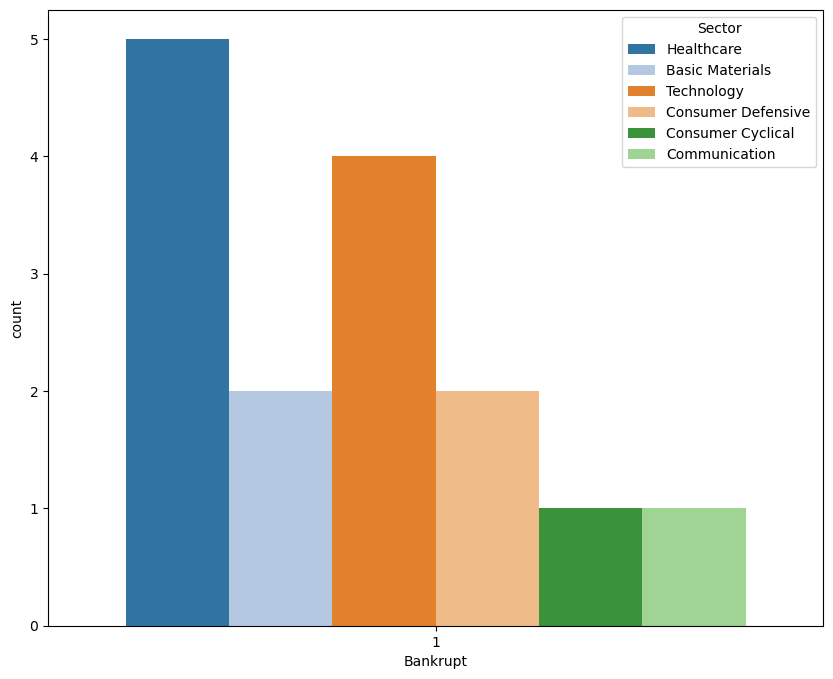

In [59]:
# Number of bankrupt companies by sector
all_data_bankrupt = all_data_trim[all_data_trim['Bankrupt']==1]
plt.figure(figsize=(10,8))
ax = sns.countplot(data=all_data_bankrupt, x='Bankrupt', hue='Sector', palette='tab20')

In [60]:
# Descriptive statistics of bankrupt companies
all_data_bankrupt.describe(include='all')

,index,symbol,year,Sector,Bankrupt,GDP_Growth,CPI_Yearly_Avg,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR
count,15.00,15,15.00,15,15.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00
unique,NaN,15,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,ABMC,NaN,Healthcare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,287.33,NaN,"2,022.20",NaN,1.00,2.35,5.61,1.26,0.76,1.26,-2.52,-11.94,-0.69,0.71,-5.21,-0.57,-0.24
std,157.71,NaN,0.56,NaN,0.00,1.03,0.84,0.88,0.78,0.68,12.53,27.44,1.17,5.52,7.41,0.92,0.71
min,3.00,NaN,"2,021.00",NaN,1.00,1.94,3.57,0.11,0.08,0.38,-38.00,-84.44,-4.58,-9.26,-21.00,-3.48,-2.23
25%,184.50,NaN,"2,022.00",NaN,1.00,1.94,4.77,0.63,0.22,0.90,-4.24,-7.22,-0.81,-1.14,-11.74,-0.70,-0.32
50%,312.00,NaN,"2,022.00",NaN,1.00,1.94,6.15,1.08,0.51,1.09,-2.01,-4.31,-0.37,0.31,-0.93,-0.28,0.04
75%,415.00,NaN,"2,022.50",NaN,1.00,2.50,6.15,1.76,0.89,1.74,1.00,-2.73,-0.13,1.19,-0.10,-0.11,0.23


In [61]:
# Calculate variances for bankrupt companies
print("Current Ratio Variance:", np.var(all_data_bankrupt['CR']))
print("Acid Test Ratio Variance:", np.var(all_data_bankrupt['ATR']))
print("Debt Ratio Variance:", np.var(all_data_bankrupt['DR']))
print("Debt-to-Equity Ratio Variance:", np.var(all_data_bankrupt['DTER']))
print("Interest Coverage Ratio Variance:", np.var(all_data_bankrupt['ICR']))
print("ROA Ratio Variance:", np.var(all_data_bankrupt['ROAR']))
print("ROE Ratio Variance:", np.var(all_data_bankrupt['ROER']))
print("EPS Ratio Variance:", np.var(all_data_bankrupt['EPS']))
print("ROTA Ratio Variance:", np.var(all_data_bankrupt['ROTAR']))
print("WC Ratio Variance:", np.var(all_data_bankrupt['WCR']))
print("GDP Variance:", np.var(all_data_bankrupt['GDP_Growth']))
print("CPI Variance:", np.var(all_data_bankrupt['CPI_Yearly_Avg']))

Current Ratio Variance: 0.7234068078753135
Acid Test Ratio Variance: 0.5694333209573608
Debt Ratio Variance: 0.4316447985326679
Debt-to-Equity Ratio Variance: 146.4900042721303
Interest Coverage Ratio Variance: 702.6656325328871
ROA Ratio Variance: 1.2745421082557553
ROE Ratio Variance: 28.41663672333276
EPS Ratio Variance: 51.2035860519546
ROTA Ratio Variance: 0.7852386584603842
WC Ratio Variance: 0.4672943015628194
GDP Variance: 0.9822878992061912
CPI Variance: 0.6564055555555554


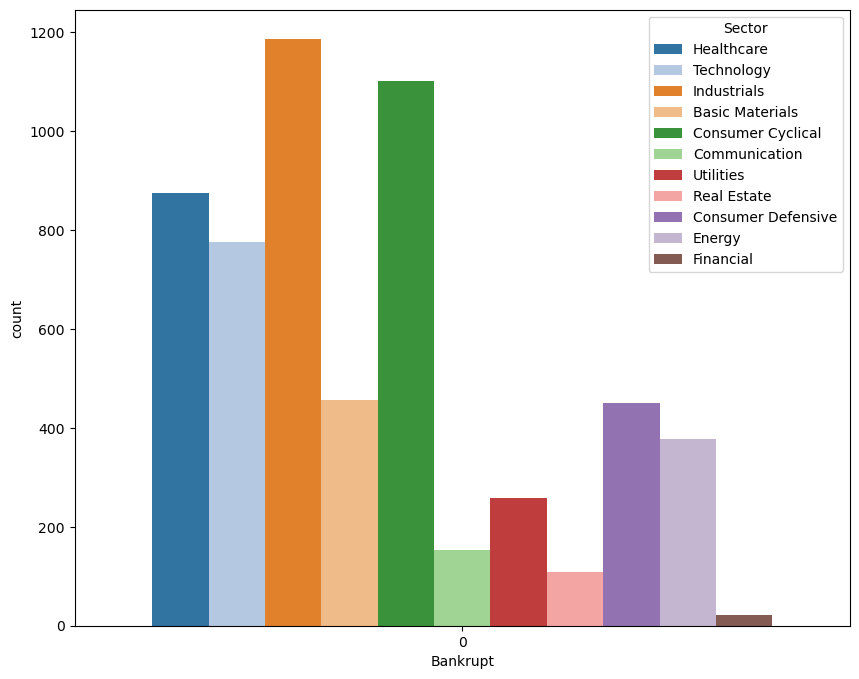

In [62]:
# Create data frame of non-bankrupt companies
all_data_alive = all_data_trim[all_data_trim['Bankrupt']==0]
plt.figure(figsize=(10,8))
ax = sns.countplot(data=all_data_alive, x='Bankrupt', hue='Sector', palette='tab20')

In [63]:
# Descriptive statistics of non-bankrupt companies
all_data_alive.describe(include='all')

,index,symbol,year,Sector,Bankrupt,GDP_Growth,CPI_Yearly_Avg,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR
count,"5,766.00",5766,"5,766.00",5766,"5,766.00","5,766.00","5,766.00","5,766.00","5,766.00","5,766.00","5,766.00","5,766.00","5,766.00","5,766.00","5,766.00","5,766.00","5,766.00"
unique,NaN,1602,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,MO,NaN,Industrials,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,7,NaN,1186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,"7,783.69",NaN,"2,021.50",NaN,0.00,2.00,4.07,2.39,1.79,0.73,-3.58,-26.35,-0.03,0.03,-1.55,0.00,0.10
std,"4,509.64",NaN,1.13,NaN,0.00,3.09,1.63,2.42,2.25,4.03,245.84,"2,639.66",1.19,24.29,146.24,0.92,3.74
min,0.00,NaN,"2,019.00",NaN,0.00,-2.77,1.70,0.00,-2.15,0.01,"-16,549.56","-176,158.00",-64.46,-982.00,"-8,928.60",-44.85,-235.06
25%,"3,893.25",NaN,"2,021.00",NaN,0.00,1.94,3.57,1.20,0.80,0.45,0.66,0.34,-0.01,-0.03,-0.31,0.00,0.04
50%,"7,871.00",NaN,"2,021.00",NaN,0.00,1.94,3.57,1.78,1.22,0.59,1.26,4.22,0.04,0.09,1.30,0.06,0.15
75%,"11,698.75",NaN,"2,022.00",NaN,0.00,5.95,6.15,2.74,1.92,0.74,2.41,12.78,0.08,0.21,4.05,0.11,0.30


In [64]:
# Calculate variances for non-bankrupt companies
print("Current Ratio Variance:", np.var(all_data_alive['CR']))
print("Acid Test Ratio Variance:", np.var(all_data_alive['ATR']))
print("Debt Ratio Variance:", np.var(all_data_alive['DR']))
print("Debt-to-Equity Ratio Variance:", np.var(all_data_alive['DTER']))
print("Interest Coverage Ratio Variance:", np.var(all_data_alive['ICR']))
print("ROA Ratio Variance:", np.var(all_data_alive['ROAR']))
print("ROE Ratio Variance:", np.var(all_data_alive['ROER']))
print("EPS Ratio Variance:", np.var(all_data_alive['EPS']))
print("ROTA Ratio Variance:", np.var(all_data_alive['ROTAR']))
print("WC Ratio Variance:", np.var(all_data_alive['WCR']))
print("GDP Variance:", np.var(all_data_alive['GDP_Growth']))
print("CPI Variance:", np.var(all_data_alive['CPI_Yearly_Avg']))

Current Ratio Variance: 5.848609360764287
Acid Test Ratio Variance: 5.062309684380579
Debt Ratio Variance: 16.267901210790445
Debt-to-Equity Ratio Variance: 60426.24005939443
Interest Coverage Ratio Variance: 6966594.293298707
ROA Ratio Variance: 1.4212498720941176
ROE Ratio Variance: 590.0491058148127
EPS Ratio Variance: 21382.880504084816
ROTA Ratio Variance: 0.8399084058955691
WC Ratio Variance: 13.968601257665378
GDP Variance: 9.539104011354215
CPI Variance: 2.6480100419611494


In [65]:
# Create dataframe for each variable for t-testing
current_ratio = all_data_trim[['CR', 'Bankrupt']].dropna(how='any')
acid_ratio = all_data_trim[['ATR', 'Bankrupt']].dropna(how='any')
debt_ratio = all_data_trim[['DR', 'Bankrupt']].dropna(how='any')
dte_ratio = all_data_trim[['DTER', 'Bankrupt']].dropna(how='any') 
icr_ratio = all_data_trim[['ICR', 'Bankrupt']].dropna(how='any')
roa_ratio = all_data_trim[['ROAR', 'Bankrupt']].dropna(how='any') 
roe_ratio = all_data_trim[['ROER', 'Bankrupt']].dropna(how='any') 
eps_ratio = all_data_trim[['EPS', 'Bankrupt']].dropna(how='any') 
rota_ratio = all_data_trim[['ROTAR', 'Bankrupt']].dropna(how='any')
wc_ratio = all_data_trim[['WCR', 'Bankrupt']].dropna(how='any') 
gdp_data = all_data_trim[['GDP_Growth', 'Bankrupt']].dropna(how='any') 
cpi_data = all_data_trim[['CPI_Yearly_Avg', 'Bankrupt']].dropna(how='any')

In [66]:
# Create two dataframes for each variable, bankrupt and non-bankrupt, to compare for t-tests
# Current Ratio
cr_bankrupt = current_ratio[current_ratio['Bankrupt'] == 1]
cr_alive = current_ratio[current_ratio['Bankrupt'] == 0]
# Acid-test Ratio
ar_bankrupt = acid_ratio[acid_ratio['Bankrupt'] == 1]
ar_alive = acid_ratio[acid_ratio['Bankrupt'] == 0]
# Debt Ratio
dr_bankrupt = debt_ratio[debt_ratio['Bankrupt'] == 1]
dr_alive = debt_ratio[debt_ratio['Bankrupt'] == 0]
# Debt-to-Equity Ratio
dte_bankrupt = dte_ratio[dte_ratio['Bankrupt'] == 1]
dte_alive = dte_ratio[dte_ratio['Bankrupt'] == 0]
# Interest Coverage Ratio
icr_bankrupt = icr_ratio[icr_ratio['Bankrupt'] == 1]
icr_alive = icr_ratio[icr_ratio['Bankrupt'] == 0]
# Return on Assets Ratio
roa_bankrupt = roa_ratio[roa_ratio['Bankrupt'] == 1]
roa_alive = roa_ratio[roa_ratio['Bankrupt'] == 0]
# Return on Equity Ratio
roe_bankrupt = roe_ratio[roe_ratio['Bankrupt'] == 1]
roe_alive = roe_ratio[roe_ratio['Bankrupt'] == 0]
# EPS Ratio
eps_bankrupt = eps_ratio[eps_ratio['Bankrupt'] == 1]
eps_alive = eps_ratio[eps_ratio['Bankrupt'] == 0]
# Return on Total Assets Ratio
rota_bankrupt = rota_ratio[rota_ratio['Bankrupt'] == 1]
rota_alive = rota_ratio[rota_ratio['Bankrupt'] == 0]
# Working Capital Ratio
wc_bankrupt = wc_ratio[wc_ratio['Bankrupt'] == 1]
wc_alive = wc_ratio[wc_ratio['Bankrupt'] == 0]
# GDP
gdp_bankrupt = gdp_data[gdp_data['Bankrupt'] == 1]
gdp_alive = gdp_data[gdp_data['Bankrupt'] == 0]
# CPI
cpi_bankrupt = cpi_data[cpi_data['Bankrupt'] == 1]
cpi_alive = cpi_data[cpi_data['Bankrupt'] == 0]

In [67]:
# Create dataframes to calculate differences in variances
# Current Ratio
comparison_cr_b = cr_bankrupt['CR']
comparison_cr_a = cr_alive['CR']
# Acid-test Ratio
comparison_ar_b = ar_bankrupt['ATR']
comparison_ar_a = ar_alive['ATR']
# Debt Ratio
comparison_dr_b = dr_bankrupt['DR']
comparison_dr_a = dr_alive['DR']
# Debt-to-Equity Ratio
comparison_dte_b = dte_bankrupt['DTER']
comparison_dte_a = dte_alive['DTER']
# Interest Coverage Ratio
comparison_icr_b = icr_bankrupt['ICR']
comparison_icr_a = icr_alive['ICR']
# Return on Assets Ratio
comparison_roa_b = roa_bankrupt['ROAR']
comparison_roa_a = roa_alive['ROAR']
# Return on Equity Ratio
comparison_roe_b = roe_bankrupt['ROER']
comparison_roe_a = roe_alive['ROER']
# EPS Ratio
comparison_eps_b = eps_bankrupt['EPS']
comparison_eps_a = eps_alive['EPS']
# Return on Total Assets Ratio
comparison_rota_b = rota_bankrupt['ROTAR']
comparison_rota_a = rota_alive['ROTAR']
# Working Capital Ratio
comparison_wc_b = wc_bankrupt['WCR']
comparison_wc_a = wc_alive['WCR']
# GDP
comparison_gdp_b = gdp_bankrupt['GDP_Growth']
comparison_gdp_a = gdp_alive['GDP_Growth']
# CPI
comparison_cpi_b = cpi_bankrupt['CPI_Yearly_Avg']
comparison_cpi_a = cpi_alive['CPI_Yearly_Avg']

In [68]:
# Calculate variances and variance ratio between bankrupt and alive companies
print("Current Ratio Variance:", np.var(comparison_cr_b), np.var(comparison_cr_a), (np.var(comparison_cr_a)/np.var(comparison_cr_b)))
print("Acid Test Ratio Variance:", np.var(comparison_ar_b), np.var(comparison_ar_a), (np.var(comparison_ar_a)/np.var(comparison_ar_b)))
print("Debt Ratio Variance:", np.var(comparison_dr_b), np.var(comparison_dr_a), (np.var(comparison_dr_a)/np.var(comparison_dr_b)))
print("Debt-to-Equity Ratio Variance:", np.var(comparison_dte_b), np.var(comparison_dte_a), (np.var(comparison_dte_a)/np.var(comparison_dte_b)))
print("Interest Coverage Ratio Variance:", np.var(comparison_icr_b), np.var(comparison_icr_a), (np.var(comparison_icr_a)/np.var(comparison_icr_b)))
print("ROA Ratio Variance:", np.var(comparison_roa_b), np.var(comparison_roa_a), (np.var(comparison_roa_a)/np.var(comparison_roa_b)))
print("ROE Ratio Variance:", np.var(comparison_roe_b), np.var(comparison_roe_a), (np.var(comparison_roe_a)/np.var(comparison_roe_b)))
print("EPS Ratio Variance:", np.var(comparison_eps_b), np.var(comparison_eps_a), (np.var(comparison_eps_a)/np.var(comparison_eps_b)))
print("ROTA Ratio Variance:", np.var(comparison_rota_b), np.var(comparison_rota_a), (np.var(comparison_rota_a)/np.var(comparison_rota_b)))
print("WC Ratio Variance:", np.var(comparison_wc_b), np.var(comparison_wc_a), (np.var(comparison_wc_a)/np.var(comparison_wc_b)))
print("GDP Variance:", np.var(comparison_gdp_b), np.var(comparison_gdp_a), (np.var(comparison_gdp_a)/np.var(comparison_gdp_b)))
print("CPI Variance:", np.var(comparison_cpi_b), np.var(comparison_cpi_a), (np.var(comparison_cpi_a)/np.var(comparison_cpi_b)))

Current Ratio Variance: 0.7234068078753135 5.848609360764287 8.084813824108155
Acid Test Ratio Variance: 0.5694333209573608 5.062309684380579 8.89008334789675
Debt Ratio Variance: 0.4316447985326679 16.267901210790445 37.688166905037434
Debt-to-Equity Ratio Variance: 146.4900042721303 60426.24005939443 412.4939470077585
Interest Coverage Ratio Variance: 702.6656325328871 6966594.293298707 9914.522599015325
ROA Ratio Variance: 1.2745421082557553 1.4212498720941176 1.1151062510120875
ROE Ratio Variance: 28.41663672333276 590.0491058148127 20.764213286730243
EPS Ratio Variance: 51.2035860519546 21382.880504084816 417.60513574944355
ROTA Ratio Variance: 0.7852386584603842 0.8399084058955691 1.069621823691635
WC Ratio Variance: 0.4672943015628194 13.968601257665378 29.892513585012225
GDP Variance: 0.9822878992061912 9.539104011354215 9.711108137505287
CPI Variance: 0.6564055555555554 2.6480100419611494 4.034106688387151


In [69]:
# Conduct normal t-test or Welch's t-Test depending on differences in variances. Large variances require Welch's.
# Null hypothesis is that the means between the two populations is equal and statistically insignificant
alpha = 0.05
# Current Ratio
t_stat_cr, p_value_cr = stats.ttest_ind(comparison_cr_b, comparison_cr_a, equal_var=False)
if p_value_cr < alpha:
    print("Reject null hypothesis for Current Ratio, p-value is:", p_value_cr)
else:
    print("Fail to reject null hypothesis for Current Ratio, p-value is:", p_value_cr)
# Acid Test Ratio
t_stat_ar, p_value_ar = stats.ttest_ind(comparison_ar_b, comparison_ar_a, equal_var=False)
if p_value_ar < alpha:
    print("Reject null hypothesis for Acid Test Ratio, p-value is:", p_value_ar)
else:
    print("Fail to reject null hypothesis for Acid Test Ratio, p-value is:", p_value_ar)
# Debt Ratio
t_stat_dr, p_value_dr = stats.ttest_ind(comparison_dr_b, comparison_dr_a, equal_var=False)
if p_value_dr < alpha:
    print("Reject null hypothesis for Debt Ratio, p-value is:", p_value_dr)
else:
    print("Fail to reject null hypothesis for Debt Ratio, p-value is:", p_value_dr)
# Debt-to-Equity Ratio
t_stat_dte, p_value_dte = stats.ttest_ind(comparison_dte_b, comparison_dte_a, equal_var=False)
if p_value_dte < alpha:
    print("Reject null hypothesis for Debt-to-Equity Ratio, p-value is:", p_value_dte)
else:
    print("Fail to reject null hypothesis for Debt-to-Equity Ratio, p-value is:", p_value_dte)
# Interest Coverage Ratio
t_stat_icr, p_value_icr = stats.ttest_ind(comparison_icr_b, comparison_icr_a, equal_var=False)
if p_value_icr < alpha:
    print("Reject null hypothesis for Interest Coverage Ratio, p-value is:", p_value_icr)
else:
    print("Fail to reject null hypothesis for Interest Coverage Ratio, p-value is:", p_value_icr)
# Return on Assets Ratio
t_stat_roa, p_value_roa = stats.ttest_ind(comparison_roa_b, comparison_roa_a, equal_var=True)
if p_value_roa < alpha:
    print("Reject null hypothesis for ROA Ratio, p-value is:", p_value_roa)
else:
    print("Fail to reject null hypothesis for ROA Ratio, p-value is:", p_value_roa)
# Return on Equity Ratio
t_stat_roe, p_value_roe = stats.ttest_ind(comparison_roe_b, comparison_roe_a, equal_var=False)
if p_value_roe < alpha:
    print("Reject null hypothesis for ROE Ratio, p-value is:", p_value_roe)
else:
    print("Fail to reject null hypothesis for ROE Ratio, p-value is:", p_value_roe)
# EPS Ratio
t_stat_eps, p_value_eps = stats.ttest_ind(comparison_eps_b, comparison_eps_a, equal_var=False)
if p_value_eps < alpha:
    print("Reject null hypothesis for EPS Ratio, p-value is:", p_value_eps)
else:
    print("Fail to reject null hypothesis for EPS Ratio, p-value is:", p_value_eps)
# Return on Total Assets Ratio
t_stat_rota, p_value_rota = stats.ttest_ind(comparison_rota_b, comparison_rota_a, equal_var=True)
if p_value_rota < alpha:
    print("Reject null hypothesis for ROTA Ratio, p-value is:", p_value_rota)
else:
    print("Fail to reject null hypothesis for ROTA Ratio, p-value is:", p_value_rota)
# Working Capital Ratio
t_stat_wc, p_value_wc = stats.ttest_ind(comparison_wc_b, comparison_wc_a, equal_var=False)
if p_value_wc < alpha:
    print("Reject null hypothesis for Working Capital Ratio, p-value is:", p_value_wc)
else:
    print("Fail to reject null hypothesis for Working Capital Ratio, p-value is:", p_value_wc)
# GDP
t_stat_gdp, p_value_gdp = stats.ttest_ind(comparison_gdp_b, comparison_gdp_a, equal_var=False)
if p_value_gdp < alpha:
    print("Reject null hypothesis for GDP, p-value is:", p_value_gdp)
else:
    print("Fail to reject null hypothesis for GDP, p-value is:", p_value_gdp)
# CPI
t_stat_cpi, p_value_cpi = stats.ttest_ind(comparison_cpi_b, comparison_cpi_a, equal_var=True)
if p_value_cpi < alpha:
    print("Reject null hypothesis for CPI, p-value is:", p_value_cpi)
else:
    print("Fail to reject null hypothesis for CPI, p-value is:", p_value_cpi)

Reject null hypothesis for Current Ratio, p-value is: 0.00020989654808674542
Reject null hypothesis for Acid Test Ratio, p-value is: 0.00015516922591691476
Reject null hypothesis for Debt Ratio, p-value is: 0.010843911654000907
Fail to reject null hypothesis for Debt-to-Equity Ratio, p-value is: 0.8179456996887596
Fail to reject null hypothesis for Interest Coverage Ratio, p-value is: 0.6846191575716813
Reject null hypothesis for ROA Ratio, p-value is: 0.03220668918305959
Fail to reject null hypothesis for ROE Ratio, p-value is: 0.6483838662567623
Fail to reject null hypothesis for EPS Ratio, p-value is: 0.18277902021242776
Reject null hypothesis for ROTA Ratio, p-value is: 0.01608279050314797
Fail to reject null hypothesis for Working Capital Ratio, p-value is: 0.09689518925412065
Fail to reject null hypothesis for GDP, p-value is: 0.21274886010992522
Reject null hypothesis for CPI, p-value is: 0.00023794908747338755


In [70]:
# ANOVA
print("Current Ratio ANOVA Results: ", f_oneway(comparison_cr_b, comparison_cr_a))
print("Acid-test ANOVA Results: ", f_oneway(comparison_ar_b, comparison_ar_a))
print("Debt Ratio ANOVA Results: ", f_oneway(comparison_dr_b, comparison_dr_a))
print("Debt-to-Equity ANOVA Results: ", f_oneway(comparison_dte_b, comparison_dte_a))
print("Interest Coverage ANOVA Results: ", f_oneway(comparison_icr_b, comparison_icr_a))
print("ROA ANOVA Results: ", f_oneway(comparison_roa_b, comparison_roa_a))
print("ROE ANOVA Results: ", f_oneway(comparison_roe_b, comparison_roe_a))
print("EPS ANOVA Results: ", f_oneway(comparison_eps_b, comparison_eps_a))
print("ROTA ANOVA Results: ", f_oneway(comparison_rota_b, comparison_rota_a))
print("Working Capital ANOVA Results: ", f_oneway(comparison_wc_b, comparison_wc_a))
print("GDP ANOVA Results: ", f_oneway(comparison_gdp_b, comparison_gdp_a))
print("CPI ANOVA Results: ", f_oneway(comparison_cpi_b, comparison_cpi_a))

Current Ratio ANOVA Results:  F_onewayResult(statistic=3.2412056479412823, pvalue=0.07185990435442684)
Acid-test ANOVA Results:  F_onewayResult(statistic=3.14011554134506, pvalue=0.07644107663445303)
Debt Ratio ANOVA Results:  F_onewayResult(statistic=0.2548886131363738, pvalue=0.6136729473911668)
Debt-to-Equity ANOVA Results:  F_onewayResult(statistic=0.00027800242529321743, pvalue=0.9866977397465931)
Interest Coverage ANOVA Results:  F_onewayResult(statistic=0.00044698757838347185, pvalue=0.9831330467018334)
ROA ANOVA Results:  F_onewayResult(statistic=4.589679531746261, pvalue=0.03220668918304167)
ROE ANOVA Results:  F_onewayResult(statistic=0.011716749243247384, pvalue=0.9138059532109502)
EPS ANOVA Results:  F_onewayResult(statistic=0.009397357442930765, pvalue=0.9227774297639736)
ROTA ANOVA Results:  F_onewayResult(statistic=5.797206830636286, pvalue=0.01608279050314168)
Working Capital ANOVA Results:  F_onewayResult(statistic=0.11941402350791985, pvalue=0.7296834770192228)
GDP AN

In [71]:
# Bankrupt only data frame for linear regression modeling
all_data_trim_bankruptcies = all_data_trim.merge(bankrupt_data_merged, on=['symbol', 'year'], how='inner')

all_data_trim_bankruptcies = all_data_trim_bankruptcies[variables +['symbol', 'year', 'Bankruptcy_Year']]

all_data_trim_bankruptcies

,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR,GDP_Growth,CPI_Yearly_Avg,symbol,year,Bankruptcy_Year
0,0.73,0.25,1.38,-3.63,-1.59,-0.33,0.86,-0.02,-0.20,-0.22,2.29,2.20,ABMC,2019,<NA>
1,0.58,0.32,1.65,-2.53,-3.54,-0.41,0.63,-0.02,-0.32,-0.44,-2.77,1.70,ABMC,2020,<NA>
2,0.46,0.31,1.50,-2.99,-1.38,-0.25,0.49,-0.01,-0.14,-0.81,5.95,3.57,ABMC,2021,<NA>
3,0.21,0.11,2.84,-1.54,-6.26,-1.11,0.60,-0.03,-0.96,-2.23,1.94,6.15,ABMC,2022,2022
4,1.61,1.40,0.62,1.66,-2.52,-0.16,-0.42,-246.40,-0.12,0.13,-2.77,1.70,ACORQ,2020,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,0.11,0.08,2.00,-2.04,-2.95,-4.58,4.66,-11.03,-3.48,-1.13,1.94,6.15,WINR,2022,2022
210,0.79,0.57,0.94,15.66,6.63,0.09,1.57,2.40,0.17,-0.04,-2.77,1.70,MO,2020,<NA>
211,0.71,0.57,1.04,-25.61,4.22,0.06,-1.54,1.36,0.13,-0.06,5.95,3.57,MO,2021,<NA>
212,0.84,0.70,1.11,-10.29,7.55,0.16,-1.45,3.23,0.23,-0.04,1.94,6.15,MO,2022,2022


In [72]:
# Determine year of bankruptcy
year = all_data_trim_bankruptcies.merge(bankruptcies_recent, left_on = 'symbol', right_on = 'Symbol', how='left')

years = year[variables + ['symbol', 'year', 'Bankruptcy_Year_y']]

years

,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR,GDP_Growth,CPI_Yearly_Avg,symbol,year,Bankruptcy_Year_y
0,0.73,0.25,1.38,-3.63,-1.59,-0.33,0.86,-0.02,-0.20,-0.22,2.29,2.20,ABMC,2019,2022
1,0.58,0.32,1.65,-2.53,-3.54,-0.41,0.63,-0.02,-0.32,-0.44,-2.77,1.70,ABMC,2020,2022
2,0.46,0.31,1.50,-2.99,-1.38,-0.25,0.49,-0.01,-0.14,-0.81,5.95,3.57,ABMC,2021,2022
3,0.21,0.11,2.84,-1.54,-6.26,-1.11,0.60,-0.03,-0.96,-2.23,1.94,6.15,ABMC,2022,2022
4,1.61,1.40,0.62,1.66,-2.52,-0.16,-0.42,-246.40,-0.12,0.13,-2.77,1.70,ACORQ,2020,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,0.11,0.08,2.00,-2.04,-2.95,-4.58,4.66,-11.03,-3.48,-1.13,1.94,6.15,WINR,2022,2022
210,0.79,0.57,0.94,15.66,6.63,0.09,1.57,2.40,0.17,-0.04,-2.77,1.70,MO,2020,2022
211,0.71,0.57,1.04,-25.61,4.22,0.06,-1.54,1.36,0.13,-0.06,5.95,3.57,MO,2021,2022
212,0.84,0.70,1.11,-10.29,7.55,0.16,-1.45,3.23,0.23,-0.04,1.94,6.15,MO,2022,2022


In [73]:
# Drop rows where financial reporting year is after bankruptcy filing year
bankruptcies_clean = years.drop(years[years['year'] > years['Bankruptcy_Year_y']].index)

bankruptcies_clean

,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR,GDP_Growth,CPI_Yearly_Avg,symbol,year,Bankruptcy_Year_y
0,0.73,0.25,1.38,-3.63,-1.59,-0.33,0.86,-0.02,-0.20,-0.22,2.29,2.20,ABMC,2019,2022
1,0.58,0.32,1.65,-2.53,-3.54,-0.41,0.63,-0.02,-0.32,-0.44,-2.77,1.70,ABMC,2020,2022
2,0.46,0.31,1.50,-2.99,-1.38,-0.25,0.49,-0.01,-0.14,-0.81,5.95,3.57,ABMC,2021,2022
3,0.21,0.11,2.84,-1.54,-6.26,-1.11,0.60,-0.03,-0.96,-2.23,1.94,6.15,ABMC,2022,2022
4,1.61,1.40,0.62,1.66,-2.52,-0.16,-0.42,-246.40,-0.12,0.13,-2.77,1.70,ACORQ,2020,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,0.20,0.15,0.55,1.27,-3.43,-0.60,-1.38,-4.91,-0.47,-0.33,5.95,3.57,WINR,2021,2022
209,0.11,0.08,2.00,-2.04,-2.95,-4.58,4.66,-11.03,-3.48,-1.13,1.94,6.15,WINR,2022,2022
210,0.79,0.57,0.94,15.66,6.63,0.09,1.57,2.40,0.17,-0.04,-2.77,1.70,MO,2020,2022
211,0.71,0.57,1.04,-25.61,4.22,0.06,-1.54,1.36,0.13,-0.06,5.95,3.57,MO,2021,2022


In [74]:
# Calculate slope for each variable
cr_slope_b = bankruptcies_clean.groupby(['symbol']).apply(lambda v: linregress(v.year, v.CR)[0])
atr_slope_b = bankruptcies_clean.groupby(['symbol']).apply(lambda v: linregress(v.year, v.ATR)[0])
dr_slope_b = bankruptcies_clean.groupby(['symbol']).apply(lambda v: linregress(v.year, v.DR)[0])
dter_slope_b = bankruptcies_clean.groupby(['symbol']).apply(lambda v: linregress(v.year, v.DTER)[0])
icr_slope_b = bankruptcies_clean.groupby(['symbol']).apply(lambda v: linregress(v.year, v.ICR)[0])
roar_slope_b = bankruptcies_clean.groupby(['symbol']).apply(lambda v: linregress(v.year, v.ROAR)[0])
roer_slope_b = bankruptcies_clean.groupby(['symbol']).apply(lambda v: linregress(v.year, v.ROER)[0])
eps_slope_b = bankruptcies_clean.groupby(['symbol']).apply(lambda v: linregress(v.year, v.EPS)[0])
rotar_slope_b = bankruptcies_clean.groupby(['symbol']).apply(lambda v: linregress(v.year, v.ROTAR)[0])
wcr_slope_b = bankruptcies_clean.groupby(['symbol']).apply(lambda v: linregress(v.year, v.WCR)[0])
gdp_slope_b = bankruptcies_clean.groupby(['symbol']).apply(lambda v: linregress(v.year, v.GDP_Growth)[0])
cpi_slope_b = bankruptcies_clean.groupby(['symbol']).apply(lambda v: linregress(v.year, v.CPI_Yearly_Avg)[0])

C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\2656444018.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cr_slope_b = bankruptcies_clean

In [75]:
# Create dataframe to display slope vlaues
cr_slope_b_df = pd.DataFrame(cr_slope_b, columns = ['cr_slope']).dropna(how='any')
cr_slope_b_s = cr_slope_b_df.iloc[:,0]
atr_slope_b_df = pd.DataFrame(atr_slope_b, columns = ['atr_slope']).dropna(how='any')
atr_slope_b_s = atr_slope_b_df.iloc[:,0]
dr_slope_b_df = pd.DataFrame(dr_slope_b, columns = ['dr_slope']).dropna(how='any')
dr_slope_b_s = dr_slope_b_df.iloc[:,0]
dter_slope_b_df = pd.DataFrame(dter_slope_b, columns = ['dter_slope']).dropna(how='any')
dter_slope_b_s = dter_slope_b_df.iloc[:,0]
icr_slope_b_df = pd.DataFrame(icr_slope_b, columns = ['icr_slope']).dropna(how='any')
icr_slope_b_s = icr_slope_b_df.iloc[:,0]
roar_slope_b_df = pd.DataFrame(roar_slope_b, columns = ['roar_slope']).dropna(how='any')
roar_slope_b_s = roar_slope_b_df.iloc[:,0]
roer_slope_b_df = pd.DataFrame(roer_slope_b, columns = ['roer_slope']).dropna(how='any')
roer_slope_b_s = roer_slope_b_df.iloc[:,0]
eps_slope_b_df = pd.DataFrame(eps_slope_b, columns = ['eps_slope']).dropna(how='any')
eps_slope_b_s = eps_slope_b_df.iloc[:,0]
rotar_slope_b_df = pd.DataFrame(rotar_slope_b, columns = ['rotar_slope']).dropna(how='any')
rotar_slope_b_s = rotar_slope_b_df.iloc[:,0]
wcr_slope_b_df = pd.DataFrame(wcr_slope_b, columns = ['wcr_slope']).dropna(how='any')
wcr_slope_b_s = wcr_slope_b_df.iloc[:,0]
gdp_slope_b_df = pd.DataFrame(gdp_slope_b, columns = ['gdp_slope']).dropna(how='any')
gdp_slope_b_s = gdp_slope_b_df.iloc[:,0]
cpi_slope_b_df = pd.DataFrame(cpi_slope_b, columns = ['cpi_slope']).dropna(how='any')
cpi_slope_b_s = cpi_slope_b_df.iloc[:,0]

In [76]:
# Bankrupt slope dataframe
bdfs = [cr_slope_b_df, atr_slope_b_df, dr_slope_b_df, dter_slope_b_df,
icr_slope_b_df, roar_slope_b_df, roer_slope_b_df, eps_slope_b_df, rotar_slope_b_df,
wcr_slope_b_df, gdp_slope_b_df, cpi_slope_b_df]

In [77]:
# Descriptive statistics of bankrupt slope dataframe
bankrupt_slopes = pd.concat(bdfs, axis='columns')

bankrupt_slopes.describe()

,cr_slope,atr_slope,dr_slope,dter_slope,icr_slope,roar_slope,roer_slope,eps_slope,rotar_slope,wcr_slope,gdp_slope,cpi_slope
count,62.00,62.00,62.00,62.00,62.00,62.00,62.00,62.00,62.00,62.00,62.00,62.00
mean,-0.20,-0.20,1.11,-2.59,65.85,-0.31,0.81,161.32,-0.24,-1.20,1.65,1.56
std,1.60,1.59,9.23,13.05,753.77,1.53,5.69,873.93,1.03,8.78,3.02,0.71
min,-9.97,-9.98,-2.52,-91.26,"-2,300.53",-10.89,-8.94,-75.56,-6.54,-69.20,-5.06,-0.50
25%,-0.36,-0.33,-0.07,-1.04,-4.27,-0.26,-0.69,-0.79,-0.22,-0.12,0.76,1.18
50%,-0.06,-0.12,0.04,0.02,0.02,-0.01,-0.05,0.00,-0.03,-0.02,1.50,1.37
75%,0.18,0.14,0.20,1.30,6.41,0.08,0.60,2.95,0.05,0.03,2.35,2.22
max,6.26,6.37,72.41,8.67,"4,715.67",1.96,37.86,"5,353.64",1.95,0.44,8.71,2.57


In [78]:
# Create non-bankrupt dataframe
all_data_trim_alive = all_data_trim.merge(bankrupt_data_merged, on=['symbol', 'year'], how='outer', indicator=True).query("_merge != 'both'").drop('_merge', axis=1).reset_index(drop=True)

all_data_trim_alive = all_data_trim_alive[variables +['symbol', 'year']]

all_data_trim_alive

,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR,GDP_Growth,CPI_Yearly_Avg,symbol,year
0,2.33,1.84,0.49,0.98,11.79,0.07,0.15,2.33,0.10,0.20,-2.77,1.70,A,2020
1,2.22,1.74,0.50,0.99,17.79,0.11,0.22,3.98,0.13,0.20,5.95,3.57,A,2021
2,2.03,1.47,0.50,0.99,18.90,0.12,0.24,4.19,0.15,0.18,1.94,6.15,A,2022
3,2.61,1.97,0.46,0.84,15.09,0.12,0.21,4.22,0.13,0.24,2.50,4.77,A,2023
4,1.64,1.13,0.66,2.97,2.18,-0.01,-0.05,-0.91,0.02,0.12,-2.77,1.70,AA,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5854,3.02,1.77,0.40,0.66,4.81,0.04,0.07,0.65,0.07,0.17,2.50,4.77,ZWS,2023
5855,6.23,5.38,0.21,0.27,535.37,0.13,0.16,0.24,0.14,0.73,-2.77,1.70,ZYXI,2020
5856,3.62,3.15,0.45,0.80,235.43,0.13,0.23,0.45,0.17,0.45,5.95,3.57,ZYXI,2021
5857,3.30,2.66,0.43,0.76,51.45,0.15,0.26,0.44,0.19,0.42,1.94,6.15,ZYXI,2022


In [79]:
# Calculate slopes of variables on non-bankrupt companies
cr_slope = all_data_trim_alive.groupby(['symbol']).apply(lambda v: linregress(v.year, v.CR)[0])
atr_slope = all_data_trim_alive.groupby(['symbol']).apply(lambda v: linregress(v.year, v.ATR)[0])
dr_slope = all_data_trim_alive.groupby(['symbol']).apply(lambda v: linregress(v.year, v.DR)[0])
dter_slope = all_data_trim_alive.groupby(['symbol']).apply(lambda v: linregress(v.year, v.DTER)[0])
icr_slope = all_data_trim_alive.groupby(['symbol']).apply(lambda v: linregress(v.year, v.ICR)[0])
roar_slope = all_data_trim_alive.groupby(['symbol']).apply(lambda v: linregress(v.year, v.ROAR)[0])
roer_slope = all_data_trim_alive.groupby(['symbol']).apply(lambda v: linregress(v.year, v.ROER)[0])
eps_slope = all_data_trim_alive.groupby(['symbol']).apply(lambda v: linregress(v.year, v.EPS)[0])
rotar_slope = all_data_trim_alive.groupby(['symbol']).apply(lambda v: linregress(v.year, v.ROTAR)[0])
wcr_slope = all_data_trim_alive.groupby(['symbol']).apply(lambda v: linregress(v.year, v.WCR)[0])
gdp_slope = all_data_trim_alive.groupby(['symbol']).apply(lambda v: linregress(v.year, v.GDP_Growth)[0])
cpi_slope = all_data_trim_alive.groupby(['symbol']).apply(lambda v: linregress(v.year, v.CPI_Yearly_Avg)[0])

C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\3027690640.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cr_slope = all_data_trim_alive.

In [80]:
# Create dataframes of slopes
cr_slope_df = pd.DataFrame(cr_slope, columns = ['cr_slope']).dropna(how='any')
cr_slope_s = cr_slope_df.iloc[:,0]
atr_slope_df = pd.DataFrame(atr_slope, columns = ['atr_slope']).dropna(how='any')
atr_slope_s = atr_slope_df.iloc[:,0]
dr_slope_df = pd.DataFrame(dr_slope, columns = ['dr_slope']).dropna(how='any')
dr_slope_s = dr_slope_df.iloc[:,0]
dter_slope_df = pd.DataFrame(dter_slope, columns = ['dter_slope']).dropna(how='any')
dter_slope_s = dter_slope_df.iloc[:,0]
icr_slope_df = pd.DataFrame(icr_slope, columns = ['icr_slope']).dropna(how='any')
icr_slope_s = icr_slope_df.iloc[:,0]
roar_slope_df = pd.DataFrame(roar_slope, columns = ['roar_slope']).dropna(how='any')
roar_slope_s = roar_slope_df.iloc[:,0]
roer_slope_df = pd.DataFrame(roer_slope, columns = ['roer_slope']).dropna(how='any')
roer_slope_s = roer_slope_df.iloc[:,0]
eps_slope_df = pd.DataFrame(eps_slope, columns = ['eps_slope']).dropna(how='any')
eps_slope_s = eps_slope_df.iloc[:,0]
rotar_slope_df = pd.DataFrame(rotar_slope, columns = ['rotar_slope']).dropna(how='any')
rotar_slope_s = rotar_slope_df.iloc[:,0]
wcr_slope_df = pd.DataFrame(wcr_slope, columns = ['wcr_slope']).dropna(how='any')
wcr_slope_s = wcr_slope_df.iloc[:,0]
gdp_slope_df = pd.DataFrame(gdp_slope, columns = ['gdp_slope']).dropna(how='any')
gdp_slope_s = gdp_slope_df.iloc[:,0]
cpi_slope_df = pd.DataFrame(cpi_slope, columns = ['cpi_slope']).dropna(how='any')
cpi_slope_s = cpi_slope_df.iloc[:,0]

In [81]:
# Combine dataframes into one slope dataframe for non-bankrupt companies
adfs = [cr_slope_df, atr_slope_df, dr_slope_df, dter_slope_df,
icr_slope_df, roar_slope_df, roer_slope_df, eps_slope_df, rotar_slope_df,
wcr_slope_df, gdp_slope_df, cpi_slope_df]

In [82]:
# Descriptive statistics of slope dataframe of non-bankrupt companies
alive_slopes = pd.concat(adfs, axis='columns')

alive_slopes.describe()

,cr_slope,atr_slope,dr_slope,dter_slope,icr_slope,roar_slope,roer_slope,eps_slope,rotar_slope,wcr_slope,gdp_slope,cpi_slope
count,"1,487.00","1,487.00","1,487.00","1,487.00","1,487.00","1,487.00","1,487.00","1,487.00","1,487.00","1,487.00","1,487.00","1,487.00"
mean,-0.06,-0.09,-0.04,4.60,-114.59,0.01,-0.76,0.79,0.01,-0.00,1.07,1.20
std,1.15,1.14,0.63,219.69,"4,665.39",0.09,19.17,18.57,0.10,0.10,1.56,0.61
min,-22.49,-23.03,-23.34,"-1,416.89","-175,831.71",-1.13,-644.65,-549.49,-1.24,-0.56,-4.01,-1.38
25%,-0.16,-0.18,-0.03,-0.21,-1.43,-0.01,-0.03,-0.14,-0.01,-0.02,1.18,1.18
50%,-0.02,-0.04,-0.01,-0.03,0.41,0.00,0.01,0.32,0.01,-0.00,1.18,1.18
75%,0.10,0.05,0.02,0.12,3.07,0.03,0.07,1.26,0.03,0.01,1.18,1.18
max,18.32,17.95,0.56,"8,277.13","26,889.83",1.06,37.10,373.09,1.05,2.18,8.71,2.57


In [83]:
# Compute variances in slopes between bankrupt and non-bankrupt companies
print("Current Ratio Slope Variance:", np.var(cr_slope_s), np.var(cr_slope_b_s), (np.var(cr_slope_b_s)/np.var(cr_slope_s)))
print("Acid Test Ratio Slope Variance:", np.var(atr_slope_b_s), np.var(atr_slope_s), (np.var(atr_slope_b_s)/np.var(atr_slope_s)))
print("Debt Ratio Slope Variance:", np.var(dr_slope_b_s), np.var(dr_slope_s), (np.var(dr_slope_b_s)/np.var(dr_slope_s)))
print("Debt-to-Equity Ratio Slope Variance:", np.var(dter_slope_b_s), np.var(dter_slope_s), (np.var(dter_slope_s)/np.var(dter_slope_b_s)))
print("Interest Coverage Ratio Slope Variance:", np.var(icr_slope_b_s), np.var(icr_slope_s), (np.var(icr_slope_s)/np.var(icr_slope_b_s)))
print("ROA Ratio Slope Variance:", np.var(roar_slope_b_s), np.var(roar_slope_s), (np.var(roar_slope_b_s)/np.var(roar_slope_s)))
print("ROE Ratio Slope Variance:", np.var(roer_slope_b_s), np.var(roer_slope_s), (np.var(roer_slope_s)/np.var(roer_slope_b_s)))
print("EPS Ratio Slope Variance:", np.var(eps_slope_b_s), np.var(eps_slope_s), (np.var(eps_slope_b_s)/np.var(eps_slope_s)))
print("ROTA Ratio Slope Variance:", np.var(rotar_slope_b_s), np.var(rotar_slope_s), (np.var(rotar_slope_b_s)/np.var(rotar_slope_s)))
print("WC Ratio Slope Variance:", np.var(wcr_slope_b_s), np.var(wcr_slope_s), (np.var(wcr_slope_b_s)/np.var(wcr_slope_s)))
print("GDP Slope Variance:", np.var(gdp_slope_b_s), np.var(gdp_slope_s), (np.var(gdp_slope_b_s)/np.var(gdp_slope_s)))
print("CPI Slope Variance:", np.var(cpi_slope_b_s), np.var(cpi_slope_s), (np.var(cpi_slope_b_s)/np.var(cpi_slope_s)))

Current Ratio Slope Variance: 1.3311329589485617 2.5280377203654654 1.8991624415658055
Acid Test Ratio Slope Variance: 2.490659419622223 1.289960902720344 1.930802254835613
Debt Ratio Slope Variance: 83.76846509293581 0.39496361026372445 212.09160265929833
Debt-to-Equity Ratio Slope Variance: 167.52097017176877 48229.55653686237 287.90160710870924
Interest Coverage Ratio Slope Variance: 559010.9896960438 21751247.4868633 38.91023233494982
ROA Ratio Slope Variance: 2.3053635211940513 0.009007764312833568 255.93071056594445
ROE Ratio Slope Variance: 31.888497517506757 367.2132996083355 11.515540969176604
EPS Ratio Slope Variance: 751428.2471628803 344.77602244710306 2179.467823282773
ROTA Ratio Slope Variance: 1.0539088068650357 0.009860428527949949 106.88265767331217
WC Ratio Slope Variance: 75.8887037851391 0.010108850987598741 7507.154262956024
GDP Slope Variance: 8.989897991997063 2.4331434223138184 3.694766987244855
CPI Slope Variance: 0.4947226646615981 0.3711448701404175 1.3329637

In [84]:
# Conduct normal and Welch's t-Test due to differences in variances
# Null hypothesis is that the means between the two populations is equal and statistically insignificant
alpha = 0.05
# Current Ratio
t_stat_crs, p_value_crs = stats.ttest_ind(cr_slope_b_s, cr_slope_s, equal_var=True)
if p_value_crs < alpha:
    print("Reject null hypothesis for Current Ratio Slope, p-value is:", p_value_crs)
else:
    print("Fail to reject null hypothesis for Current Ratio Slope, p-value is:", p_value_crs)
# Acid Test Ratio
t_stat_ars, p_value_ars = stats.ttest_ind(atr_slope_b_s, atr_slope_s, equal_var=True)
if p_value_ars < alpha:
    print("Reject null hypothesis for Acid Test Ratio Slope, p-value is:", p_value_ars)
else:
    print("Fail to reject null hypothesis for Acid Test Ratio Slope, p-value is:", p_value_ars)
# Debt Ratio
t_stat_drs, p_value_drs = stats.ttest_ind(dr_slope_b_s, dr_slope_s, equal_var=False)
if p_value_drs < alpha:
    print("Reject null hypothesis for Debt Ratio Slope, p-value is:", p_value_drs)
else:
    print("Fail to reject null hypothesis for Debt Ratio Slope, p-value is:", p_value_drs)
# Debt-to-Equity Ratio
t_stat_dtes, p_value_dtes = stats.ttest_ind(dter_slope_b_s, dter_slope_s, equal_var=False)
if p_value_dtes < alpha:
    print("Reject null hypothesis for Debt-to-Equity Ratio Slope, p-value is:", p_value_dtes)
else:
    print("Fail to reject null hypothesis for Debt-to-Equity Ratio Slope, p-value is:", p_value_dtes)
# Interest Coverage Ratio
t_stat_icrs, p_value_icrs = stats.ttest_ind(icr_slope_b_s, icr_slope_s, equal_var=False)
if p_value_icrs < alpha:
    print("Reject null hypothesis for Interest Coverage Ratio Slope, p-value is:", p_value_icrs)
else:
    print("Fail to reject null hypothesis for Interest Coverage Ratio Slope, p-value is:", p_value_icrs)
# Return on Assets Ratio
t_stat_roas, p_value_roas = stats.ttest_ind(roar_slope_b_s, roar_slope_s, equal_var=False)
if p_value_roas < alpha:
    print("Reject null hypothesis for ROA Ratio Slope, p-value is:", p_value_roas)
else:
    print("Fail to reject null hypothesis for ROA Ratio Slope, p-value is:", p_value_roas)
# Return on Equity Ratio
t_stat_roes, p_value_roes = stats.ttest_ind(roer_slope_b_s, roer_slope_s, equal_var=False)
if p_value_roes < alpha:
    print("Reject null hypothesis for ROE Ratio Slope, p-value is:", p_value_roes)
else:
    print("Fail to reject null hypothesis for ROE Ratio Slope, p-value is:", p_value_roes)
# EPS Ratio
t_stat_epss, p_value_epss = stats.ttest_ind(eps_slope_b_s, eps_slope_s, equal_var=False)
if p_value_epss < alpha:
    print("Reject null hypothesis for EPS Ratio Slope, p-value is:", p_value_epss)
else:
    print("Fail to reject null hypothesis for EPS Ratio Slope, p-value is:", p_value_epss)
# Return on Total Assets Ratio
t_stat_rotas, p_value_rotas = stats.ttest_ind(rotar_slope_b_s, rotar_slope_s, equal_var=False)
if p_value_rotas < alpha:
    print("Reject null hypothesis for ROTA Ratio Slope, p-value is:", p_value_rotas)
else:
    print("Fail to reject null hypothesis for ROTA Ratio Slope, p-value is:", p_value_rotas)
# Working Capital Ratio
t_stat_wcs, p_value_wcs = stats.ttest_ind(wcr_slope_b_s, wcr_slope_s, equal_var=False)
if p_value_wcs < alpha:
    print("Reject null hypothesis for Working Capital Ratio Slope, p-value is:", p_value_wcs)
else:
    print("Fail to reject null hypothesis for Working Capital Ratio Slope, p-value is:", p_value_wcs)
# GDP
t_stat_gdps, p_value_gdps = stats.ttest_ind(gdp_slope_b_s, gdp_slope_s)
if p_value_gdps < alpha:
    print("Reject null hypothesis for GDP Slope, p-value is:", p_value_gdps)
else:
    print("Fail to reject null hypothesis for GDP Slope, p-value is:", p_value_gdps)
# CPI
t_stat_cpis, p_value_cpis = stats.ttest_ind(cpi_slope_b_s, cpi_slope_s)
if p_value_cpis < alpha:
    print("Reject null hypothesis for CPI Slope, p-value is:", p_value_cpis)
else:
    print("Fail to reject null hypothesis for CPI Slope, p-value is:", p_value_cpis)

Fail to reject null hypothesis for Current Ratio Slope, p-value is: 0.34879713262991985
Fail to reject null hypothesis for Acid Test Ratio Slope, p-value is: 0.4659519893196038
Fail to reject null hypothesis for Debt Ratio Slope, p-value is: 0.32961871156753364
Fail to reject null hypothesis for Debt-to-Equity Ratio Slope, p-value is: 0.22576892896192774
Fail to reject null hypothesis for Interest Coverage Ratio Slope, p-value is: 0.24293702743368992
Fail to reject null hypothesis for ROA Ratio Slope, p-value is: 0.10313444807644827
Fail to reject null hypothesis for ROE Ratio Slope, p-value is: 0.0768838188248255
Fail to reject null hypothesis for EPS Ratio Slope, p-value is: 0.15320527833675726
Fail to reject null hypothesis for ROTA Ratio Slope, p-value is: 0.058072034106807016
Fail to reject null hypothesis for Working Capital Ratio Slope, p-value is: 0.28686076218653334
Reject null hypothesis for GDP Slope, p-value is: 0.006325579163503175
Reject null hypothesis for CPI Slope, p-v

In [85]:
# ANOVA
print("Current Ratio ANOVA Results: ", f_oneway(cr_slope_b_s, cr_slope_s))
print("Acid-test ANOVA Results: ", f_oneway(atr_slope_b_s, atr_slope_s))
print("Debt Ratio ANOVA Results: ", f_oneway(dr_slope_b_s, dr_slope_s))
print("Debt-to-Equity ANOVA Results: ", f_oneway(dter_slope_b_s, dter_slope_s))
print("Interest Coverage ANOVA Results: ", f_oneway(icr_slope_b_s, icr_slope_s))
print("ROA ANOVA Results: ", f_oneway(roar_slope_b_s, roar_slope_s))
print("ROE ANOVA Results: ", f_oneway(roer_slope_b_s, roer_slope_s))
print("EPS ANOVA Results: ", f_oneway(eps_slope_b_s, eps_slope_s))
print("ROTA ANOVA Results: ", f_oneway(rotar_slope_b_s, rotar_slope_s))
print("Working Capital ANOVA Results: ", f_oneway(wcr_slope_b_s, wcr_slope_s))
print("GDP ANOVA Results: ", f_oneway(gdp_slope_b_s, gdp_slope_s))
print("CPI ANOVA Results: ", f_oneway(cpi_slope_b_s, cpi_slope_s))

Current Ratio ANOVA Results:  F_onewayResult(statistic=0.8783614941420587, pvalue=0.34879713262952694)
Acid-test ANOVA Results:  F_onewayResult(statistic=0.5318226262797979, pvalue=0.4659519893193377)
Debt Ratio ANOVA Results:  F_onewayResult(statistic=21.127525916134907, pvalue=4.646405712209907e-06)
Debt-to-Equity ANOVA Results:  F_onewayResult(statistic=0.06636044848681702, pvalue=0.7967458631209795)
Interest Coverage ANOVA Results:  F_onewayResult(statistic=0.09257874251624151, pvalue=0.7609649865746279)
ROA ANOVA Results:  F_onewayResult(statistic=60.952227101248035, pvalue=1.070047785048264e-14)
ROE ANOVA Results:  F_onewayResult(statistic=0.41125988355824816, pvalue=0.5214257250086116)
EPS ANOVA Results:  F_onewayResult(statistic=50.373945738426144, pvalue=1.9286771547089015e-12)
ROTA ANOVA Results:  F_onewayResult(statistic=74.20570449481218, pvalue=1.7066086068543677e-17)
Working Capital ANOVA Results:  F_onewayResult(statistic=28.01528345976536, pvalue=1.3764378306433559e-07)

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numerical_variables =  all_data_trim.select_dtypes(exclude=[np.object])
C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119

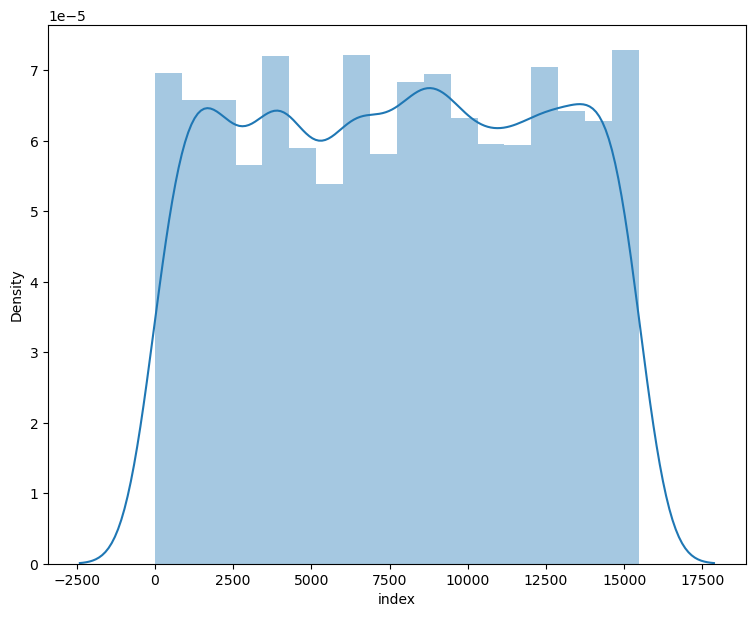

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


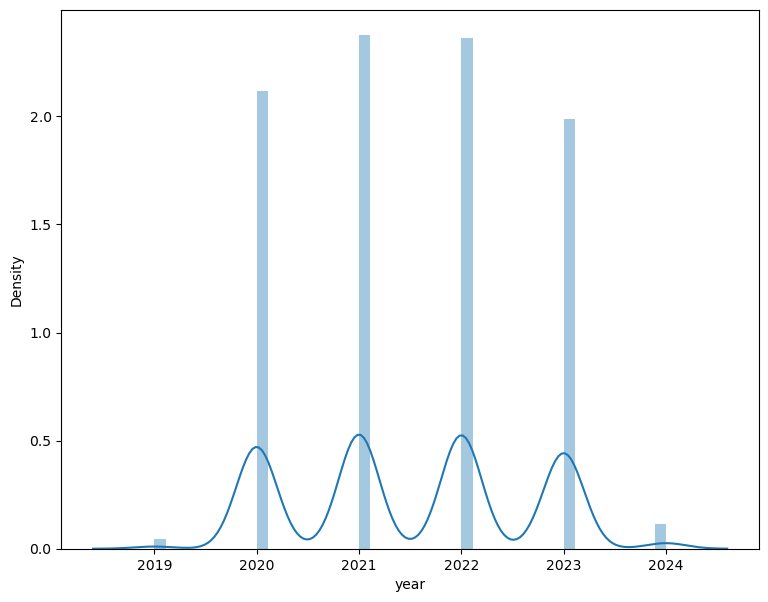

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


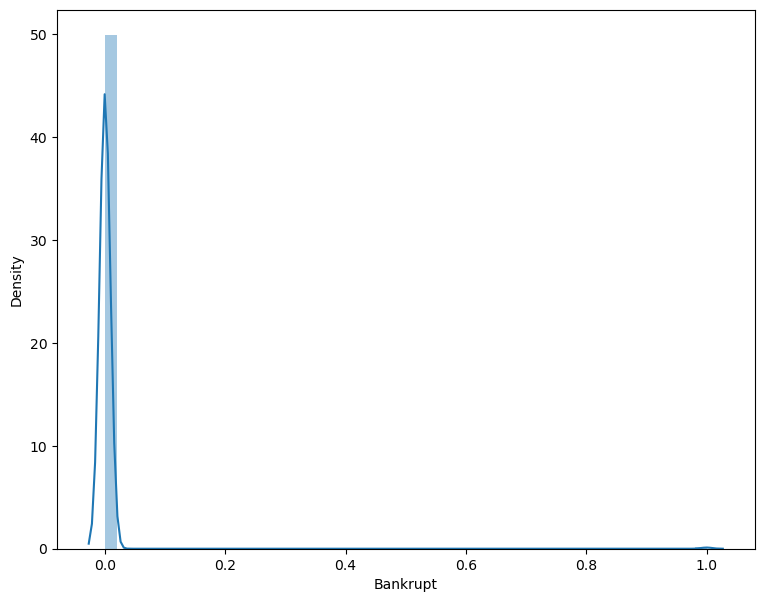

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


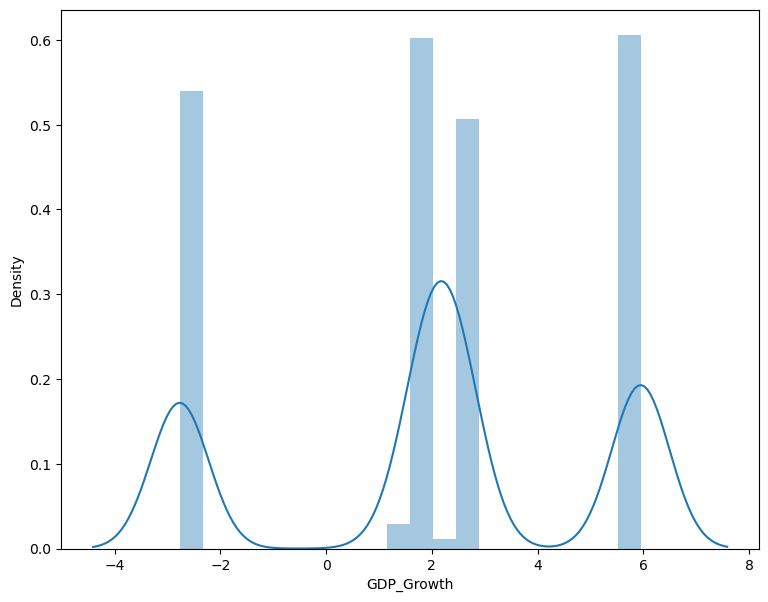

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


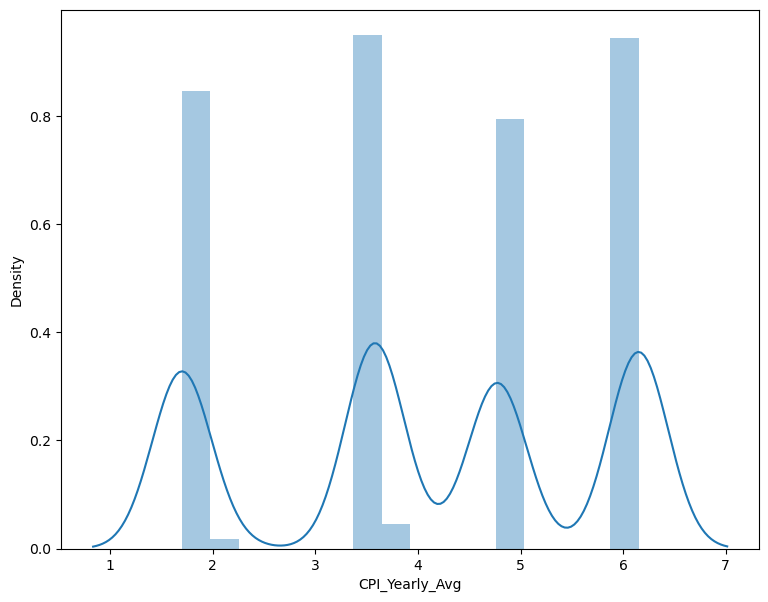

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


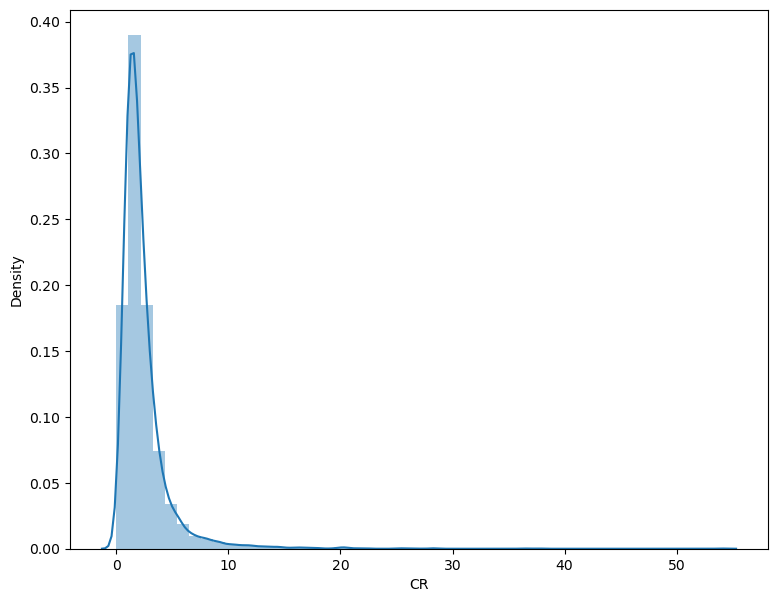

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


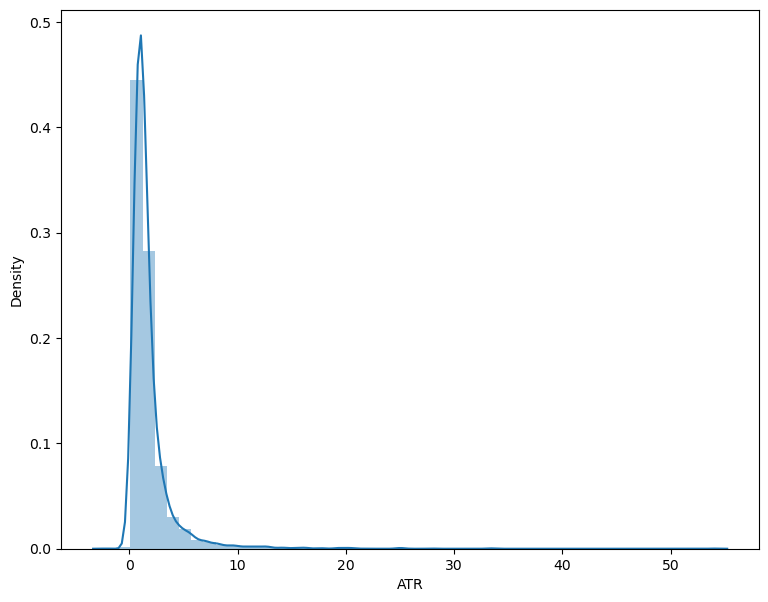

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


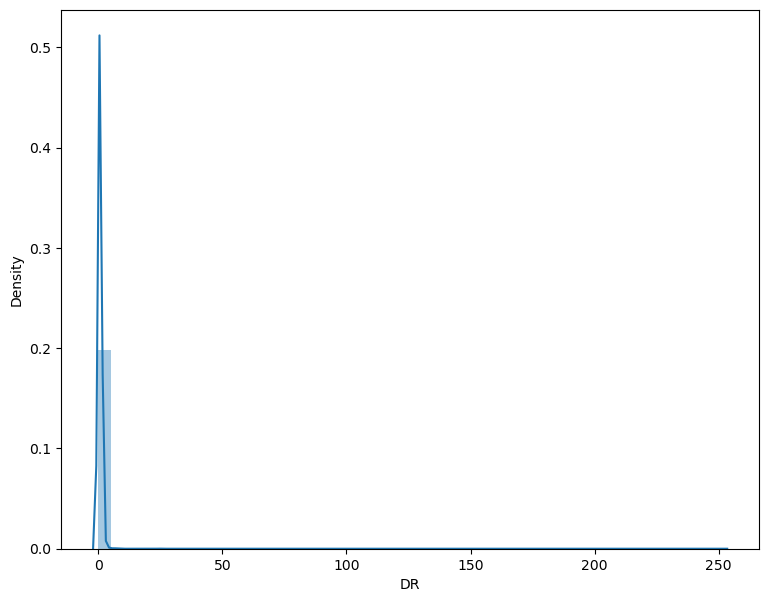

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


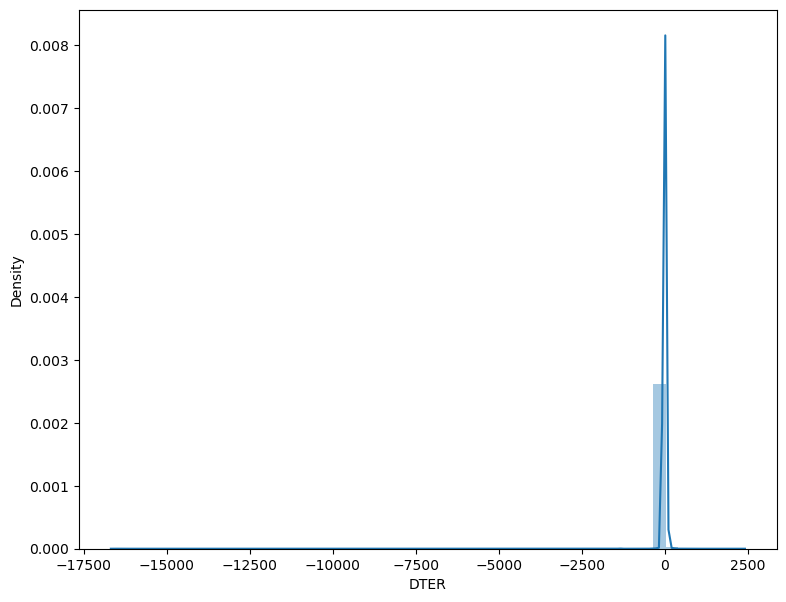

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


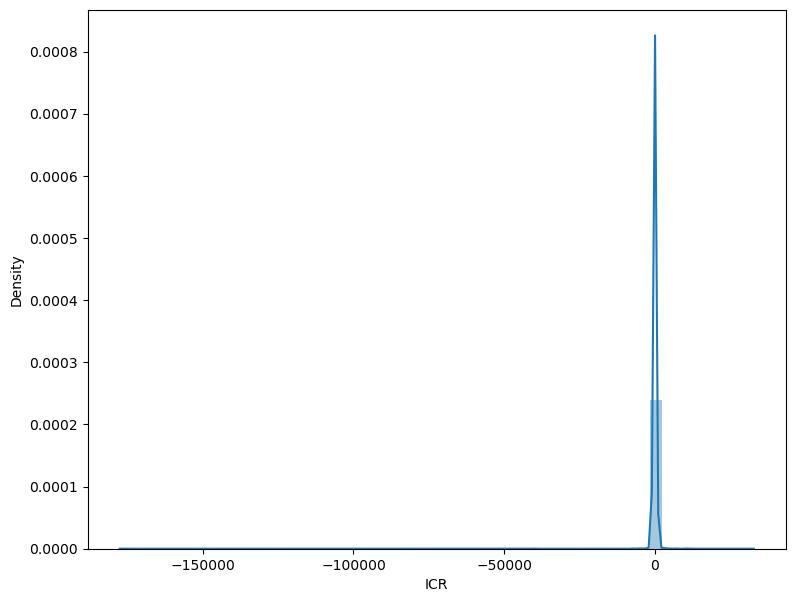

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


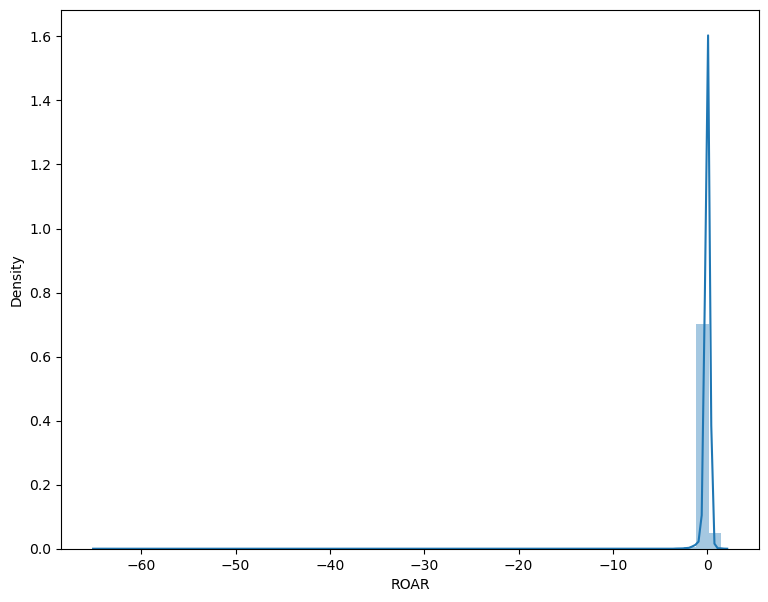

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


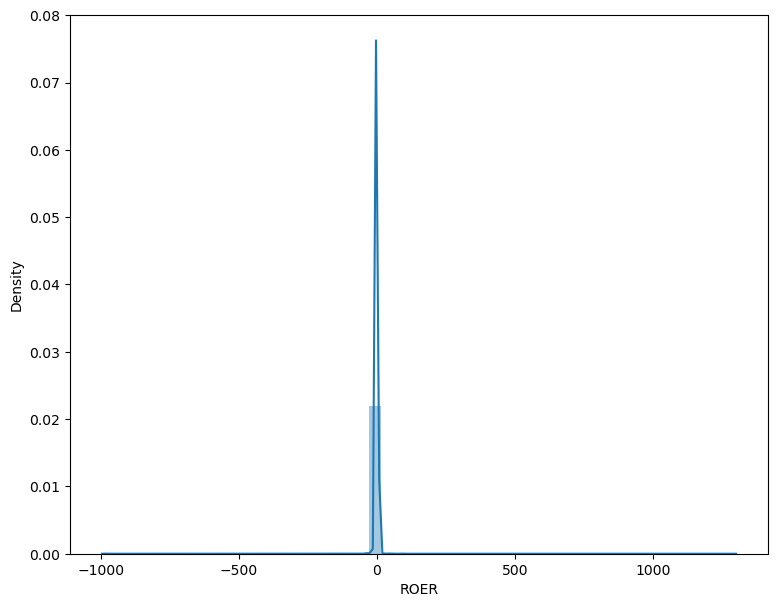

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


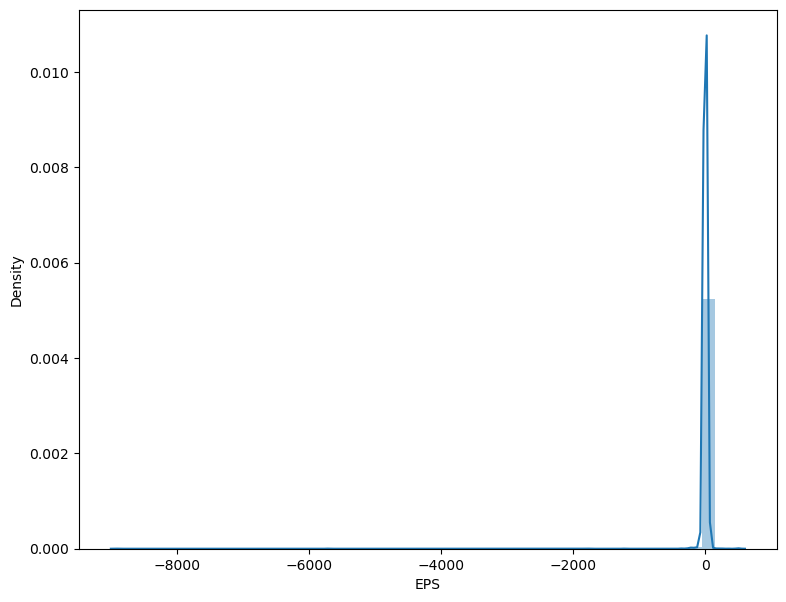

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


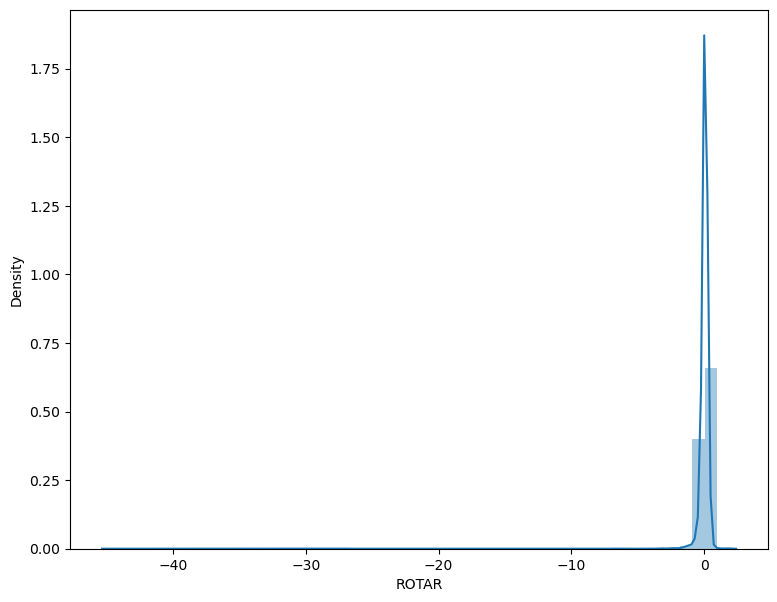

C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\432434980.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_variables[i])
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


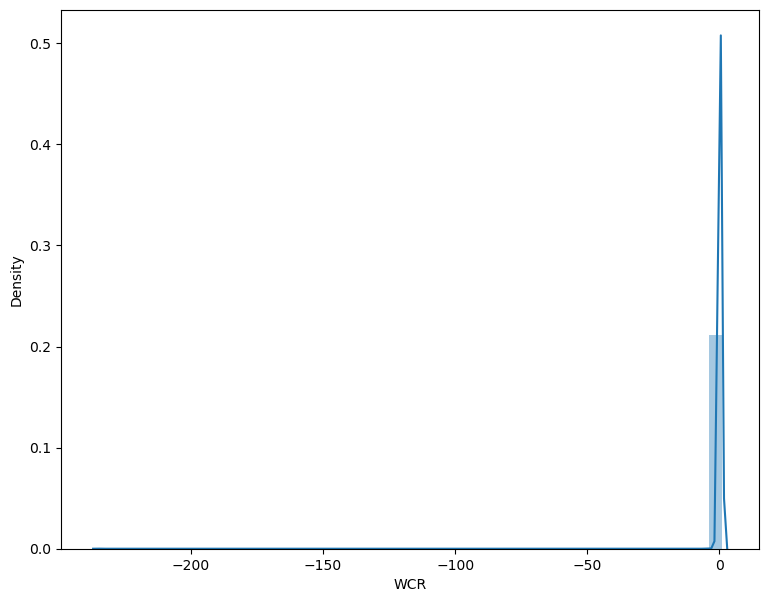

In [86]:
# Distribution plots of numerical variables
numerical_variables =  all_data_trim.select_dtypes(exclude=[np.object])
for i in numerical_variables.columns:   
    plt.figure(figsize=(9, 7))
    sns.distplot(numerical_variables[i])
    plt.show()

In [87]:
# Skew and kurtosis for variables
print("Skews:", all_data_trim[variables].skew(), "Kurtosis:", all_data_trim[variables].kurtosis())

Skews: CR                               6.03
ATR                              6.93
DR                              50.93
DTER                           -55.84
ICR                            -53.43
ROAR                           -41.23
ROER                            13.03
EPS                            -50.62
ROTAR                          -36.54
WCR                            -52.38
GDP_Growth                      -0.32
CPI_Yearly_Avg                  -0.18
dtype: float64 Kurtosis: CR                              70.36
ATR                             88.54
DR                           2,869.98
DTER                         3,631.04
ICR                          3,491.12
ROAR                         1,911.33
ROER                         1,888.39
EPS                          2,828.82
ROTAR                        1,503.36
WCR                          3,000.80
GDP_Growth                      -0.95
CPI_Yearly_Avg                  -1.22
dtype: float64


C:\Users\brig_\AppData\Local\Temp\ipykernel_26696\1077220112.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numerical_variables =  all_data_trim.select_dtypes(exclude=[np.object])


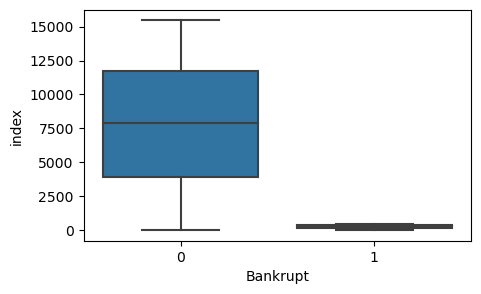

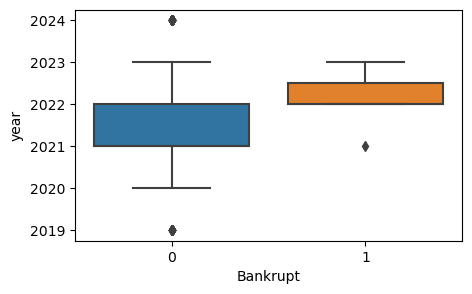

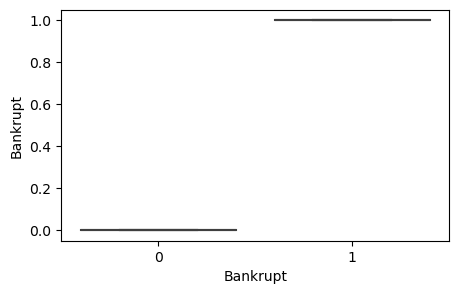

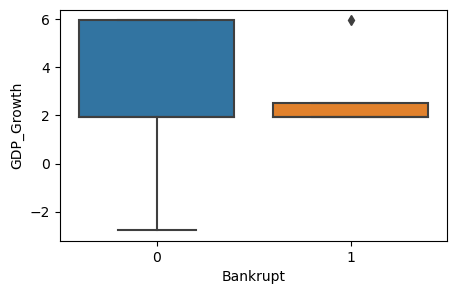

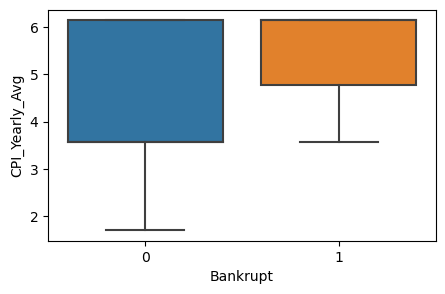

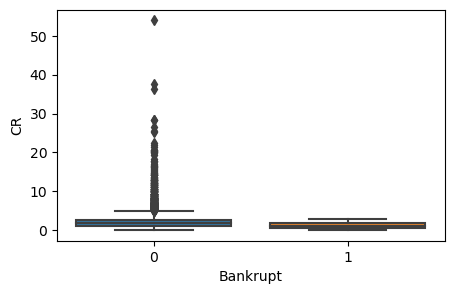

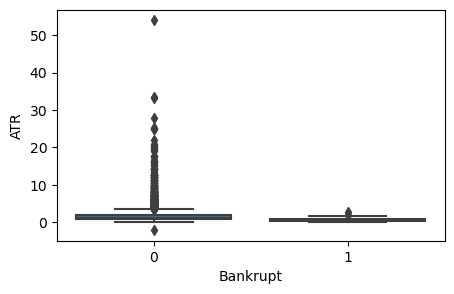

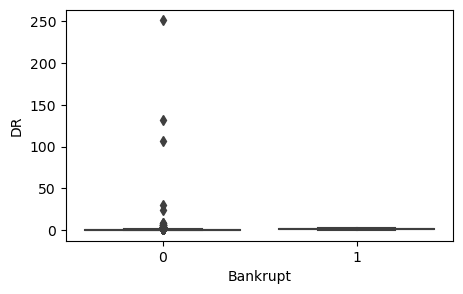

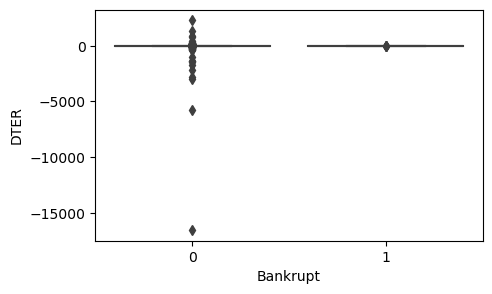

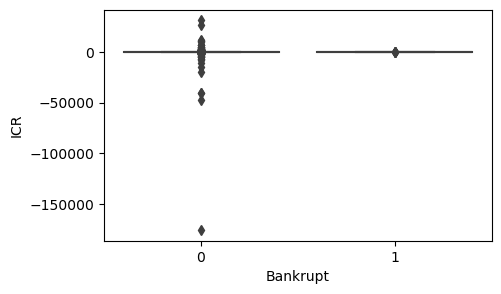

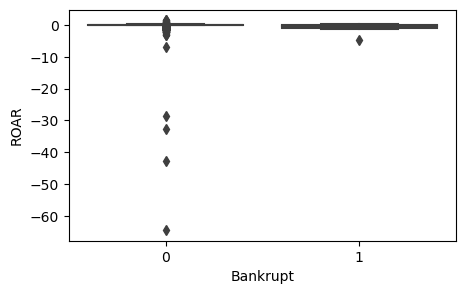

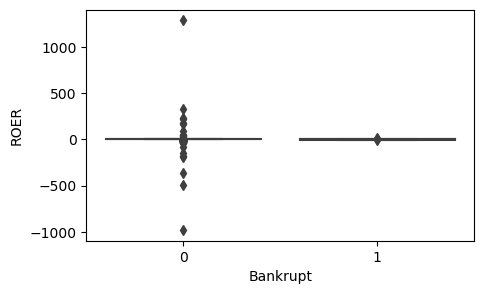

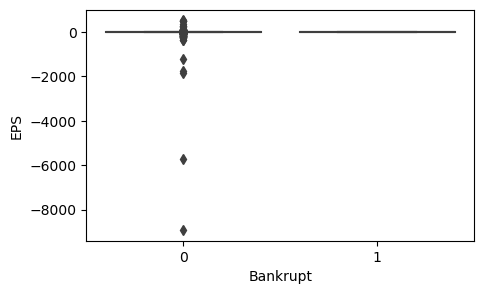

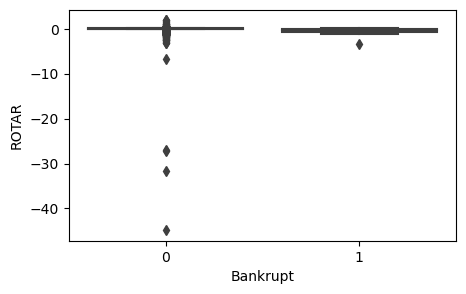

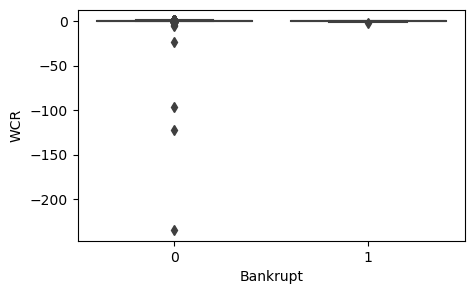

In [88]:
# Boxplots for each variable by binary target
numerical_variables =  all_data_trim.select_dtypes(exclude=[np.object])
for i in numerical_variables.columns:   
    plt.figure(figsize=(5, 3))
    sns.boxplot(x='Bankrupt', y=numerical_variables[i], data=all_data_trim)
    plt.show()

In [89]:
# Descriptive statistics by sector for Current Ratio, Acid-test Ratio, and Debt Ratio
all_data_trim[['Sector','CR', 'ATR', 'DR']].groupby('Sector').describe()

CR                       \
                                  count                 mean   
Sector                                                         
Basic Materials                  459.00                 2.53   
Communication                    154.00                 1.53   
Consumer Cyclical              1,103.00                 2.01   
Consumer Defensive               453.00                 2.05   
Energy                           378.00                 1.80   
Financial                         21.00                 2.05   
Healthcare                       880.00                 3.84   
Industrials                    1,186.00                 2.21   
Real Estate                      108.00                 2.66   
Technology                       780.00                 2.50   
Utilities                        259.00                 1.06   

                                                              \
                                    std                  min   
Sector                                                         
Basic Materials                    2.02                 0.02   
Communication                      1.68                 0.10   
Consumer Cyclical                  2.41                 0.19   
Consumer Defensive                 1.66                 0.30   
Energy                             1.42                 0.37   
Financial                          1.21                 0.31   
Healthcare                         3.86                 0.00   
Industrials                        1.53                 0.12   
Real Estate                        3.51                 0.11   
Technology                         1.85                 0.13   
Utilities                          1.07                 0.29   

                                                              \
                                    25%                  50%   
Sector                                                         
Basic Materials                    1.56                 2.09   
Communication                      0.77                 1.15   
Consumer Cyclical                  1.11                 1.53   
Consumer Defensive                 1.02                 1.55   
Energy                             1.01                 1.40   
Financial                          1.18                 1.53   
Healthcare                         1.61                 2.65   
Industrials                        1.39                 1.92   
Real Estate                        0.66                 1.50   
Technology                         1.40                 2.00   
Utilities                          0.63                 0.79   

                                                              \
                                    75%                  max   
Sector                                                         
Basic Materials                    2.88                21.44   
Communication                      1.71                17.81   
Consumer Cyclical                  2.22                37.65   
Consumer Defensive                 2.58                14.45   
Energy                             2.08                12.03   
Financial                          2.68                 5.74   
Healthcare                         4.76                54.02   
Industrials                        2.62                20.06   
Real Estate                        2.99                18.20   
Technology                         3.03                20.32   
Utilities                          1.13                10.51   

                                    ATR                       ...  \
                                  count                 mean  ...   
Sector                                                        ...   
Basic Materials                  459.00                 1.69  ...   
Communication                    154.00                 1.42  ...   
Consumer Cyclical              1,103.00                 1.28  ...   
Consumer Defensive               45

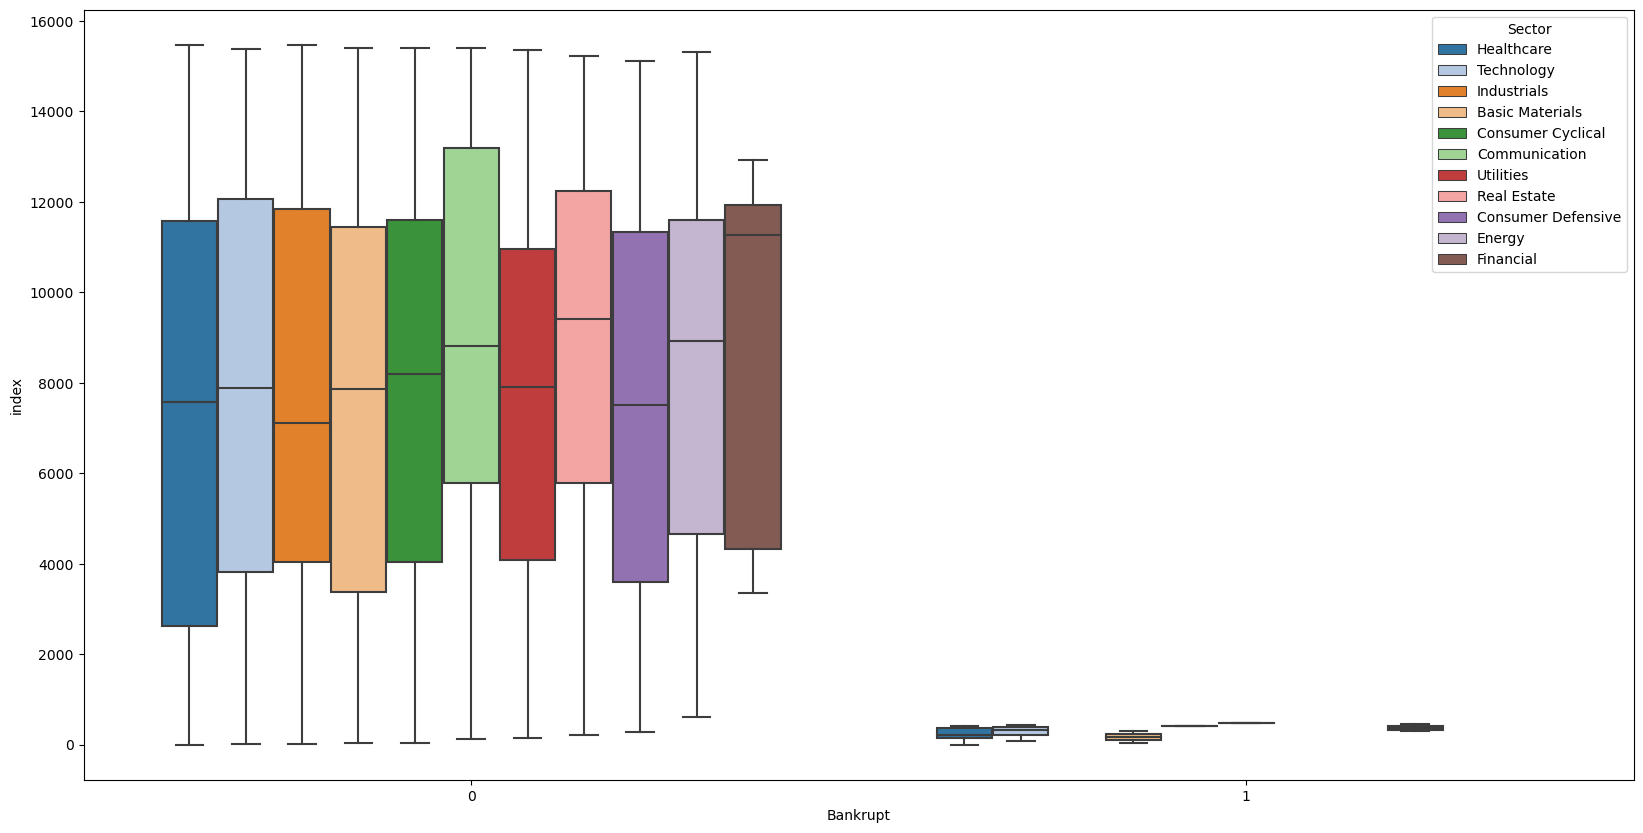

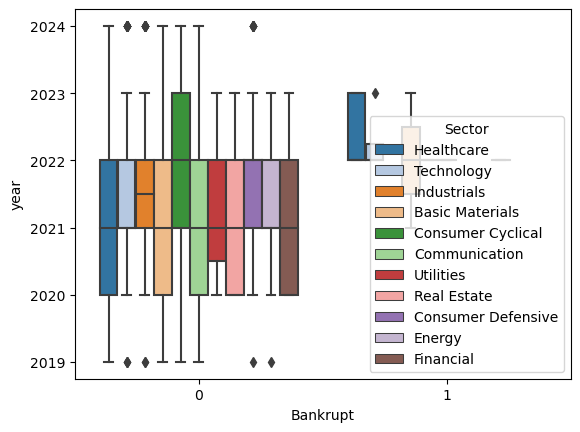

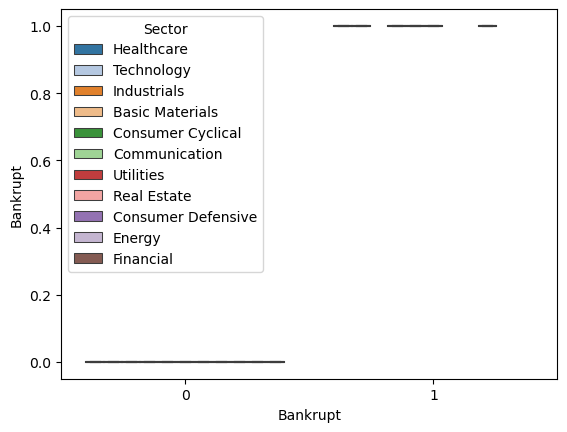

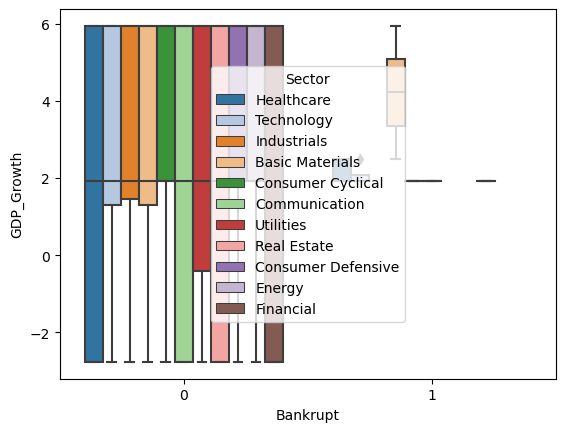

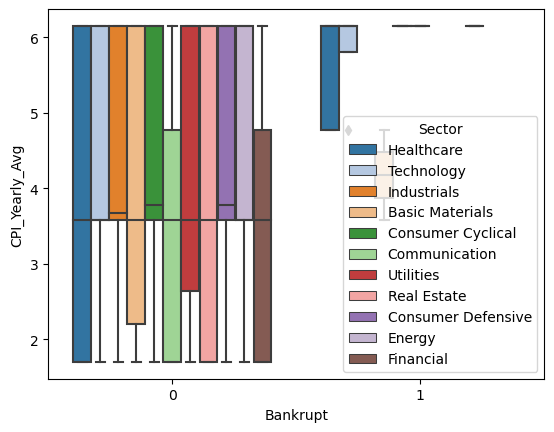

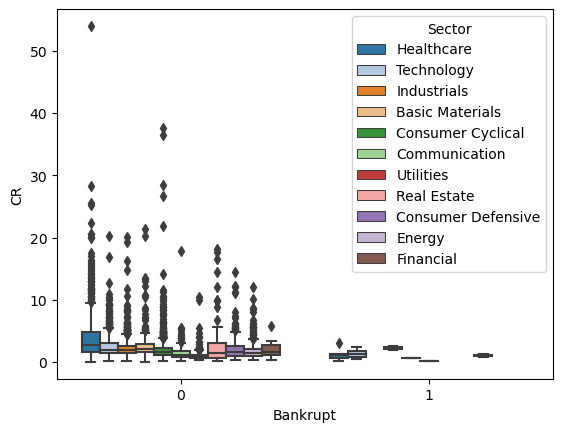

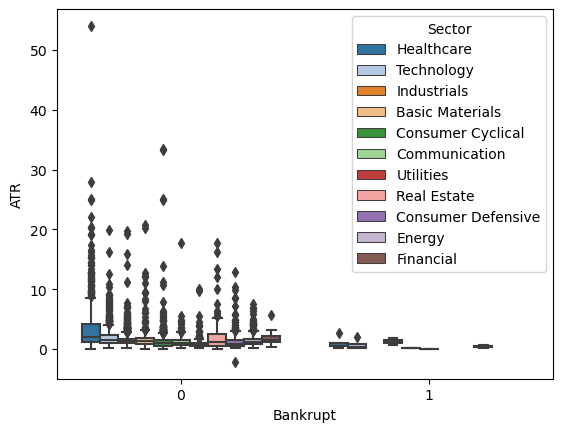

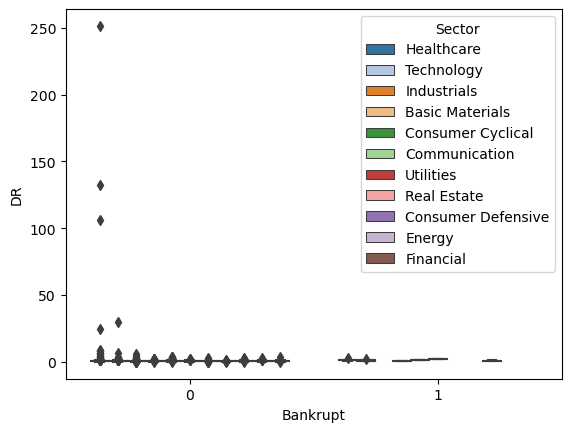

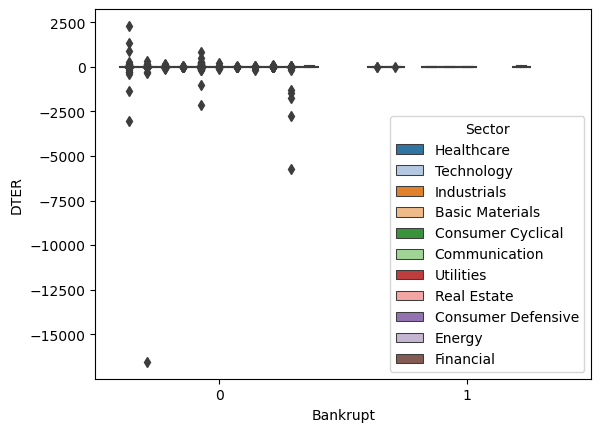

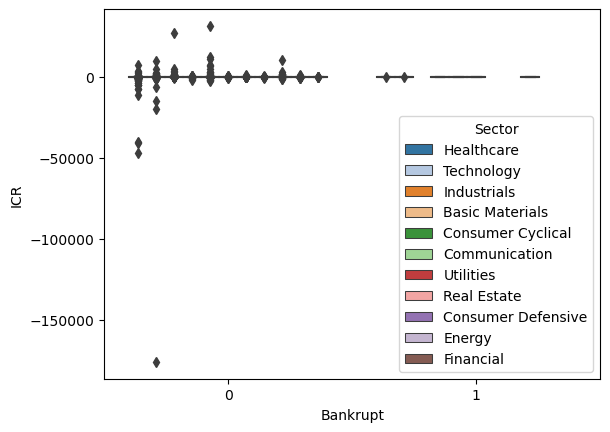

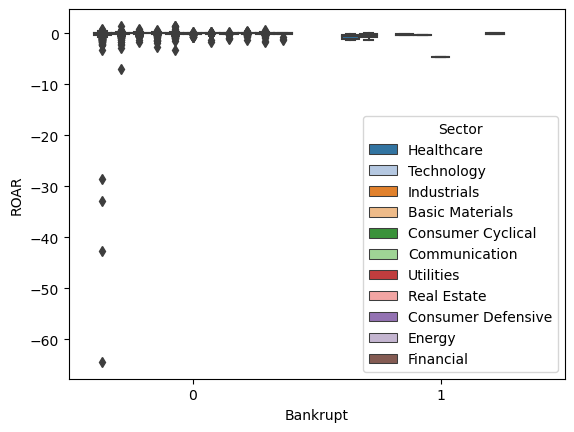

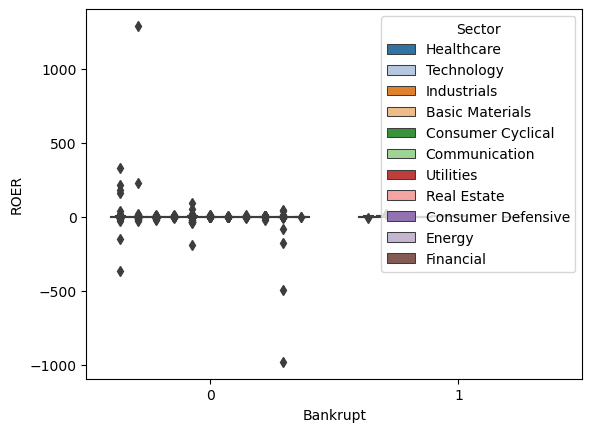

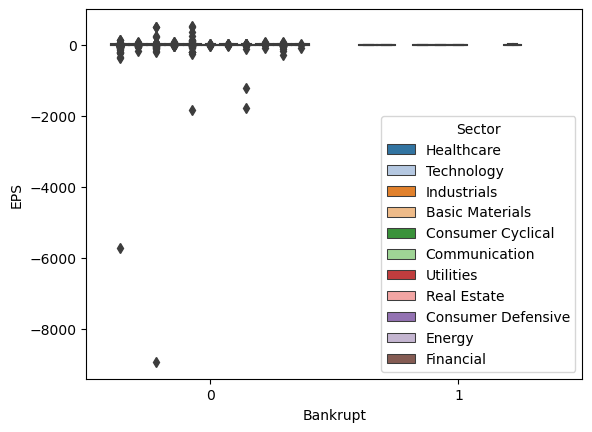

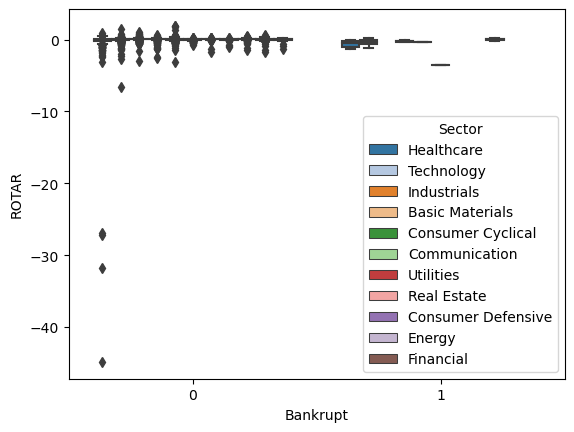

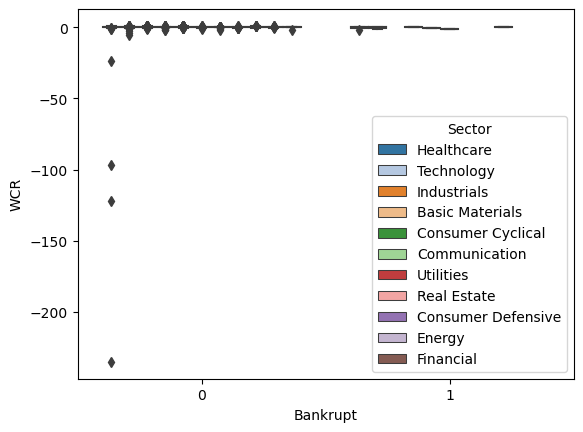

In [90]:
# Boxplot by bankruptcy binary variable and sector
plt.figure(figsize=(20,10))
for i in numerical_variables.columns:
    sns.boxplot(data=all_data_trim, y=numerical_variables[i], x='Bankrupt', hue='Sector', palette='tab20')
    plt.show()

In [91]:
# Ordinary least squares model of variables versus binary target
ols = smf.ols('Bankrupt ~ CR + ATR + DR + DTER + ICR + ROAR + ROER + EPS + ROTAR + WCR + GDP_Growth + CPI_Yearly_Avg', all_data_trim).fit()

In [92]:
# Results of model for feature selection
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Bankrupt   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.264
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           9.35e-07
Time:                        16:00:02   Log-Likelihood:                 9041.0
No. Observations:                5781   AIC:                        -1.806e+04
Df Residuals:                    5768   BIC:                        -1.797e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0045      0.002     -1.991      0.047      -0.009   -6.88e-05
CR                -0.0006      0.001     -0.649      0.516      -0.002       0.001
ATR            -7.495e-05      0.001     -0.074      0.941      -0.002       0.002
DR                 0.0012      0.001      0.920      0.358      -0.001       0.004
DTER            2.548e-07   3.05e-06      0.083      0.933   -5.73e-06    6.24e-06
ICR              7.68e-08   2.54e-07      0.302      0.762   -4.21e-07    5.75e-07
ROAR              -0.0183      0.007     -2.505      0.012      -0.033      -0.004
ROER            5.605e-06   3.09e-05      0.181      0.856    -5.5e-05    6.62e-05
EPS             1.228e-06   4.61e-06      0.267      0.790    -7.8e-06    1.03e-05
ROTAR              0.0104      0.008      1.381      0.167      -0.004       0.025
WCR                0.0045      0.002      2.953      0.003       0.002       0.007
GDP_Growth        -0.0003      0.000     -1.185      0.236      -0.001       0.000
CPI_Yearly_Avg     0.0018      0.000      3.950      0.000       0.001       0.003
==============================================================================
Omnibus:                    12408.726   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34051850.652
Skew:                          19.293   Prob(JB):                         0.00
Kurtosis:                     377.003   Cond. No.                     4.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [93]:
# Wald test of ROAR and WCR to determine relationship
print(ols.wald_test('(ROAR = 0, WCR = 0)'))

<F test: F=array([[6.01642896]]), p=0.002453690354727592, df_denom=5.77e+03, df_num=2>


C:\Users\brig_\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [94]:
# Second Ordinary Least Squares model with select variables
ols2 = smf.ols('Bankrupt ~ CR + ROAR + WCR + CPI_Yearly_Avg', all_data_trim).fit()

In [95]:
# Results of second model
ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Bankrupt   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     11.64
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           2.06e-09
Time:                        16:00:04   Log-Likelihood:                 9038.7
No. Observations:                5781   AIC:                        -1.807e+04
Df Residuals:                    5776   BIC:                        -1.803e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0029      0.002     -1.469      0.142      -0.007       0.001
CR                -0.0006      0.000     -2.239      0.025      -0.001   -7.77e-05
ROAR              -0.0086      0.002     -5.488      0.000      -0.012      -0.006
WCR                0.0025      0.001      5.021      0.000       0.002       0.004
CPI_Yearly_Avg     0.0016      0.000      3.848      0.000       0.001       0.002
==============================================================================
Omnibus:                    12414.512   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34148541.998
Skew:                          19.314   Prob(JB):                         0.00
Kurtosis:                     377.535   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 8. Logistic Regression Model

In [96]:
# Create correlation matrix
lr_corr = all_data_trim[variables].corr()
lr_corr

,CR,ATR,DR,DTER,ICR,ROAR,ROER,EPS,ROTAR,WCR,GDP_Growth,CPI_Yearly_Avg
CR,1.00,0.96,-0.05,0.01,-0.01,0.02,-0.00,0.01,0.01,0.06,-0.01,-0.04
ATR,0.96,1.00,-0.04,0.01,-0.03,0.01,-0.00,0.01,0.00,0.05,-0.01,-0.06
DR,-0.05,-0.04,1.00,-0.00,-0.01,-0.93,0.00,-0.02,-0.89,-0.99,0.00,-0.02
DTER,0.01,0.01,-0.00,1.00,-0.00,0.00,-0.46,0.00,0.00,0.00,0.02,0.01
ICR,-0.01,-0.03,-0.01,-0.00,1.00,0.02,0.00,0.01,0.02,-0.00,-0.00,-0.01
ROAR,0.02,0.01,-0.93,0.00,0.02,1.00,-0.00,0.03,0.99,0.93,0.01,0.03
ROER,-0.00,-0.00,0.00,-0.46,0.00,-0.00,1.00,0.00,0.00,-0.00,-0.02,-0.02
EPS,0.01,0.01,-0.02,0.00,0.01,0.03,0.00,1.00,0.03,0.00,0.04,0.03
ROTAR,0.01,0.00,-0.89,0.00,0.02,0.99,0.00,0.03,1.00,0.89,0.01,0.04
WCR,0.06,0.05,-0.99,0.00,-0.00,0.93,-0.00,0.00,0.89,1.00,-0.01,0.02


<Axes: >

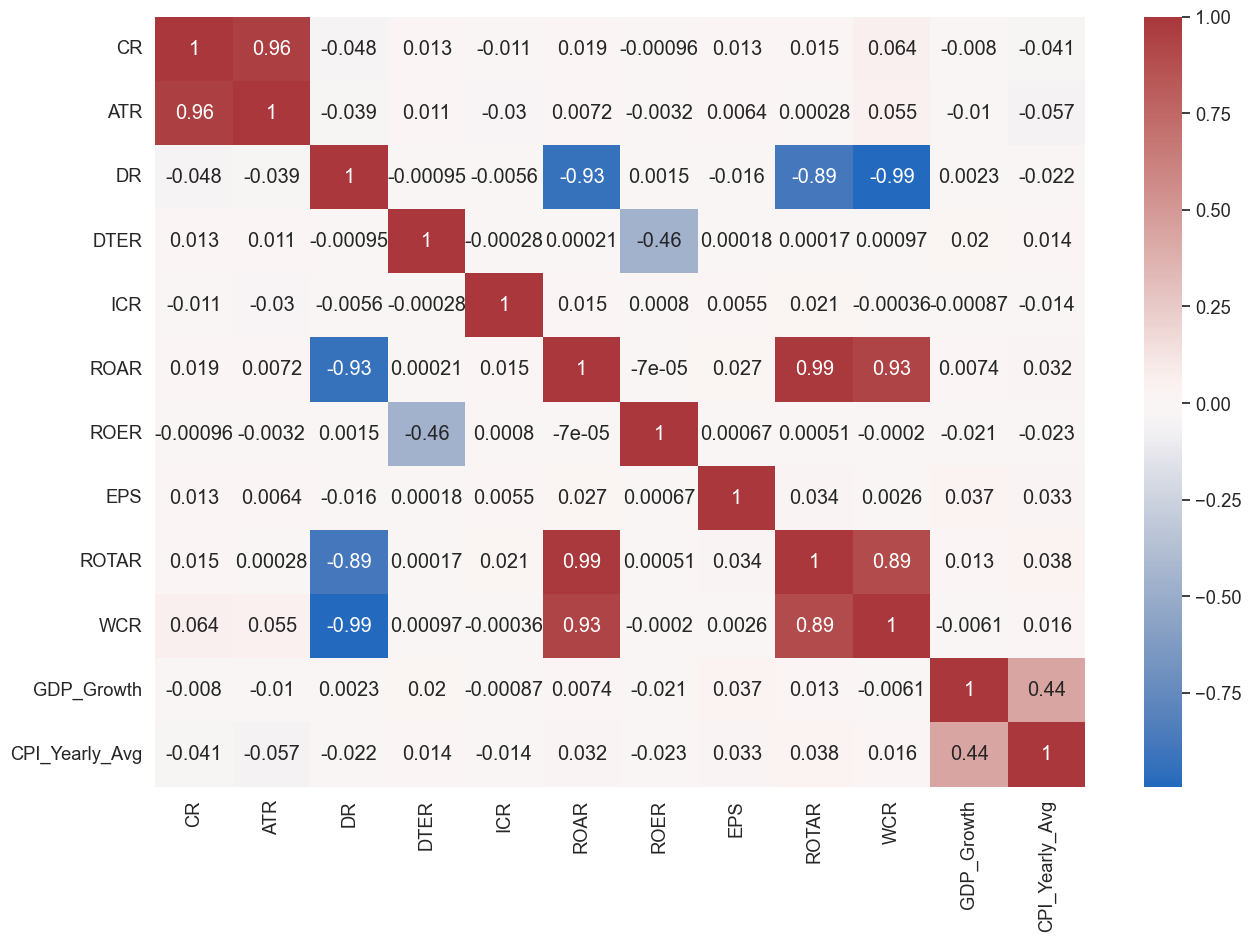

In [97]:
# View correlation matrix as a heatmap
sns.set(font_scale=1.2)
plt.figure(figsize=(15,10))
sns.heatmap(all_data_trim[variables].corr(), cmap='vlag', annot=True)

In [98]:
# Create copy of dataframe for model
all_data_ratios_lr = all_data_trim

In [99]:
# Scale the data due to large ranges
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(all_data_ratios_lr[variables])

In [100]:
# Scale the data due to large ranges
x_lr_r = RobustScaler().fit_transform(all_data_ratios_lr[variables])

In [101]:
# Data for Models
X = x_lr_r
y = all_data_ratios_lr['Bankrupt']

In [102]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(x_lr_r, y, test_size=0.30, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4046, 12)
(1735, 12)
(4046,)
(1735,)


In [103]:
# Check number of each binary target in training set
y_train.value_counts()

Bankrupt
0    4036
1      10
Name: count, dtype: int64

In [104]:
# Check number of each binary target in training set
y_test.value_counts()

Bankrupt
0    1730
1       5
Name: count, dtype: int64

In [105]:
# Prepare logistic regression model
classifier = LogisticRegression(solver='lbfgs', C=10, max_iter=1000)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [106]:
# View results
result = pd.DataFrame({'Actual' : y_test, 'Predicted' : y_pred})
result

,Actual,Predicted
4106,0,0
1652,0,0
3774,0,0
3269,0,0
4965,0,0
...,...,...
1165,0,0
4637,0,0
1768,0,0
4989,0,0


In [107]:
# View results as confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[1729,    1],
       [   5,    0]], dtype=int64)

Text(0.5, 16.049999999999997, 'Predicted label')

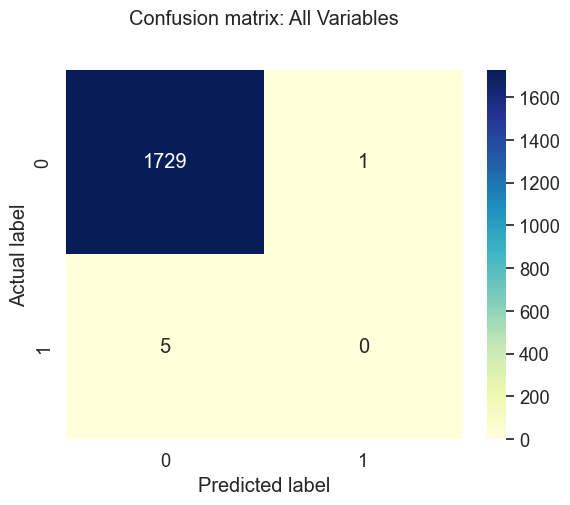

In [108]:
# View confusion matrix as heatmap
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix: All Variables', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [109]:
# Check accuracy score
accuracy_score(y_test,y_pred)

0.9965417867435159

In [110]:
# Check precision, recall
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1730
           1       0.00      0.00      0.00         5

    accuracy                           1.00      1735
   macro avg       0.50      0.50      0.50      1735
weighted avg       0.99      1.00      1.00      1735



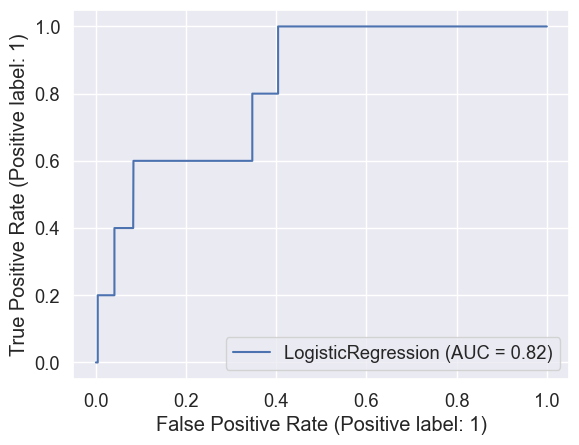

In [111]:
# View ROC AUC curve
lr_disp = RocCurveDisplay.from_estimator(classifier, X_test, y_test)
plt.show()

In [112]:
# Variables based on VIF and correlation matrix
select_var = ['CR', 'DR', 'ROAR', 'ATR', 'CPI_Yearly_Avg']

In [113]:
# Create x dataset using only selected variables
x_lr = all_data_ratios_lr[select_var]

In [114]:
# logit_model=sm.Logit(y,x_lr)
# result=logit_model.fit()
# print(result.summary2())

In [115]:
# Scale data
x_lr_r2 = RobustScaler().fit_transform(all_data_trim[select_var])

In [116]:
# Train test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(x_lr_r2, y, test_size=0.30, random_state=1)
print(X_train1.shape)
print(X_test1.shape)
print(y_train1.shape)
print(y_test1.shape)

(4046, 5)
(1735, 5)
(4046,)
(1735,)


In [117]:
# Logistic regression model using only select variables
classifier_lr = LogisticRegression(solver='lbfgs', C=1, max_iter=1000)
classifier_lr.fit(X_train1, y_train1)
y_pred_lr = classifier_lr.predict(X_test1)

In [118]:
# View results as confusion matrix
cf_matrix_lr = confusion_matrix(y_test1, y_pred_lr)
cf_matrix_lr

array([[1729,    1],
       [   5,    0]], dtype=int64)

0.9965417867435159


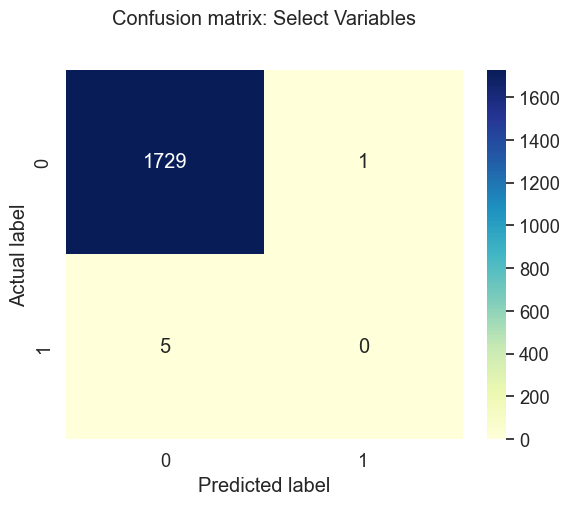

In [119]:
# View confusion matrix as heatmap
sns.heatmap(pd.DataFrame(cf_matrix_lr), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix: Select Variables', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(accuracy_score(y_test,y_pred_lr))

In [120]:
# View precision and recall
print(classification_report(y_test1, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1730
           1       0.00      0.00      0.00         5

    accuracy                           1.00      1735
   macro avg       0.50      0.50      0.50      1735
weighted avg       0.99      1.00      1.00      1735



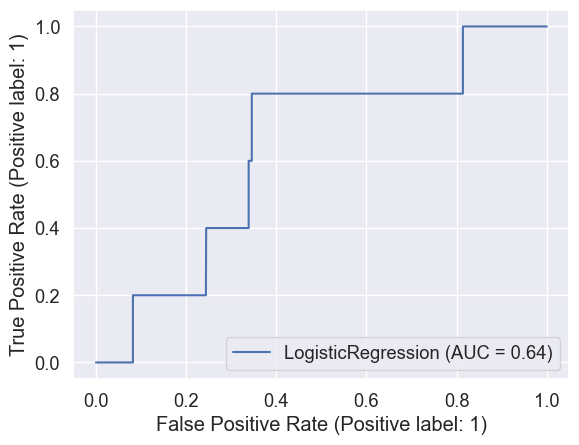

In [121]:
# View ROC AUC curve
lr_disp2 = RocCurveDisplay.from_estimator(classifier_lr, X_test1, y_test1)
plt.show()

## 9. Support Vector Machine Model

In [122]:
# Create x and y dataframes using all variables
X_svm = all_data_trim[variables]
y_svm = all_data_trim['Bankrupt']

In [123]:
# Scale data
x_svm_r = RobustScaler().fit_transform(all_data_trim[variables])

In [124]:
# Train test split
X_svm_train, X_svm_test, y_svm_train, y_svm_test = train_test_split(x_svm_r, y_svm, test_size=0.3,random_state=1)

In [126]:
# Create SVM Model
svm_model = svm.SVC(kernel='poly')
svm_model.fit(X_svm_train, y_svm_train)
y_pred_svm = svm_model.predict(X_svm_test)

Text(0.5, 16.049999999999997, 'Predicted label')

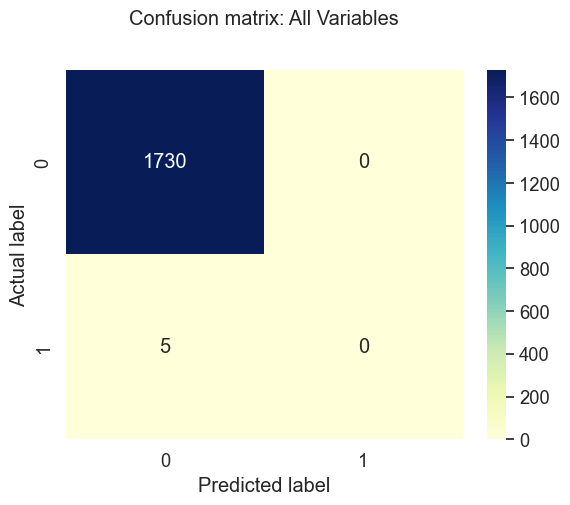

In [127]:
# View results as confusion matrix heatmap
cf_matrix_svm = confusion_matrix(y_svm_test, y_pred_svm)
sns.heatmap(pd.DataFrame(cf_matrix_svm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix: All Variables', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [128]:
# View accuracy, precision, and recall scores
print("Accuracy:",metrics.accuracy_score(y_svm_test, y_pred_svm))
print("Precision:",metrics.precision_score(y_svm_test, y_pred_svm))
print("Recall:",metrics.recall_score(y_svm_test, y_pred_svm))

Accuracy: 0.9971181556195965
Precision: 0.0
Recall: 0.0


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


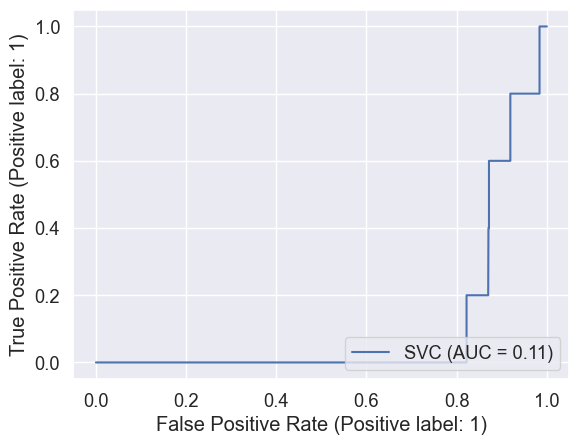

In [129]:
# View ROC AUC curve
svc_disp = RocCurveDisplay.from_estimator(svm_model, X_svm_test, y_svm_test)
plt.show()

In [130]:
# Create dataframes of select variables 
X_svm2 = all_data_trim[select_var]
y_svm2 = all_data_trim['Bankrupt']

In [131]:
# Scale data
x_svm_r2 = RobustScaler().fit_transform(all_data_trim[select_var])

In [132]:
# Train test split
X_svm_train2, X_svm_test2, y_svm_train2, y_svm_test2 = train_test_split(x_svm_r2, y_svm2, test_size=0.3,random_state=1)

In [ ]:
# def calculate_best_params(grid):
#     model = svm.SVC()
#     svm_cv = GridSearchCV(model, grid, cv=3)
#     svm_cv.fit(X_svm_train2, y_svm_train2)
#     print("Best parameters:", svm_cv.best_params_)
#     print("Train Score:", svm_cv.best_score_)
#     print("Test Score:", svm_cv.score(X_svm_test2, y_svm_test2))
    
# grid = {'C':[0.01, 0.1, 1, 10],
#        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#        'degree': [1, 3, 5, 7],
#        'gamma': [0.01, 0.1, 1, 10]}

# calculate_best_params(grid)

In [133]:
# Create SVM Model with selected variables only
svm_model2 = svm.SVC(kernel='rbf', degree=1, gamma=1)
svm_model2.fit(X_svm_train2, y_svm_train2)
y_pred_svm2 = svm_model2.predict(X_svm_test2)

Text(0.5, 16.049999999999997, 'Predicted label')

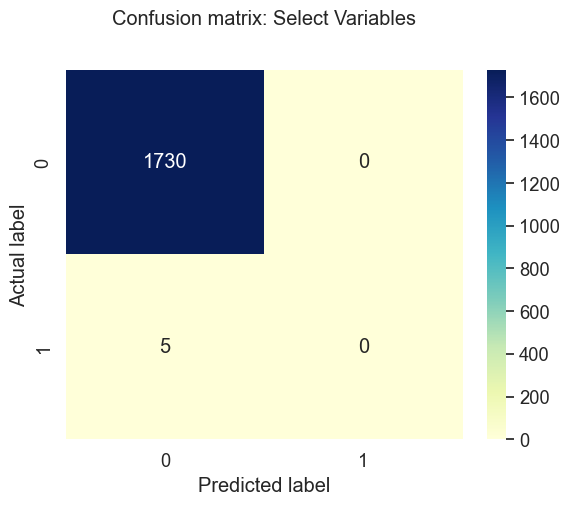

In [134]:
# View confustion matrix as heatmap
cf_matrix_svm2 = confusion_matrix(y_svm_test2, y_pred_svm2)
sns.heatmap(pd.DataFrame(cf_matrix_svm2), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix: Select Variables', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [135]:
# View accuracy, precision, and recall values
print("Accuracy:",metrics.accuracy_score(y_svm_test2, y_pred_svm2))
print("Precision:",metrics.precision_score(y_svm_test2, y_pred_svm2))
print("Recall:",metrics.recall_score(y_svm_test2, y_pred_svm2))

Accuracy: 0.9971181556195965
Precision: 0.0
Recall: 0.0


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


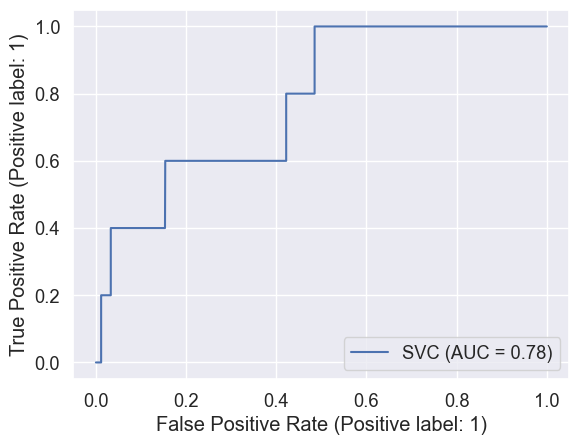

In [136]:
# View ROC AUC curve
svc_disp2 = RocCurveDisplay.from_estimator(svm_model2, X_svm_test2, y_svm_test2)
plt.show()

## 10. XGBoost Model

In [137]:
# Create data with all variables
X_xgb = all_data_trim[variables]
y_xgb = all_data_trim['Bankrupt']

In [138]:
# Train test split
X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(X_xgb, y_xgb, test_size=0.3,random_state=1)

In [139]:
# XGBoost model
xgb_class = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    objective='binary:logistic',
    eval_metric='auc',
)
xgb_class.fit(X_xgb_train, y_xgb_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [140]:
# Prediction model
y_xgb_pred = xgb_class.predict(X_xgb_test)

In [141]:
# View precision and recall values
print(classification_report(y_xgb_test, y_xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1730
           1       0.00      0.00      0.00         5

    accuracy                           1.00      1735
   macro avg       0.50      0.50      0.50      1735
weighted avg       0.99      1.00      1.00      1735



Text(0.5, 16.049999999999997, 'Predicted label')

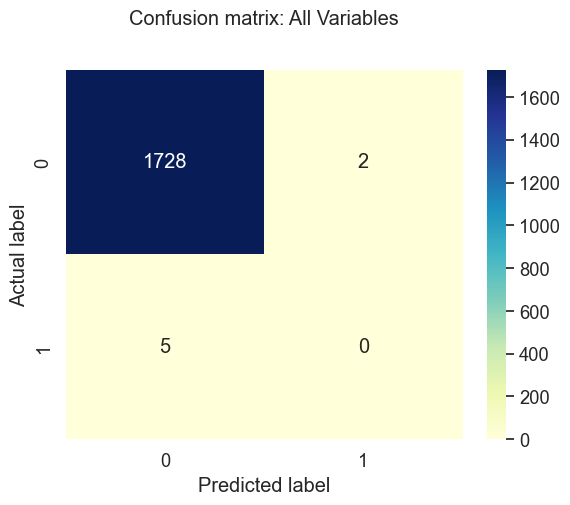

In [142]:
# View results of confusion matrix as heatmap
cf_matrix_xgb = confusion_matrix(y_xgb_test, y_xgb_pred)
sns.heatmap(pd.DataFrame(cf_matrix_xgb), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix: All Variables', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [143]:
# View results of model
print("Accuracy:",metrics.accuracy_score(y_xgb_test, y_xgb_pred))
print("Precision:",metrics.precision_score(y_xgb_test, y_xgb_pred))
print("Recall:",metrics.recall_score(y_xgb_test, y_xgb_pred))

Accuracy: 0.9959654178674352
Precision: 0.0
Recall: 0.0


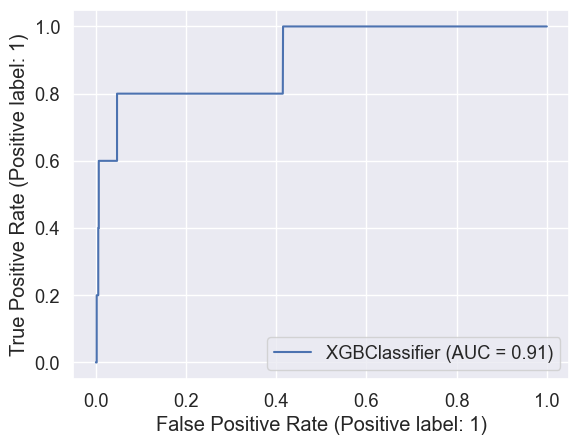

In [144]:
# View ROC AUC curve
xgb_disp = RocCurveDisplay.from_estimator(xgb_class, X_xgb_test, y_xgb_test)
plt.show()

In [145]:
# Use only select variables for model
X_xgb2 = all_data_trim[select_var]
y_xgb2 = all_data_trim['Bankrupt']

In [146]:
# Train test split
X_xgb_train2, X_xgb_test2, y_xgb_train2, y_xgb_test2 = train_test_split(X_xgb2, y_xgb2, test_size=0.3,random_state=1)

In [147]:
# XGBoost model with selected variables
xgb_class2 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    objective='binary:logistic',
    eval_metric='auc',
    #reg_lambda=100,
    #alpha=100
)
xgb_class2.fit(X_xgb_train2, y_xgb_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [148]:
# Model prediction
y_xgb_pred2 = xgb_class2.predict(X_xgb_test2)

Text(0.5, 16.049999999999997, 'Predicted label')

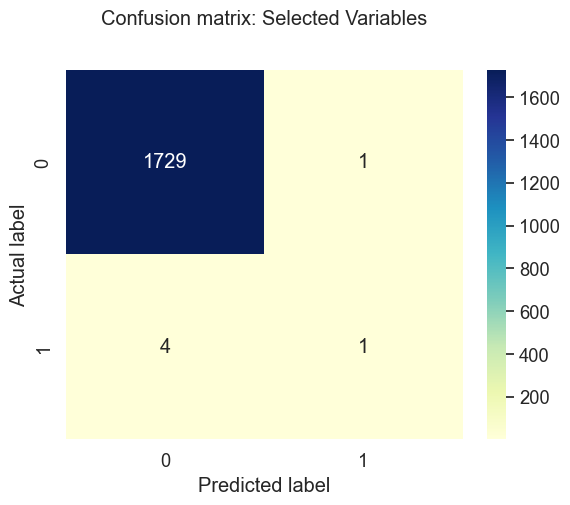

In [149]:
# View confusion matrix as heatmap
cf_matrix_xgb2 = confusion_matrix(y_xgb_test2, y_xgb_pred2)
sns.heatmap(pd.DataFrame(cf_matrix_xgb2), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix: Selected Variables', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [150]:
# View results
print("Accuracy:",metrics.accuracy_score(y_xgb_test2, y_xgb_pred2))
print("Precision:",metrics.precision_score(y_xgb_test2, y_xgb_pred2))
print("Recall:",metrics.recall_score(y_xgb_test2, y_xgb_pred2))

Accuracy: 0.9971181556195965
Precision: 0.5
Recall: 0.2


In [329]:
print(classification_report(y_xgb_test2, y_xgb_pred2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1730
           1       0.50      0.20      0.29         5

    accuracy                           1.00      1735
   macro avg       0.75      0.60      0.64      1735
weighted avg       1.00      1.00      1.00      1735



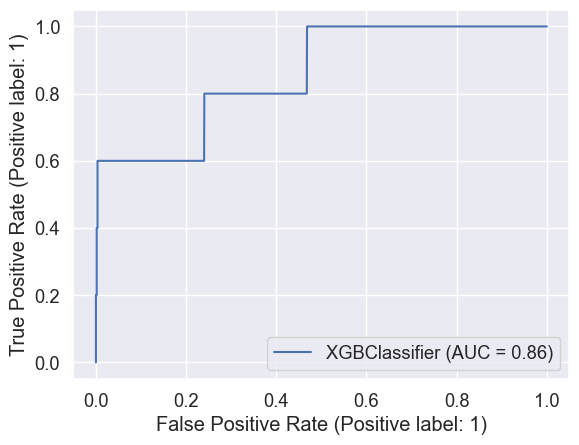

In [151]:
# View ROC AUC curve
xgb_disp2 = RocCurveDisplay.from_estimator(xgb_class2, X_xgb_test2, y_xgb_test2)
plt.show()

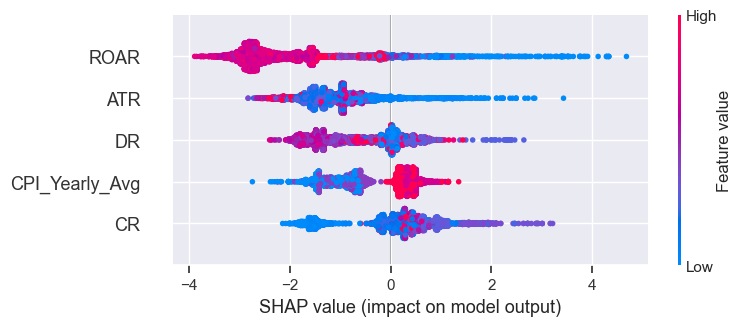

In [319]:
# SHAP evaluation
xgb_ex = shap.TreeExplainer(xgb_class2)
xgb_shap_values = xgb_ex.shap_values(X_xgb_test2)
shap.summary_plot(xgb_shap_values, X_xgb_test2)

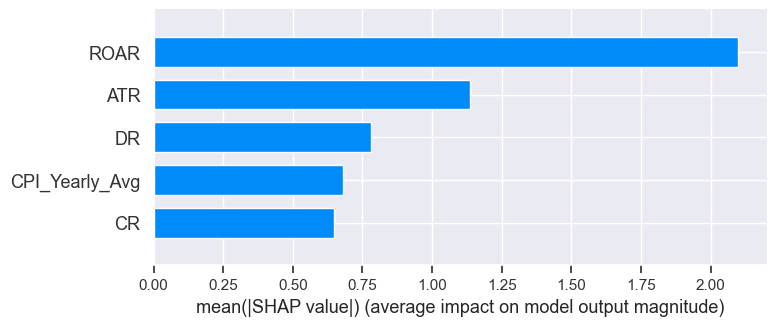

In [321]:
shap.summary_plot(xgb_shap_values, X_xgb_test2, plot_type="bar")

## 11. Artifical Neural Network Model

In [152]:
# Use all variables
X_ann = all_data_trim[variables]
y_ann = all_data_trim['Bankrupt']

In [153]:
# Scale data
x_ann_r = RobustScaler().fit_transform(all_data_trim[variables])

In [154]:
# Train test split
X_ann_train, X_ann_test, y_ann_train, y_ann_test = train_test_split(x_ann_r, y_ann, test_size=0.3,random_state=1)

In [156]:
# ANN model with all variables
ann_model = MLPClassifier(
    hidden_layer_sizes=(5,5,5), 
    activation='logistic', 
    solver='lbfgs',
    max_iter=1000,
    random_state=1)

ann_model.fit(X_ann_train, y_ann_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(5, 5, 5),
              max_iter=1000, random_state=1, solver='lbfgs')

In [157]:
# Model prediction
y_ann_pred = ann_model.predict(X_ann_test)

Text(0.5, 16.049999999999997, 'Predicted label')

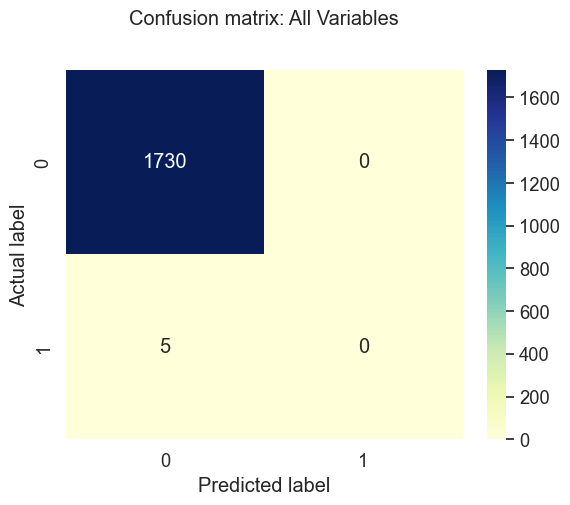

In [158]:
# Confusion matrix as heatmap
cf_matrix_ann = confusion_matrix(y_ann_test, y_ann_pred)
sns.heatmap(pd.DataFrame(cf_matrix_ann), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix: All Variables', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [159]:
# View results
print("Accuracy:",metrics.accuracy_score(y_ann_test, y_ann_pred))
print("Precision:",metrics.precision_score(y_ann_test, y_ann_pred))
print("Recall:",metrics.recall_score(y_ann_test, y_ann_pred))

Accuracy: 0.9971181556195965
Precision: 0.0
Recall: 0.0


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


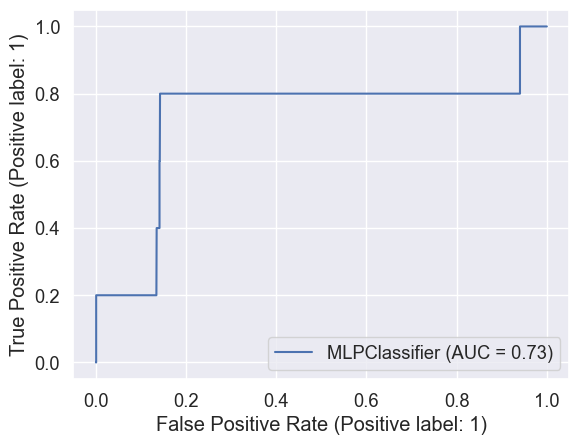

In [160]:
# View ROC AUC curve
ann_disp = RocCurveDisplay.from_estimator(ann_model, X_ann_test, y_ann_test)
plt.show()

In [331]:
# Use only selected variables
X_ann2 = all_data_trim[select_var]
y_ann = all_data_trim['Bankrupt']

In [332]:
# Scale data
x_ann_r2 = RobustScaler().fit_transform(all_data_trim[select_var])

In [334]:
# Train test split
X_ann_train2, X_ann_test2, y_ann_train2, y_ann_test2 = train_test_split(x_ann_r2, y_ann, test_size=0.3,random_state=1)

In [335]:
# ANN model using only selected variables
ann_model2 = MLPClassifier(
    hidden_layer_sizes=(5,5,5), 
    activation='logistic', 
    solver='lbfgs',
    alpha=1,
    max_iter=1000,
    random_state=1)

ann_model2.fit(X_ann_train2, y_ann_train2)

MLPClassifier(activation='logistic', alpha=1, hidden_layer_sizes=(5, 5, 5),
              max_iter=1000, random_state=1, solver='lbfgs')

In [336]:
# Model prediction
y_ann_pred2 = ann_model2.predict(X_ann_test2)

Text(0.5, 16.049999999999997, 'Predicted label')

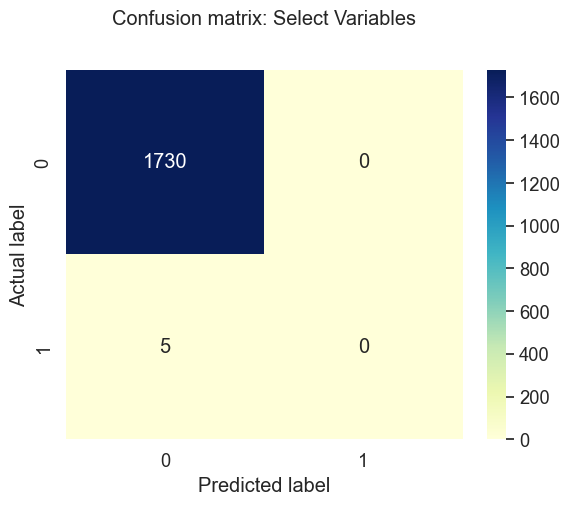

In [337]:
# Confusion matrix as heatmap
cf_matrix_ann2 = confusion_matrix(y_ann_test2, y_ann_pred2)
sns.heatmap(pd.DataFrame(cf_matrix_ann2), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix: Select Variables', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [338]:
# View results
print("Accuracy:",metrics.accuracy_score(y_ann_test2, y_ann_pred2))
print("Precision:",metrics.precision_score(y_ann_test2, y_ann_pred2))
print("Recall:",metrics.recall_score(y_ann_test2, y_ann_pred2))

Accuracy: 0.9971181556195965
Precision: 0.0
Recall: 0.0


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [339]:
print(classification_report(y_ann_test2, y_ann_pred2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1730
           1       0.00      0.00      0.00         5

    accuracy                           1.00      1735
   macro avg       0.50      0.50      0.50      1735
weighted avg       0.99      1.00      1.00      1735



C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


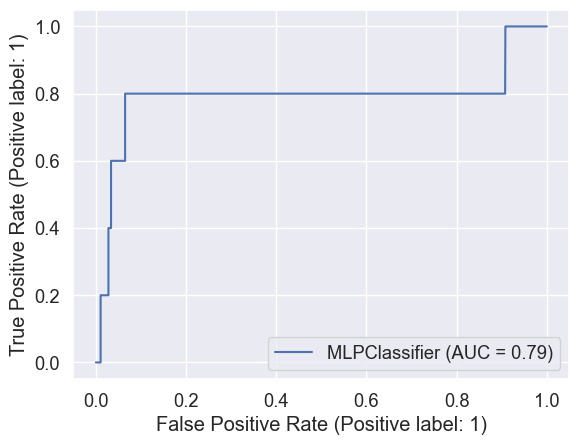

In [340]:
# View ROC AUC curve
ann_disp2 = RocCurveDisplay.from_estimator(ann_model2, X_ann_test2, y_ann_test2)
plt.show()